In [1]:
import os
import astropy
import requests
import pandas as pd
import numpy as np
import lightkurve as lk 
from scipy.interpolate import interp1d
from astropy.modeling import models, fitting
import matplotlib.pyplot as plt
import emcee
import sys
import csv
from astropy.timeseries import LombScargle
from os.path import basename, exists

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/utils/')
import filters # Suzanne's functions
import norm

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/ETV')
import etv_functions # Nora's functions 

%matplotlib inline

In [2]:
from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_base = './etv_out'  # for ETV
lk_download_dir = 'C:/dev/_juypter/PH_TESS_LightCurveViewer/data'  

# A command from shell that can be run to notify users, e.g., fitting is finished. Use "echo" if you do not have one
NOTIFY_CMD = "win-notify.bat"

if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir
if hasattr(lk.search, "sr_cache"):   # PR for persistent query result cache
    lk.search.sr_cache.cache_dir = lk_download_dir  # None
    lk.search.sr_cache.expire_second = 86400

## Looking for ETVs in TIC 156846286

- EB noted for quadratic period change (of ~0.52s/yr) in 2015A&A...578A.136 : LPeriod changes in SuperWASP eclipsing binaries (Lohr+, 2015)
https://www.aanda.org/articles/aa/full_html/2015/06/aa25747-15/aa25747-15.html

- [Vizier record](https://vizier.cds.unistra.fr/viz-bin/VizieR-5?-ref=VIZ6726469d348f5d&-out.add=.&-source=J/A%2bA/578/A136/linear&recno=565)



In [3]:
# define the plotting parameters

figsize = (8,4)

In [4]:
# import the data

# choose a TIC ID to analyze
ticid = 156846286  # 

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_path = f"{outfile_base}/tic{ticid}_etv_primary.csv"
outfile_path_s = f"{outfile_base}/tic{ticid}_etv_secondary.csv"


# import data using Lightkurve
# sr = lk.search_lightcurve('TIC {}'.format(ticid), author = 'SPOC')  
if not "../.." in sys.path:
    sys.path.append("../..")
import lightkurve_ext as lke  # at ../../
import astropy.units as u


sr = lk.search_lightcurve('TIC {}'.format(ticid))  # get long cadence data too
sr = lke.filter_by_priority(sr, author_priority=['SPOC', 'TESS-SPOC'], exptime_priority=['short', 'long', 'fast'])
# sr = sr[sr.exptime != 1800 *u.s]  # exclude 30min cadence data for now (TESS-SPOC, sectors 18, 19, 23 )
# sr = sr[np.isin(sr.author, ['SPOC', 'TESS-SPOC'])]  # exclude QLP to ensure for uniformity in the data
sr = lke._sort_chronologically(sr)  # workaround lightkurve v2.4.2+ change in sort order
display(sr)
lc_tess = sr.download_all().stitch()
# lc_tess = lc_tess.truncate(None, 1450)  # use data from sectors 2 - 3 for now


search_result = lc_tess

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

SearchResult containing 5 data products.

 #     mission     year   author  exptime target_name distance proposal_id
                                     s                 arcsec             
--- -------------- ---- --------- ------- ----------- -------- -----------
  0 TESS Sector 06 2018 TESS-SPOC    1800   156846286      0.0         N/A
  1 TESS Sector 07 2019 TESS-SPOC    1800   156846286      0.0         N/A
  2 TESS Sector 33 2020 TESS-SPOC     600   156846286      0.0         N/A
  3 TESS Sector 34 2021 TESS-SPOC     600   156846286      0.0         N/A
  4 TESS Sector 61 2023       QLP     200   156846286      0.0         N/A

C:\pkg\_winNonPortables\miniforge3\envs\my_lk_plus\lib\site-packages\lightkurve\collections.py:212: LightkurveWarning: The following columns will be excluded from stitching because the column types are incompatible: {'sap_bkg', 'sap_flux', 'sap_bkg_err'}
  warnings.warn(


19679

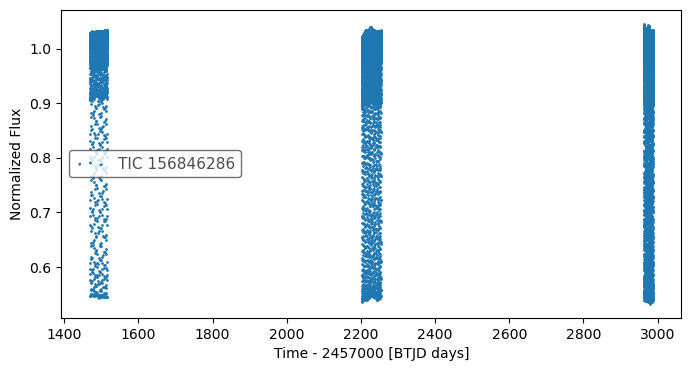

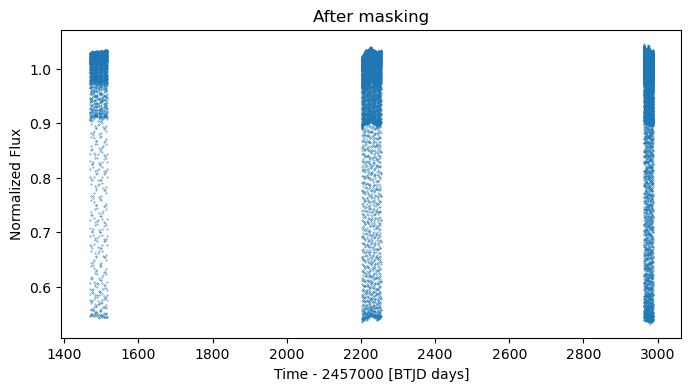

In [5]:
%matplotlib inline
# %matplotlib widget

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

# mask out data you don't like...

fig, ax = plt.subplots(figsize=figsize)
search_result.scatter(ax = ax)

# mask = time < 0 #( time > 54950) & (time < 54963)  #  truncate weird spikes at the beginning of Kepler data  
mask = time < 0   # no-op mask

time = time[~mask]
flux = flux[~mask]
fluxerr = fluxerr[~mask]

# make sure that therte are no nans!

finite_mask = np.isfinite(time) * np.isfinite(flux) * np.isfinite(fluxerr)

# make a dictionary of the data 

data = pd.DataFrame({'time': time[finite_mask], 'flux': flux[finite_mask], 'err': fluxerr[finite_mask]})

ax2 = plt.figure(figsize=figsize).gca()
ax2.scatter(data.time, data.flux, s=0.1);
ax2.set_ylabel(ax.get_ylabel())
ax2.set_xlabel(ax.get_xlabel())
ax2.set_title("After masking");

In [6]:
do_bls = False

if do_bls:
    if not "../.." in sys.path:
        sys.path.append("../..")
    import lightkurve_ext_pg_runner as lke_pg_runner  # at ../../

    bls_result = lke_pg_runner.run_bls(
        search_result.remove_nans(),
        pg_kwargs=dict(
            minimum_period=1, maximum_period=20,
            frequency_factor=1,            
            duration=[3.4957 / 24 * f for f in [0.975, 1, 1.025, 1.05, 1.1, 1.15,]],  # based on observed primary eclipse duration for better fit
        ),
    )
    !$NOTIFY_CMD  "BLS Done"

In [7]:
# Visaully compare different candidate period

# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418132651611877).truncate(-0.1, 0.1).scatter(label="BLS period, frequency_factor=10");  # HWHM 0.001571020094789155
# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418147).truncate(-0.1, 0.1).scatter(label="s0001-s0009:TCE1");

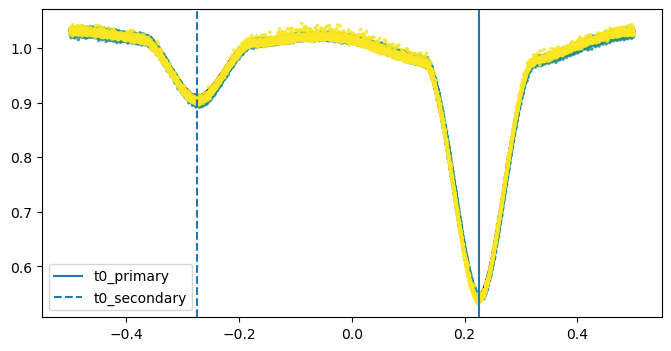

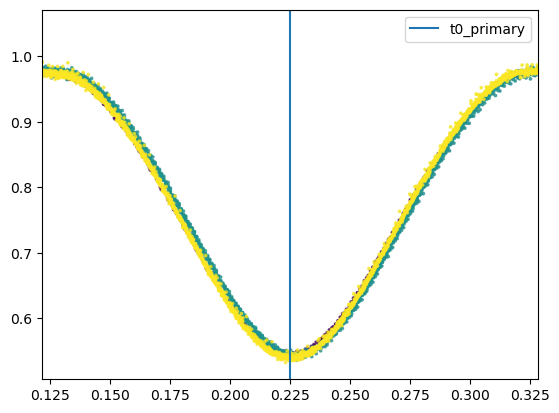

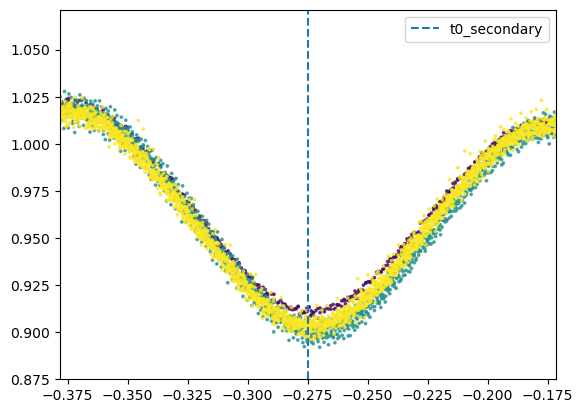

In [9]:
%matplotlib inline
# %matplotlib widget

from astropy.time import Time

# define the orbital period and the t0 

# FILL-IN THE eclipse epoch / period, 
# period = 1.0882783   #  from 2015 paper, 94027.2422 / 86400
# period = 1.088287  # manual fit TESS data
# period = 1.0882936  # MCMC on df_primary, P=1.0882936326760682, 1.490371098177063e-08, t0=1468.9678722186736,  std_t0: 7.4376260732755404e-06
#                     # MCMC run 2:         P=1.088293644517335 (basically the same as run 1)
period = 1.088290  # roughly between manual fit and MCMC, it fits better than either MCMC and the initial manual fit above.

# t0_primary = 2963.19  # visual inspection
t0_primary = 1468.9678  # MCMC
t0_secondary = t0_primary + period / 2  # about 2963.734 visually

# convert epoch from BTJD to commonly mjd used here
# t0_primary = Time(t0_primary, format="btjd").to_value("mjd")
# t0_secondary = Time(t0_secondary, format="btjd").to_value("mjd")

# Move t0 to the first dip in the data (some of the subsequent codes, espically fit_each_eclipse(), assumes that)
t0_primary = t0_primary - int((t0_primary - data['time'][0]) / period) * period
if t0_secondary is not None:
    t0_secondary = t0_secondary - int((t0_secondary - data['time'][0]) / period) * period

duration_hr_primary = 4.5
duration_hr_secondary = 4.5

# t0_for_plotting = 0  # keep 0 for plotting purposes
t0_for_plotting = t0_primary - np.abs(t0_primary - t0_secondary) * 0.45  # use a custom one so that the eclipses are not near the edge (-0.5 or +0.5)

phase = etv_functions.phase_data(data['time'], t0_for_plotting, period)

fig, ax = plt.subplots(figsize = (8,4))

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])

# add the phase to the dataframe
data['phase'] = phase

plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
if t0_secondary is not None:
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.legend()
# plt.ylim(0.535, 0.55)
# plt.xlim(-0.5, 0.1)
plt.show();

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
plt.xlim(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.6 * duration_hr_primary / 24/ period, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.6 * duration_hr_primary / 24/ period);
plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.xlim(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.6 * duration_hr_secondary / 24/ period, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.6 * duration_hr_secondary / 24/ period);
plt.legend();
plt.ylim(0.875, None);
plt.show()

### Detrend (optional)

- detrended flux is in `flux_detrended`, and won't be used in subsequent work by default

In [ ]:
# show data to visualize what's changed in each step below
data  

In [ ]:
# phase fold the data and create an appoximate binary model (top) and subtract it from the data (bottom)
#_, _ , flux_sub_binary, model, _, _ = etv_functions.trend_removal_interact(period, 0, data['time'], data['flux'], data['time'], data['flux'])

data = etv_functions.trend_removal_interact(period, t0_for_plotting, data)
data

In [ ]:
# if you want to detrend the data run this line!

data = etv_functions.detrend_suz(data, T_dur = 10, plot = True)
data

In [ ]:
# plot the phase folded data here so that you know at what phase you want to cut the data to model 
fig, ax = plt.subplots(figsize = figsize)
plt.scatter(data.phase, data.flux_detrended, s = 1, label="flux_detrended")
plt.legend()
plt.show()

plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
plt.xlim(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.6 * duration_hr_primary / 24/ period, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.6 * duration_hr_primary / 24/ period);
plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.xlim(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.6 * duration_hr_secondary / 24/ period, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.6 * duration_hr_secondary / 24/ period);
plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

<span style="background-color: rgba(255, 0, 0, 0.6);"> NOTE: </span> The zoom windows below for the eclipses are made **smaller**, an attempt to reduce the complications of EW variability outside the minima (and some assymetery)

### Now that the data is ready we can start 

In [37]:
# define the midpoints of the primary and secondary eclipses and the window width

# if these don't look central - change them!! the eclipses should be central
midpoint_p =  etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0]  # convet to time in phase
# midpoint_p -= 0.004  # the offset is added back to t0_primary (& secondary above
print('Primary:  ', t0_primary, midpoint_p)

# change depending on the width of the eclipses, default to be slightly larger than the primary eclipse
window_width_p = 0.8 * duration_hr_primary / 24 / period   # it seems to be difficult to bit model the flat bottom and the curves outside, focus on the overall shape for now
# use a shoter duration to avoid fitting the out-of-eclipse LC, which has its own variability that the model is not equipped to hanlde
# window_width_p = 0.095
print("window_width_p (phase):", window_width_p)

data_primary = data[(data['phase'] > midpoint_p - window_width_p / 2) & (data['phase'] < midpoint_p + window_width_p / 2) ]
ph_binned,flux_binned,err_binned = etv_functions.run_binning_phased(data_primary.phase, data_primary.flux, yerr=data_primary.err,nbins=1000)


if t0_secondary is not None:
    midpoint_s =  etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0]
    print('Secondary:', t0_secondary, midpoint_s)

    # the coshgauss model seems problematic, try to use a larger width to give it more shape to fit
    window_width_s = 0.8 * duration_hr_secondary / 24 / period  
    # window_width_s = 0.22
    print("window_width_s (phase):", window_width_s)
    
    data_secondary = data[(data['phase'] > midpoint_s - window_width_s / 2) & (data['phase'] < midpoint_s + window_width_s / 2) ]
    ph_binned_s,flux_binned_s,err_binned_s = etv_functions.run_binning_phased(data_secondary.phase, data_secondary.flux, yerr=data_secondary.err,nbins=1000)


### # you need initial guesses!! The order is :
# alpha0, alpha1, t0, d, Tau - CHANGE THESE TO YOUR OWN INITIAL GUESSES
# median flux, -eclipse depth, t0, related to duration, related to shape (U or V) 
# t0 in normalixed phase
start_vals = [0.980, -0.437, midpoint_p, 0.044, 0.924]
start_vals_s = [0.999, -0.095, midpoint_s, 0.041, 0.98]
    
# -- -- -- -- -- -- -- -- --
# etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *start_vals)
etv_functions.plot_initial_guess_interactive(data_primary, ph_binned, flux_binned, err_binned, "midpoint_p", *start_vals)
if t0_secondary is not None:
    # etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *start_vals_s)
    etv_functions.plot_initial_guess_interactive(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, "midpoint_s", *start_vals_s)

print("Start params for  fitting period with MCMC on df_primary:")
print(f"[{start_vals[0]}, {start_vals[1]}, {t0_primary}, {start_vals[3]}, {start_vals[4]}, {period}],");

Primary:   1468.96783 0.2232964099641468
window_width_p (phase): 0.13783090904078876
Secondary: 1468.4278050000003 -0.2729178344006703
window_width_s (phase): 0.13783090904078876


Output(layout=Layout(padding='1em 0px'))

Output(layout=Layout(padding='1em'))

Output(layout=Layout(padding='1em 0px'))

Output(layout=Layout(padding='1em'))

Start params for  fitting period with MCMC on df_primary:
[0.98, -0.437, 1468.96783, 0.044, 0.924, 1.08829],


In [ ]:
if False: 
    # Export the data around primary eclipses, for period analysis outside of notebook
    data_primary[["time", "flux", "err"]].to_csv(f"tmp/data_primary_{ticid}.csv", index=False)

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 1000/1000 [01:25<00:00, 11.70it/s]


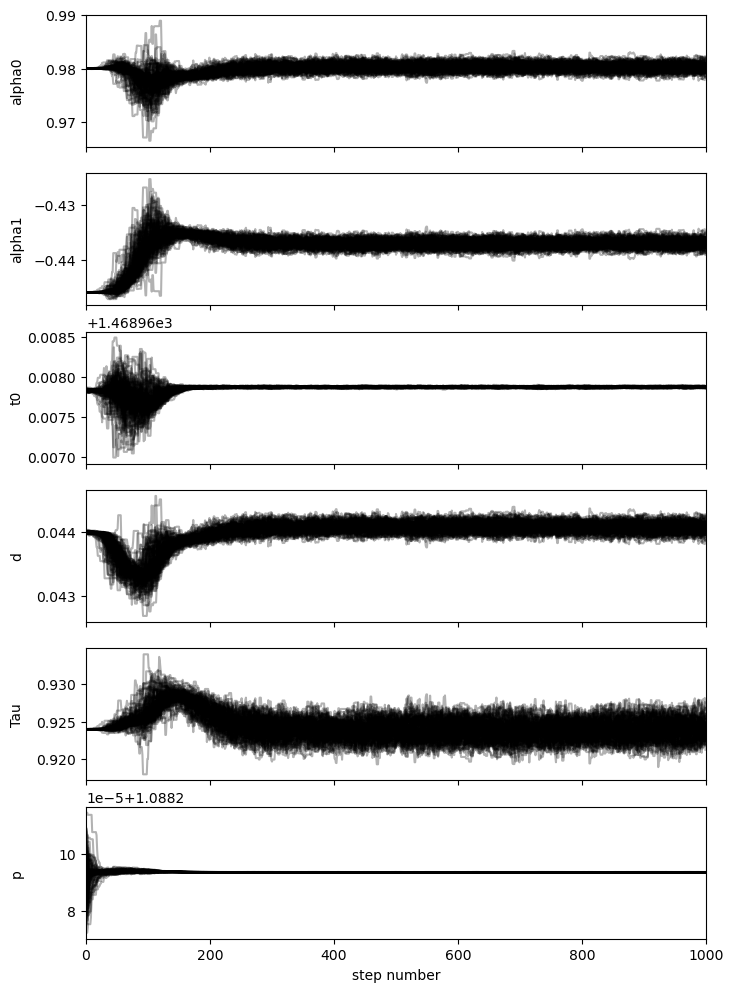

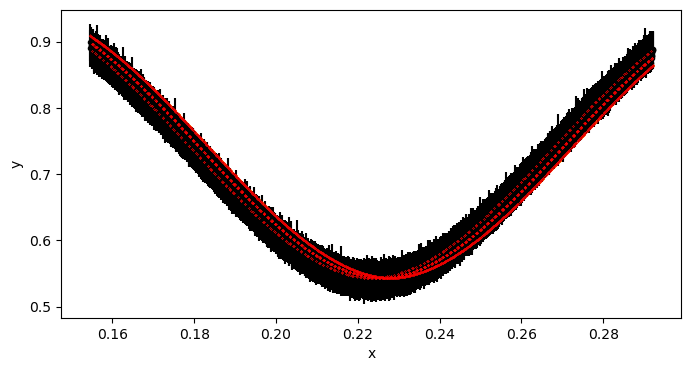

mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = 0.9803431143584229, -0.4370648827210015, 1468.9678728032713, 0.04408833344209795, 0.9238459936852124, 1.088293644517335
std_p: 1.4257840793258906e-08 ; std_t0: 7.316144802793888e-06


In [36]:
# use MCMC to refine the period

use_mcmc_to_fit_period = True


if use_mcmc_to_fit_period:
    import etv_functions_with_period as etvp

    etv_functions.enable_info_log_for_jupyter()

    # MCMC result
    mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p, fit_params_p_stats = etvp.run_mcmc_initial_fit_p(
        data_primary[:],
        # [0.999, -0.46, 1468.971949, 0.045, 0.93, 1.088287],  # 1st run, the period is visually unsatisfactory 
        [0.98, -0.446, 1468.96783, 0.044, 0.924, 1.08829],  # 2nd run
        # nruns=20, discard=1, # for a sanity test,  to ensure the initial guess is not way off.
        nruns=1000, discard=600,
        pool=-2,
        plot_chains=True,
        plot=True,
        also_return_stats=True,
    )
    print("mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p]]))
    print("std_p:", fit_params_p_stats["std_p"], "; std_t0:", fit_params_p_stats['std_t0'])
    !$NOTIFY_CMD "Fitting period done."

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 1000/1000 [00:57<00:00, 17.47it/s]


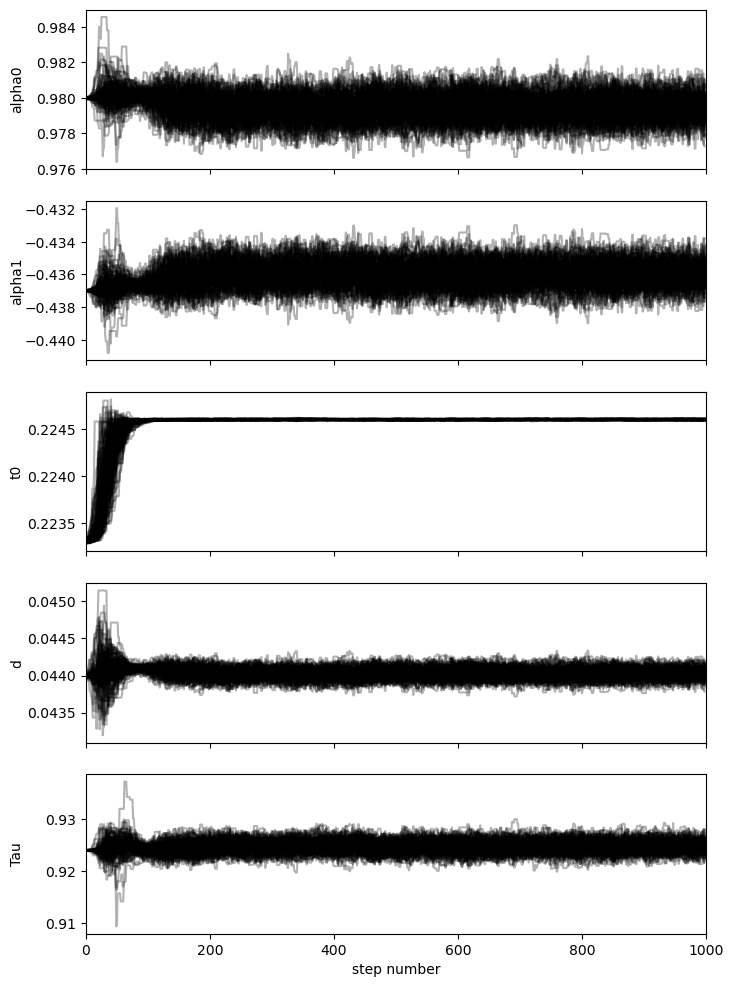

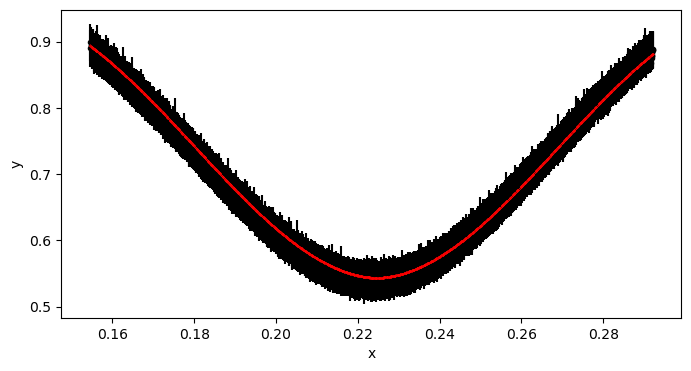

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 1000/1000 [00:59<00:00, 16.91it/s]


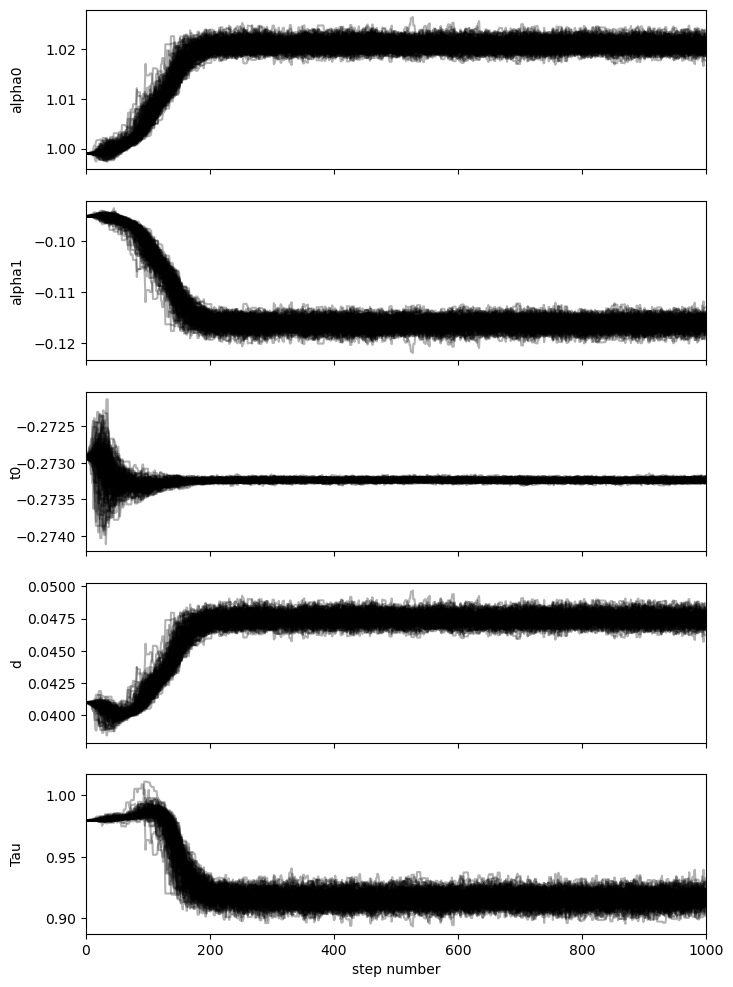

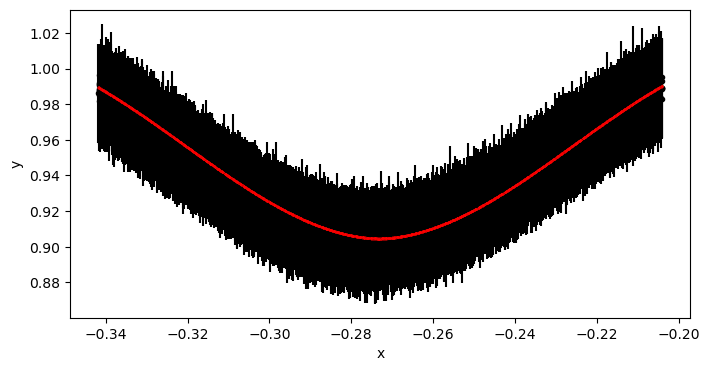

In [38]:
# run the initial model fit using MCMC for the primary and secondary eclipses 
run_init_fit = True

if run_init_fit:
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = etv_functions.run_mcmc_initial_fit(data_primary, start_vals, nruns = 1000, pool=-2, plot_chains = True, plot = True)
    if t0_secondary is not None:
        mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = etv_functions.run_mcmc_initial_fit(data_secondary, start_vals_s, nruns = 1000, pool=-2, plot_chains = True, plot = True)
    !$NOTIFY_CMD "Initial fit done"

In [ ]:
if not run_init_fit:  # case init fit has been previously saved and to be reussed
    print("Use pre-defined inital model params:")
    # # initial fit params from TESS data

    # fit params from TESS data, with period manually set for best fit in TESS data
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 0.9794580282074297, -0.4360006409511223, 0.22460202949935407, 0.04402514492525912, 0.9246988511157113
    mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.0207512538282895, -0.11614878137316131, -0.2732369731003552, 0.04747011581510649, 0.9161873624046053
    
    etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *[mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau])
    etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *[mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s])    

In [39]:
print("Initial model params:")  # For information, and they can be copied to the cell above for future reuse

print("mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau]]))
if t0_secondary is not None:
    print("mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = " + ", ".join([str(v) for v in [mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s]]))

Initial model params:
mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 0.9794580282074297, -0.4360006409511223, 0.22460202949935407, 0.04402514492525912, 0.9246988511157113
mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.0207512538282895, -0.11614878137316131, -0.2732369731003552, 0.04747011581510649, 0.9161873624046053


1396

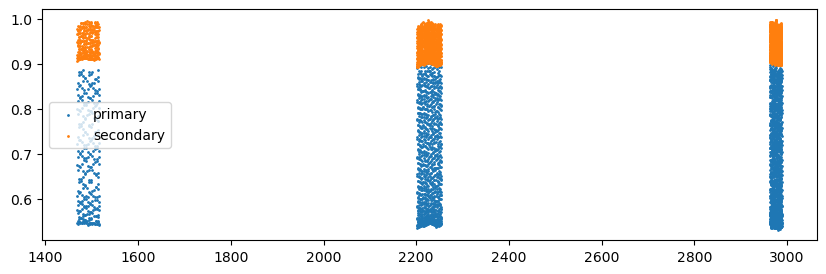

In [40]:
fig = plt.subplots(figsize=(10, 3), sharex=True)
plt.scatter(data_primary.time,data_primary.flux , s = 1, label = 'primary')
if t0_secondary is not None:
    plt.scatter(data_secondary.time,data_secondary.flux , s = 1, label = 'secondary')
plt.legend()

# calculate the number of transits there are within the data 
n_transits = int((max(data_primary.time) - min(data_primary.time)) / period)
n_transits

1468.96783 1.08829 1468.96783


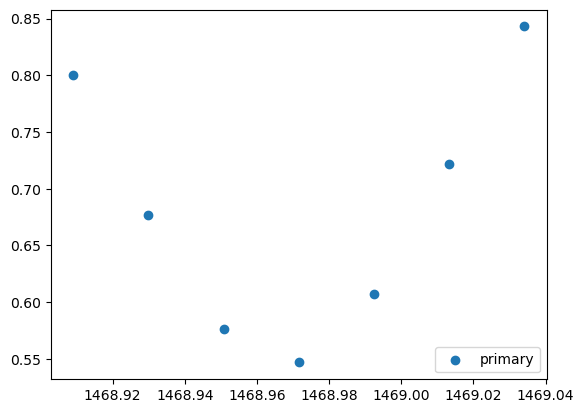

1468.96783 1.08829 1470.05612


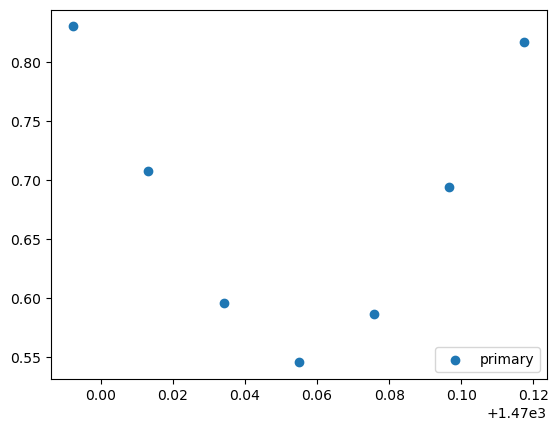

1468.96783 1.08829 1471.14441


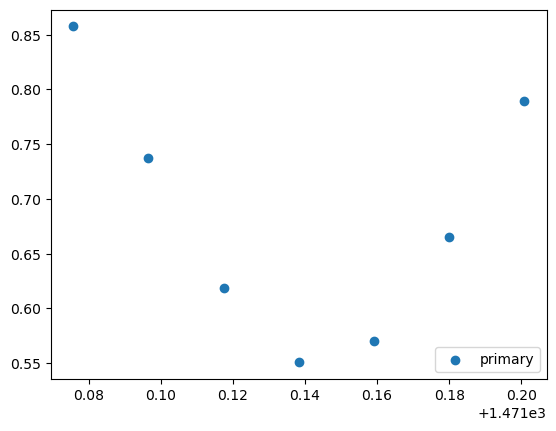

1468.4278050000003 1.08829 1468.4278050000003


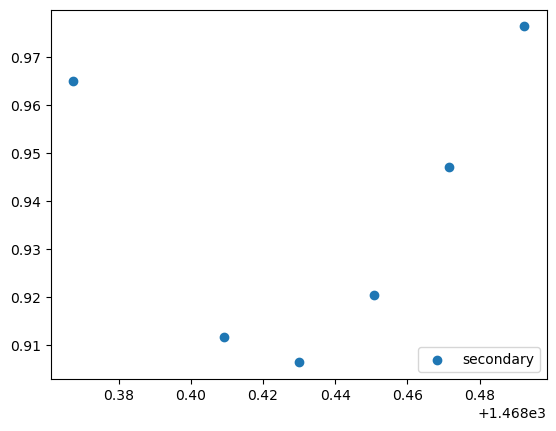

1468.4278050000003 1.08829 1469.5160950000002


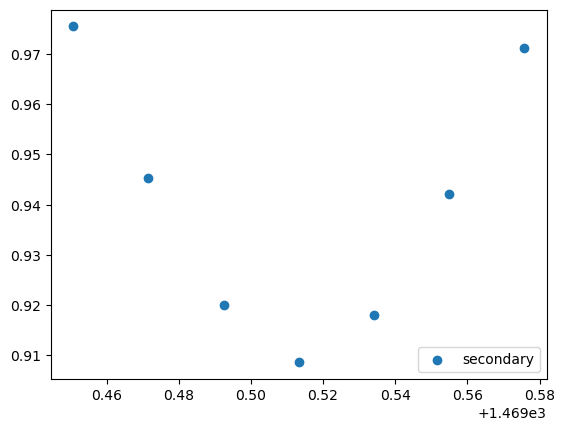

1468.4278050000003 1.08829 1470.6043850000003


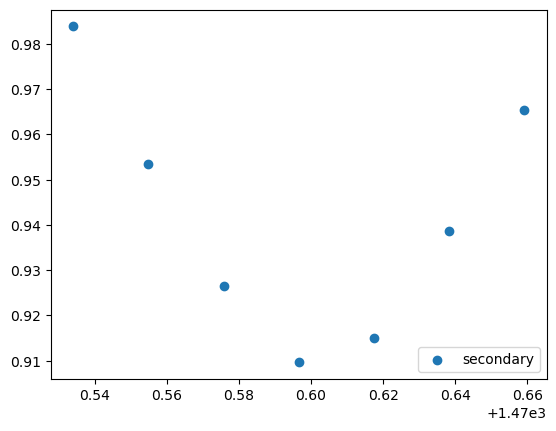

In [41]:
tr_index = range(0,n_transits)

for i in tr_index[0:3]:        
    transit_time = t0_primary+(period*i)
    x = np.array(data_primary.time)
    y = np.array(data_primary.flux) 
    yerr = np.array(data_primary.err)
    
    print (t0_primary, period, transit_time)
    
    mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
    
    x = np.array(x[mask])
    y = np.array(y[mask]) 
    yerr = np.array(yerr[mask])
    fig, ax = plt.subplots()
    plt.scatter(x,y, label="primary")
    plt.legend(loc="lower right")
    plt.show()
    

if t0_secondary is not None:
    for i in tr_index[0:3]:        
        transit_time = t0_secondary+(period*i)
        x = np.array(data_secondary.time)
        y = np.array(data_secondary.flux) 
        yerr = np.array(data_secondary.err)
        
        print (t0_secondary, period, transit_time)
        
        mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
        
        x = np.array(x[mask])
        y = np.array(y[mask]) 
        yerr = np.array(yerr[mask])
        fig, ax = plt.subplots()
        plt.scatter(x,y, label="secondary")
        plt.legend(loc="lower right")
        plt.show()

### Fit individual eclipses

In [49]:
# Provide a warning if the expected number of data points per clipped LC is smaller than the default minimum `min_number_data` (20)
longest_cadence = np.max(sr.exptime)
est_number_data_primary   = int(window_width_p * period * 24 / longest_cadence.to(u.hr).value)
print(f"Expected num of data points of a clipped LC in longest cadence ({longest_cadence}) (primary)  : {est_number_data_primary}")
if est_number_data_primary < 20:
    display(HTML("<span style='background-color: rgba(255, 0, 0, 0.7); padding-left: 1ch; padding-right: 1ch;'>WARN:</span> num of data points for a clipped LC (primary) < 20"))
if t0_secondary is not None:
    est_number_data_secondary = int(window_width_s * period * 24 / longest_cadence.to(u.hr).value)
    print(f"Expected num of data points of a clipped LC in longest cadence ({longest_cadence}) (secondary): {est_number_data_secondary}")
    if est_number_data_secondary < 20:
        display(HTML("<span style='background-color: rgba(255, 0, 0, 0.7); padding-left: 1ch; padding-right: 1ch;'>WARN:</span> num of data points for a clipped LC (secondary) < 20"))

Expected num of data points of a clipped LC in longest cadence (1800.0 s) (primary)  : 7


Expected num of data points of a clipped LC in longest cadence (1800.0 s) (secondary): 7


Fitting individual primary eclipses...
Creating new manifest file
1468.96783 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 419.09it/s]


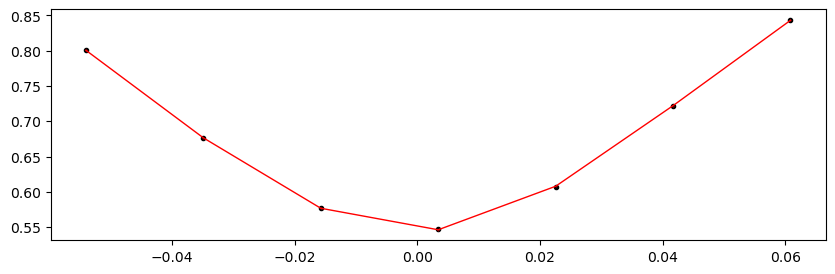

1470.05612 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 434.45it/s]


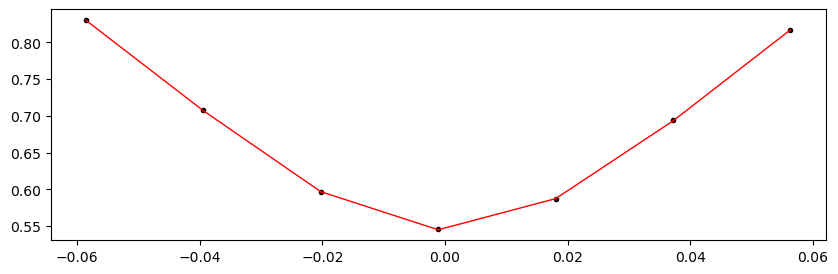

1471.14441 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 421.61it/s]


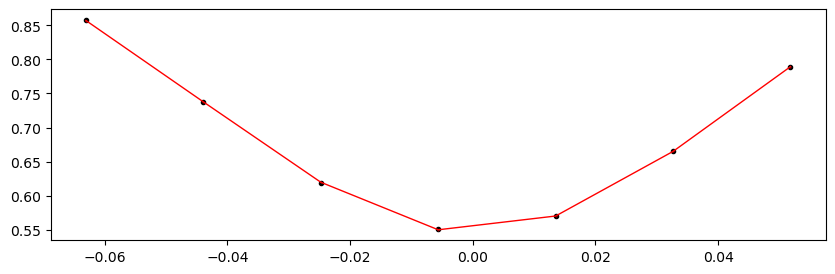

1472.2327 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 408.67it/s]


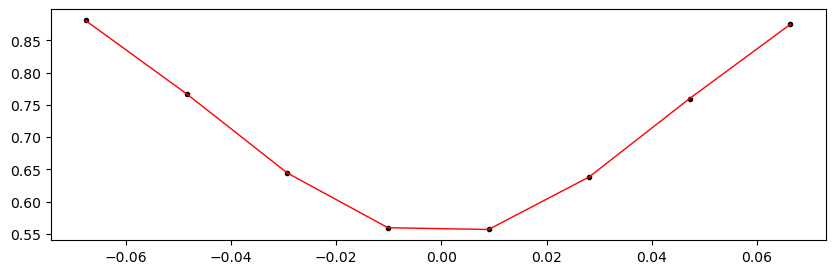

1473.32099 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 259.13it/s]


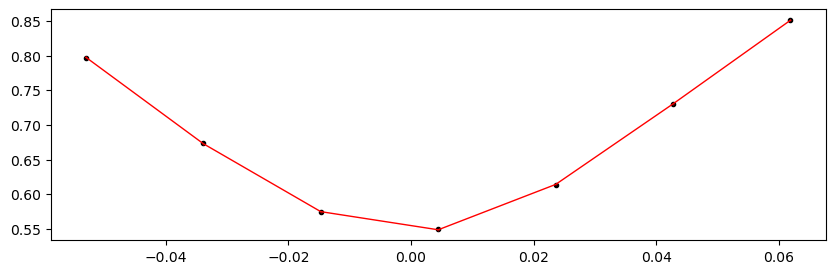

1474.40928 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 427.07it/s]


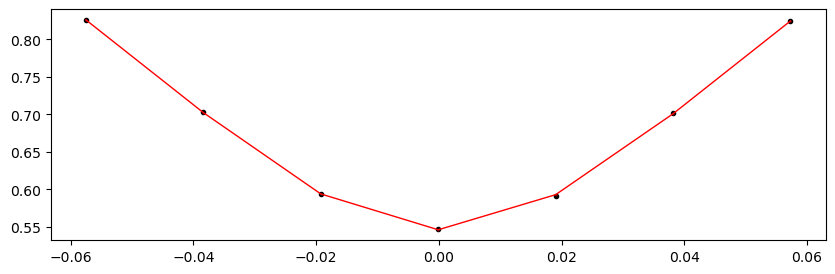

1475.49757 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 430.97it/s]


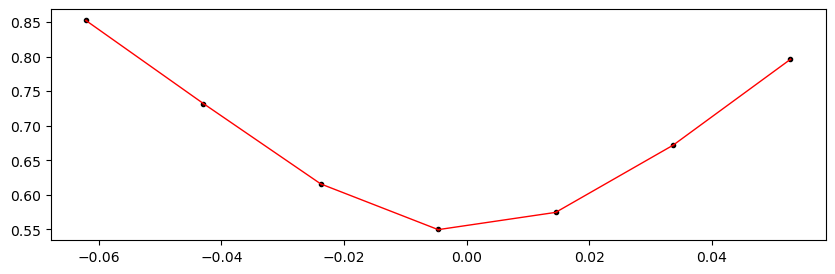

1476.5858600000001 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 431.72it/s]


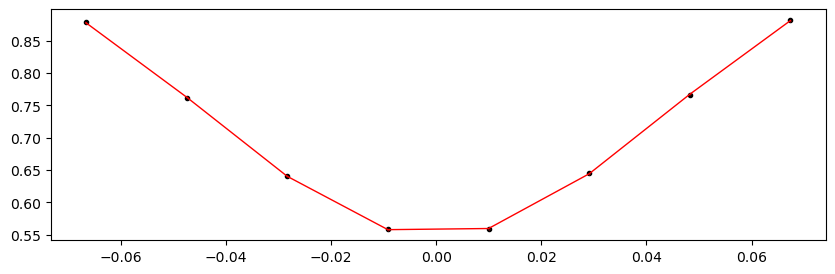

1478.76244 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 426.46it/s]


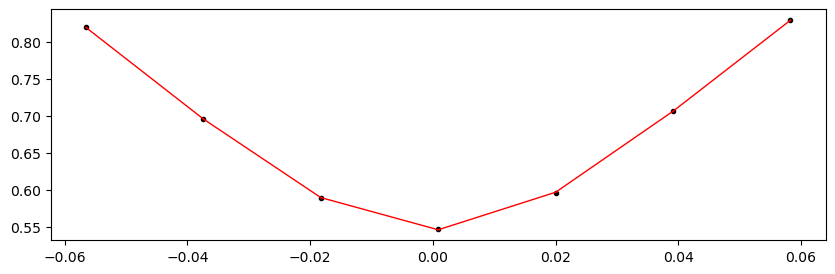

1479.85073 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 427.45it/s]


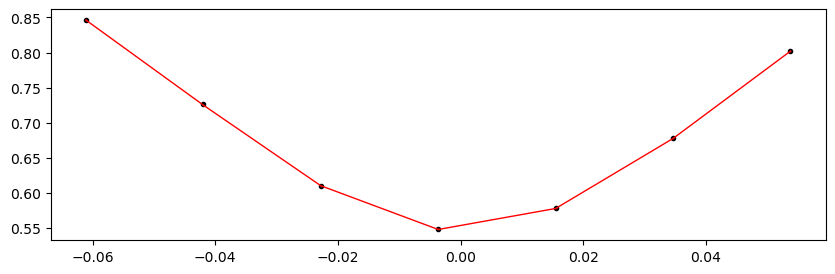

1480.93902 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 427.98it/s]


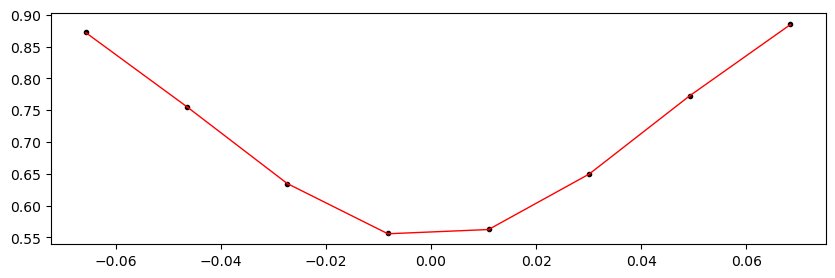

1482.02731 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 431.32it/s]


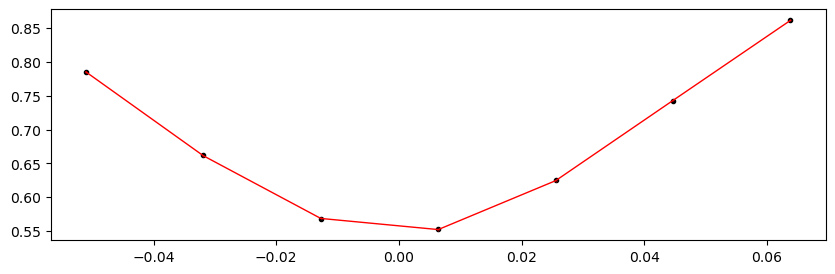

1483.1156 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 439.43it/s]


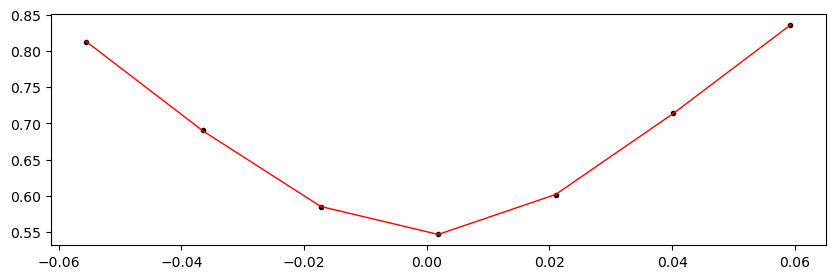

1484.20389 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 438.63it/s]


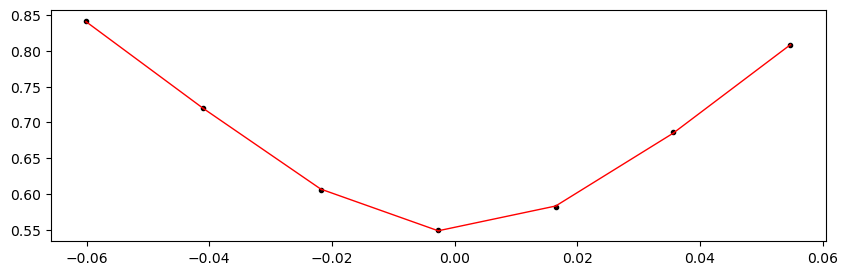

1485.2921800000001 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 437.58it/s]


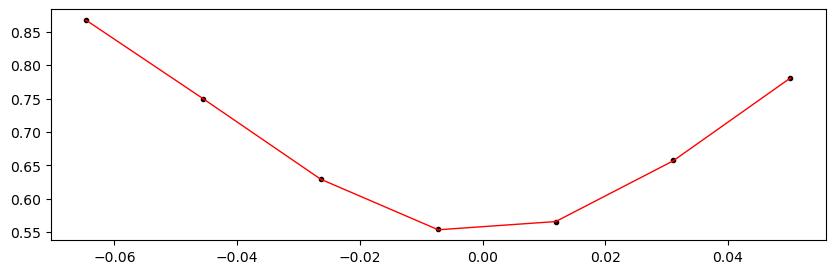

1486.38047 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 440.95it/s]


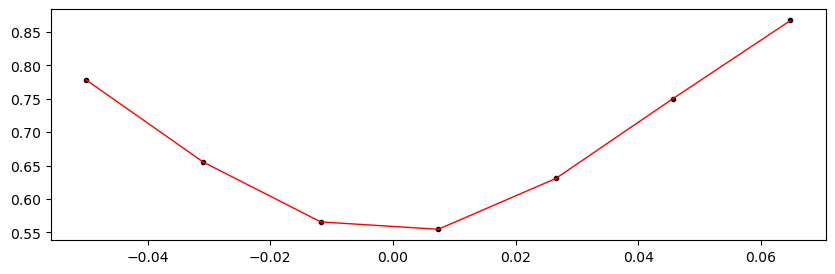

1487.46876 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 433.81it/s]


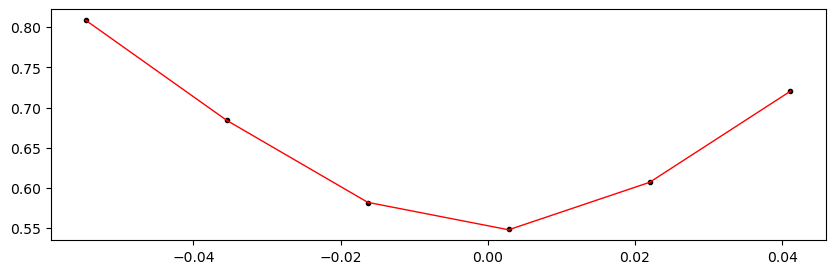

1488.5570500000001 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 438.29it/s]


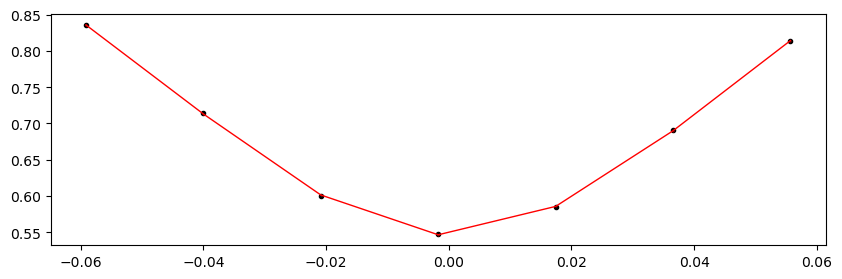

1489.64534 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 439.16it/s]


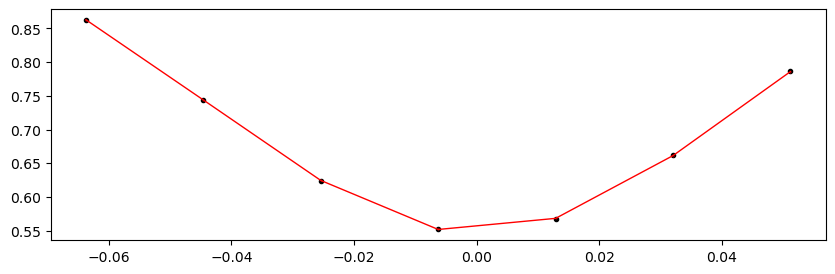

1491.82192 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 441.79it/s]


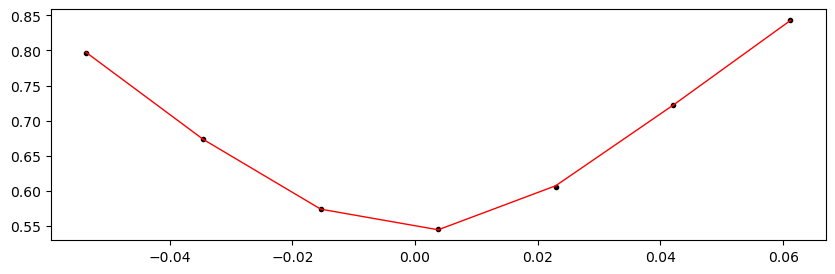

1492.91021 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 440.38it/s]


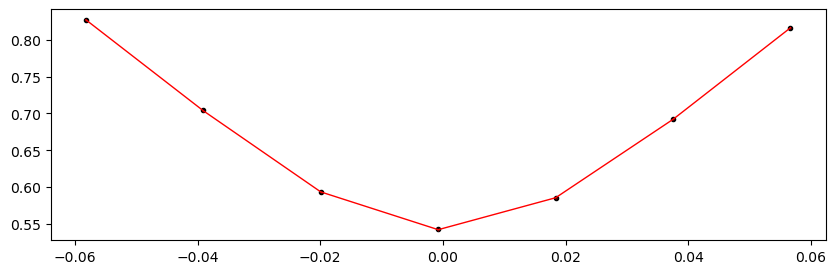

1493.9985000000001 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 392.56it/s]


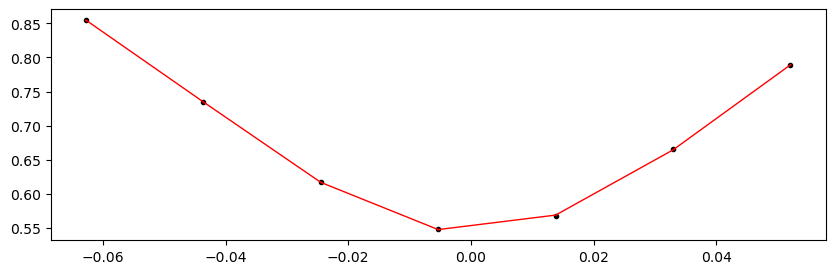

1495.08679 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 439.41it/s]


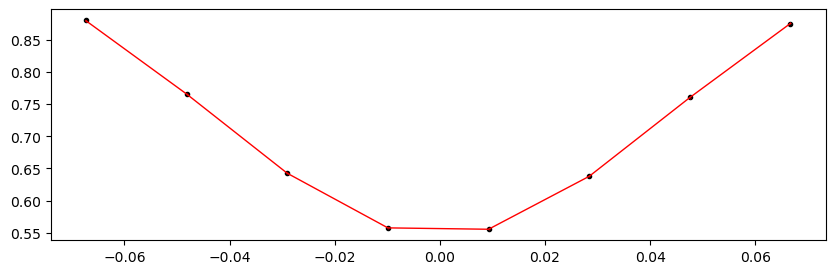

1496.17508 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 432.04it/s]


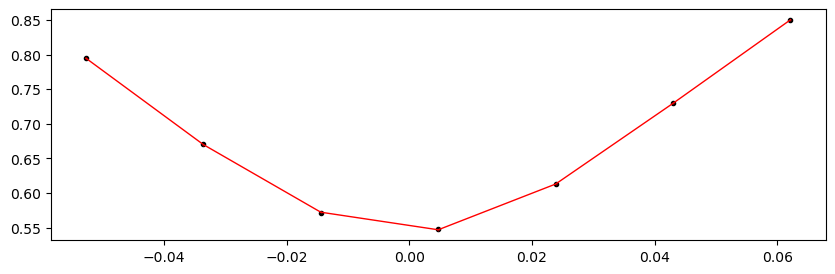

1497.2633700000001 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 432.54it/s]


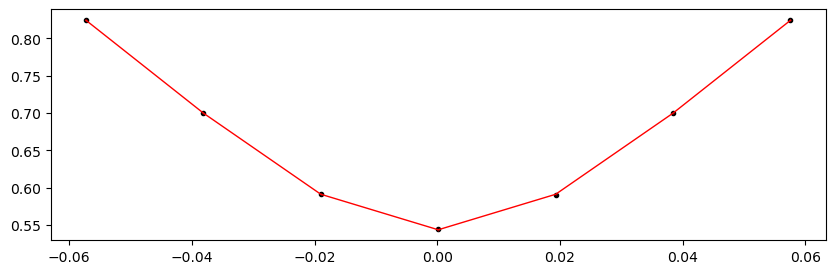

1498.35166 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 439.96it/s]


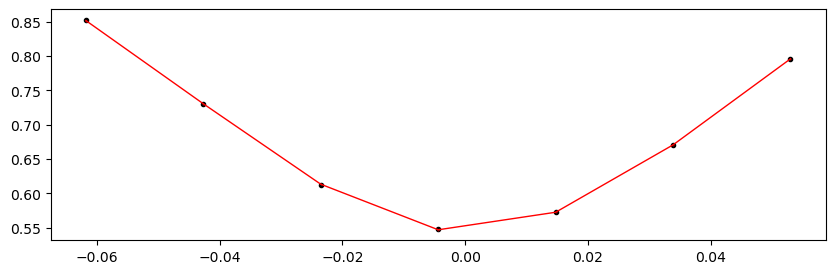

1499.43995 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 441.67it/s]


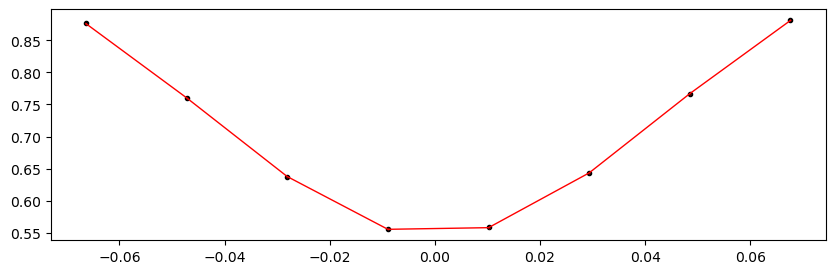

1500.52824 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 426.22it/s]


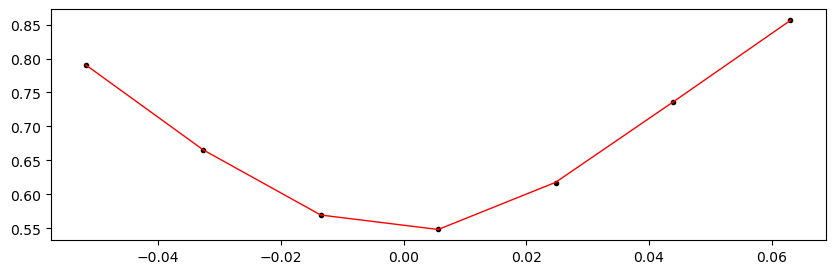

1501.61653 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 439.96it/s]


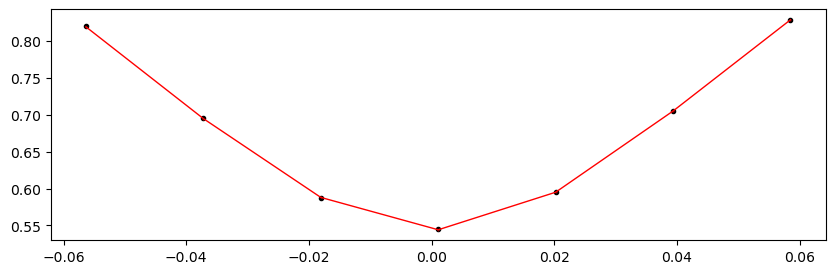

1502.7048200000002 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 434.93it/s]


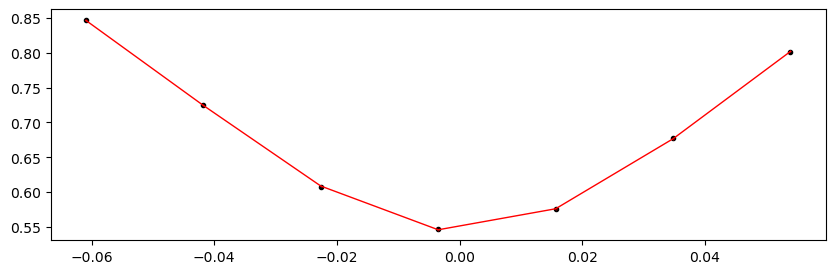

1504.8814 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 439.69it/s]


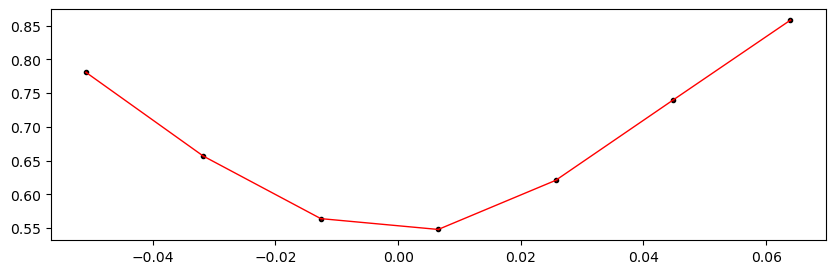

1505.9696900000001 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 414.53it/s]


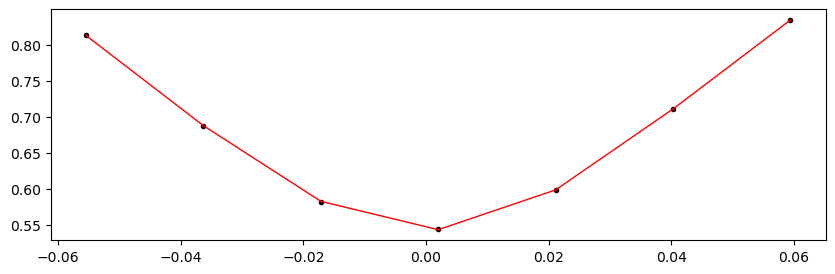

1507.05798 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 423.97it/s]


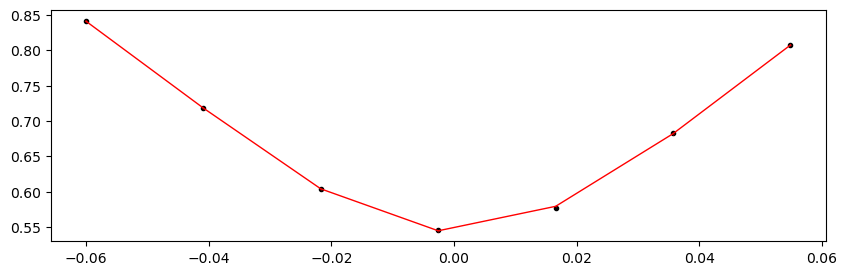

1508.14627 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 428.63it/s]


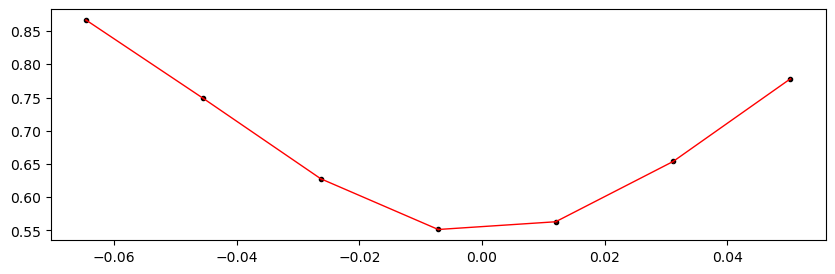

1509.23456 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 436.55it/s]


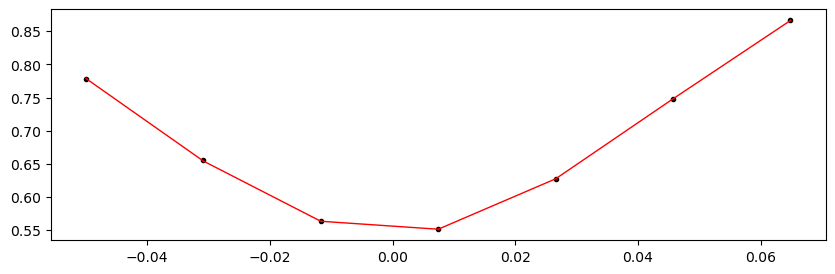

1510.32285 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 441.58it/s]


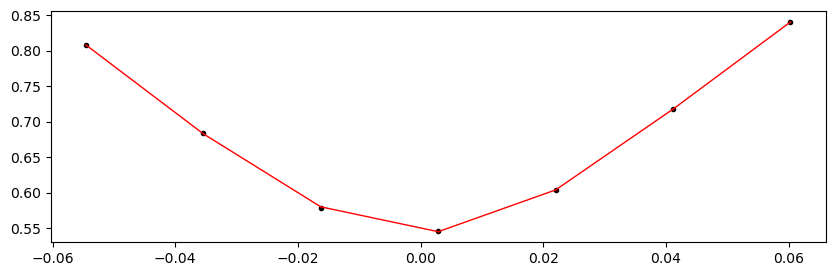

1511.4111400000002 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 432.83it/s]


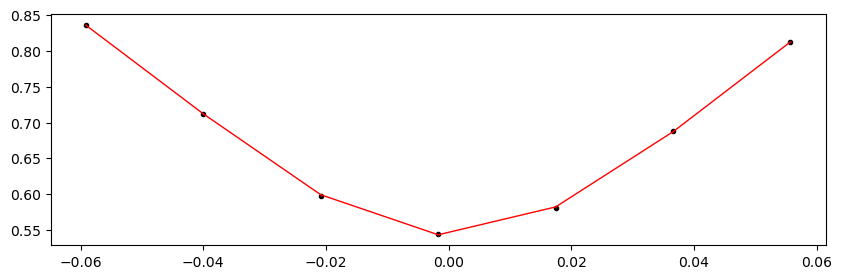

1512.49943 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 436.52it/s]


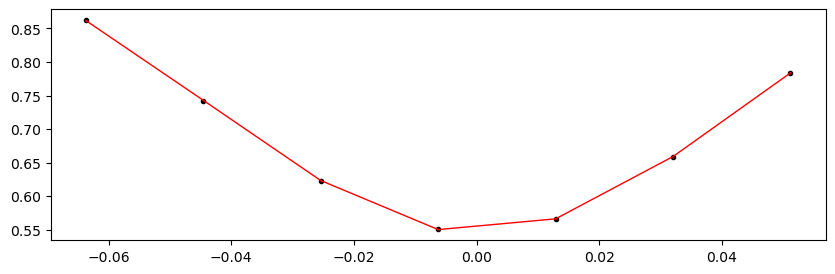

1513.58772 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 436.70it/s]


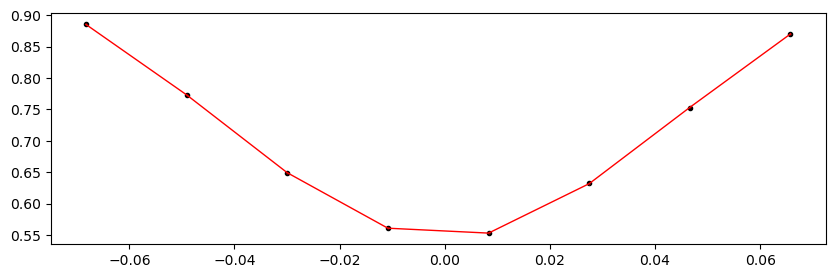

1514.6760100000001 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 438.66it/s]


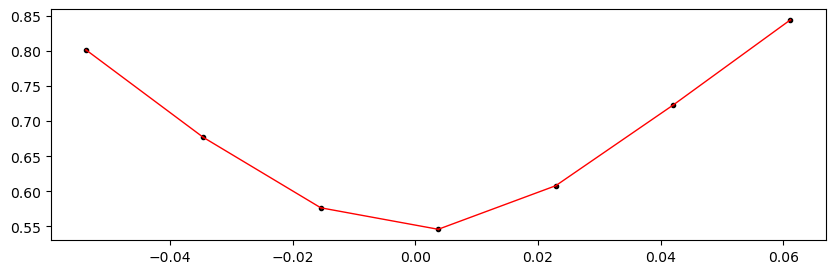

1515.7643 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 423.69it/s]


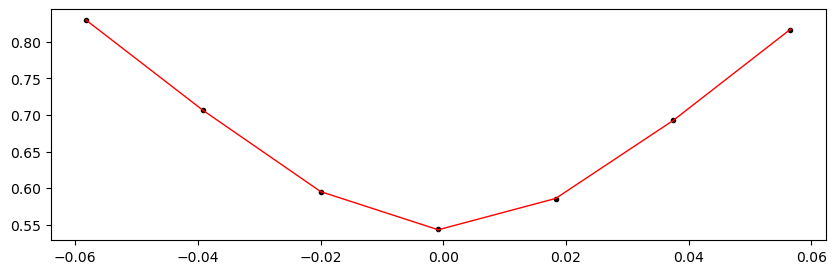

2202.4752900000003 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 422.24it/s]


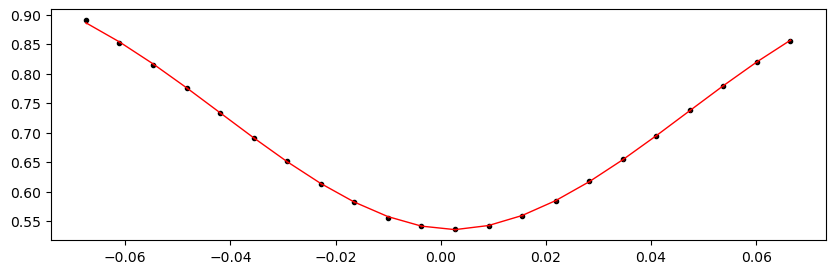

2203.56358 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 425.52it/s]


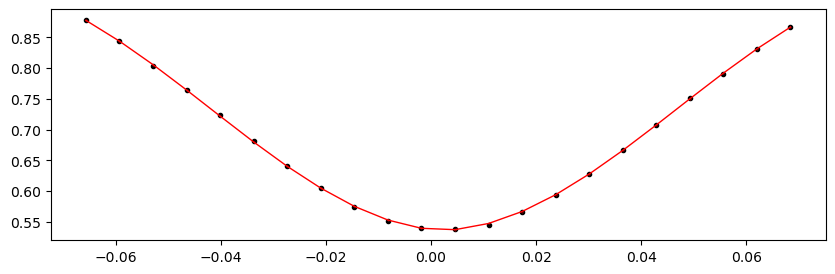

2204.65187 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.07it/s]


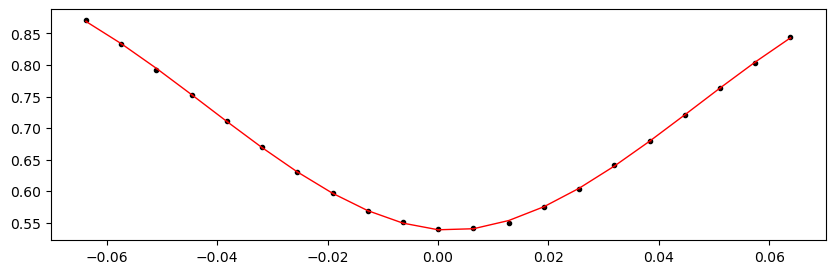

2205.7401600000003 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 419.12it/s]


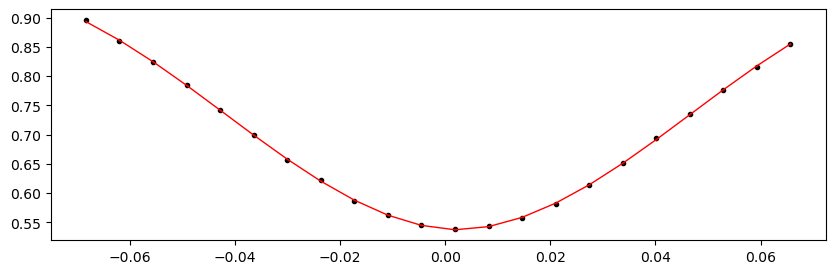

2206.82845 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 419.55it/s]


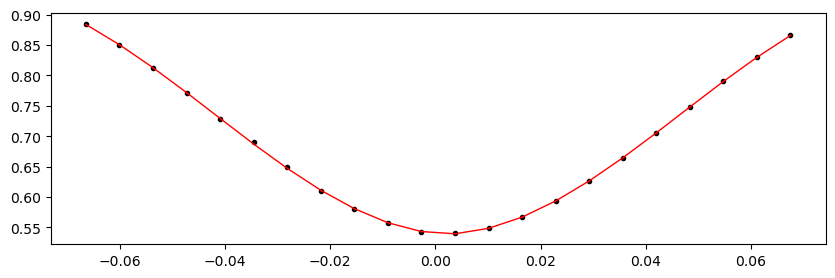

2207.91674 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 422.63it/s]


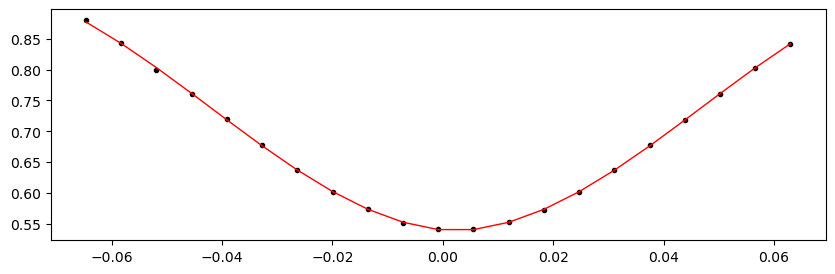

2209.0050300000003 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 425.92it/s]


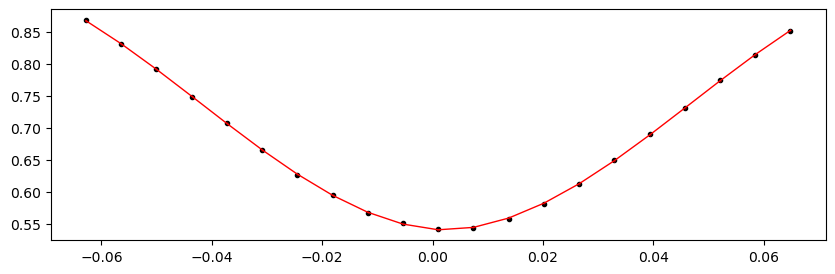

2210.09332 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 422.49it/s]


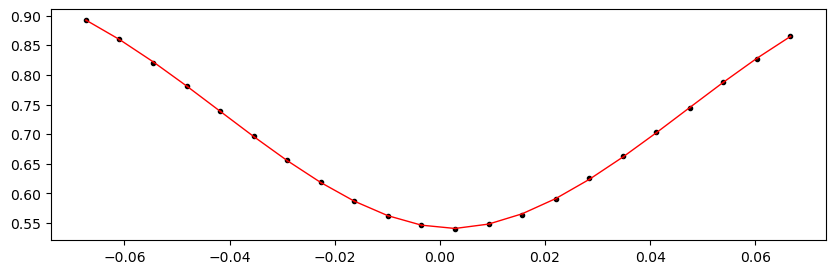

2211.18161 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 420.69it/s]


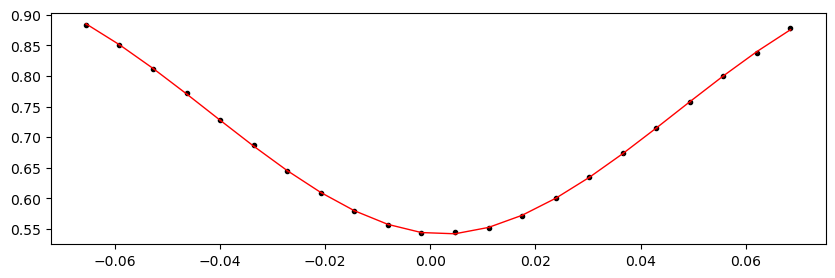

2212.2699000000002 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 409.48it/s]


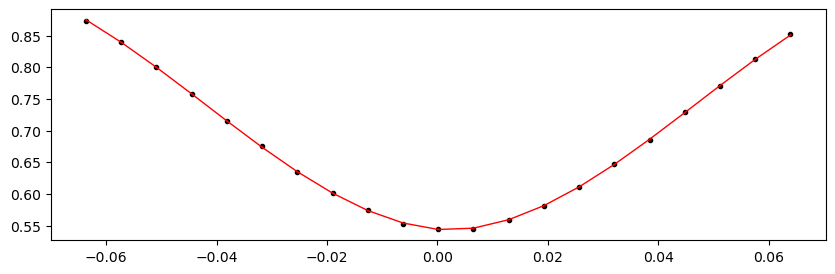

2213.35819 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 421.66it/s]


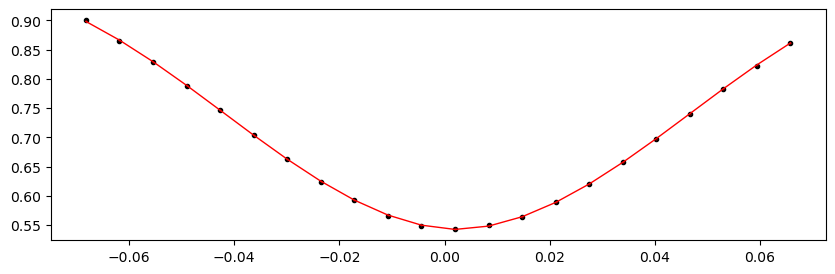

2215.53477 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.73it/s]


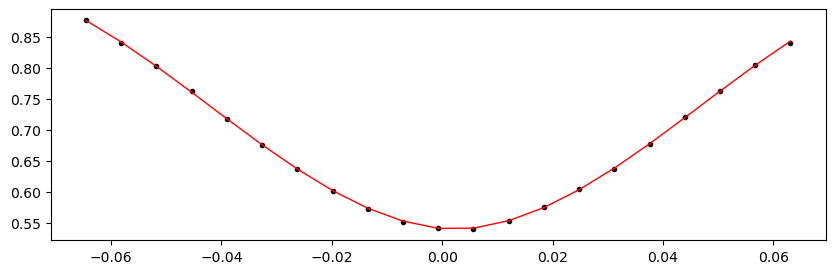

2216.62306 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.96it/s]


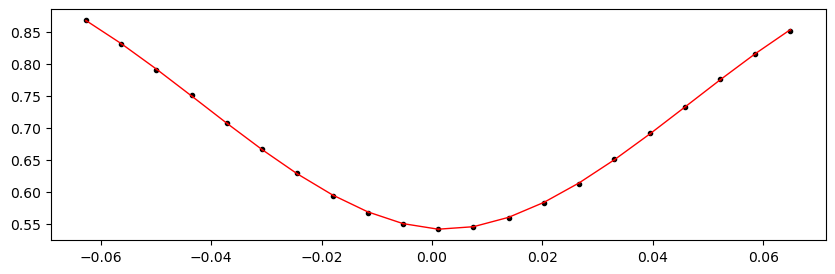

2217.71135 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.11it/s]


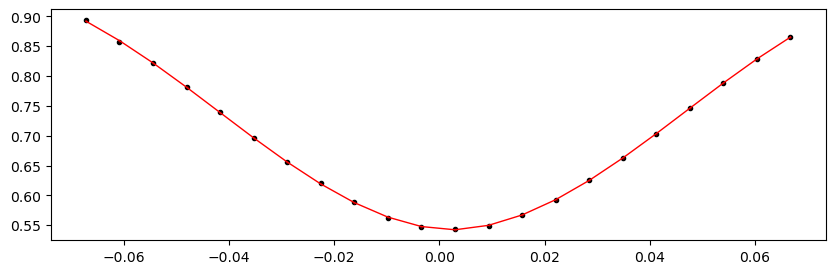

2218.79964 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 416.21it/s]


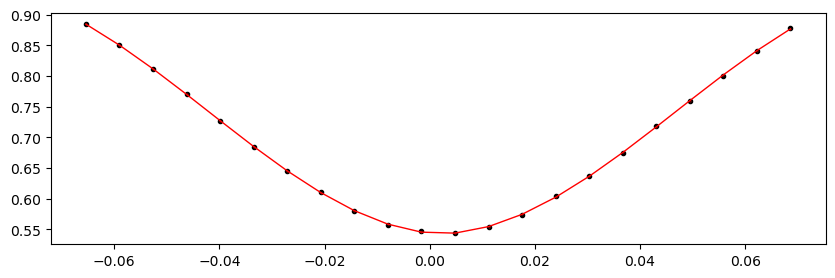

2219.88793 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.85it/s]


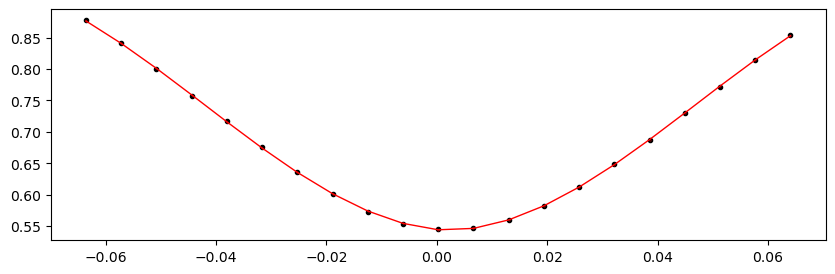

2220.97622 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.04it/s]


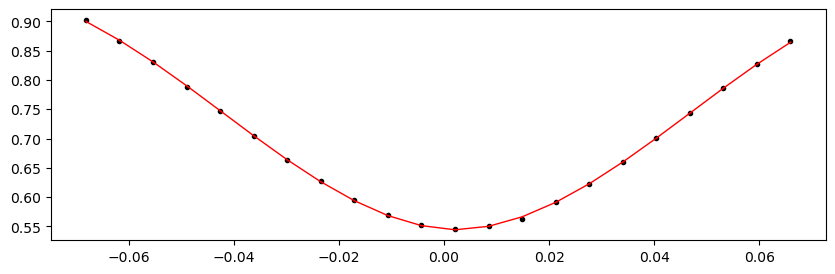

2222.06451 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 424.22it/s]


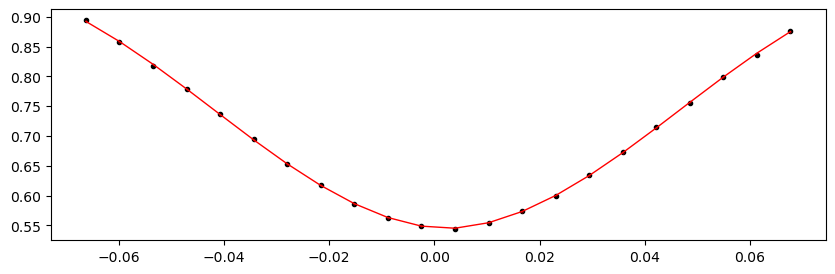

2223.1528 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 421.24it/s]


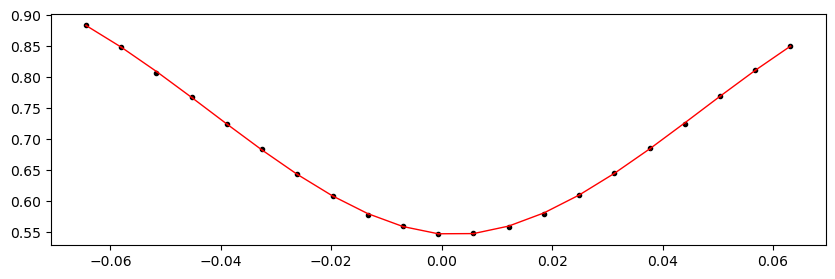

2224.24109 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 419.43it/s]


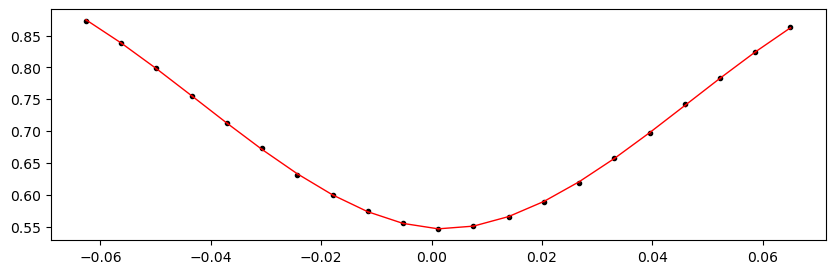

2225.32938 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 425.12it/s]


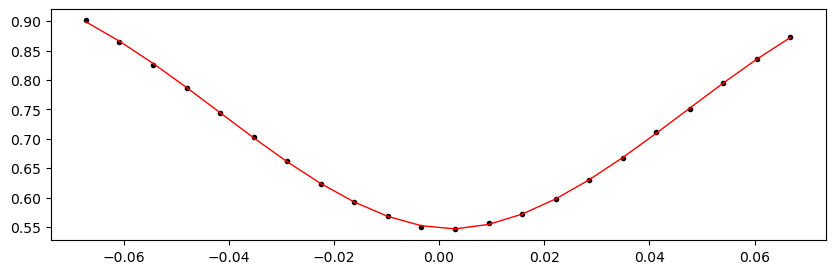

2226.41767 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 425.84it/s]


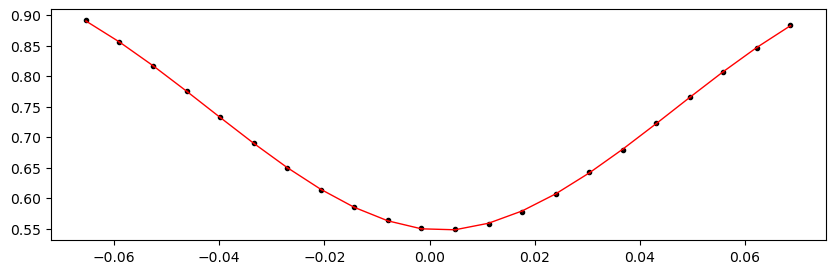

2227.50596 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 421.69it/s]


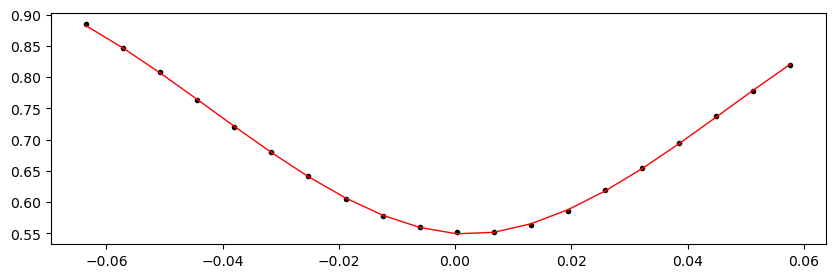

2229.68254 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 419.90it/s]


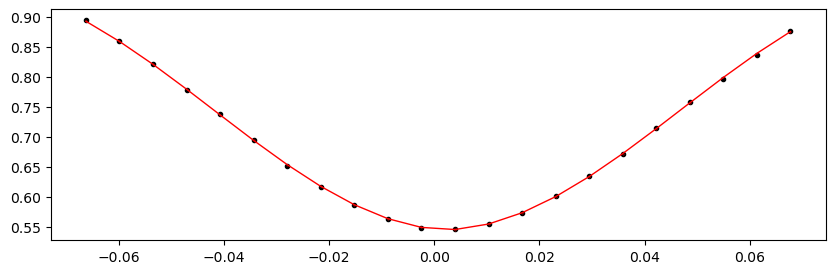

2230.77083 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.33it/s]


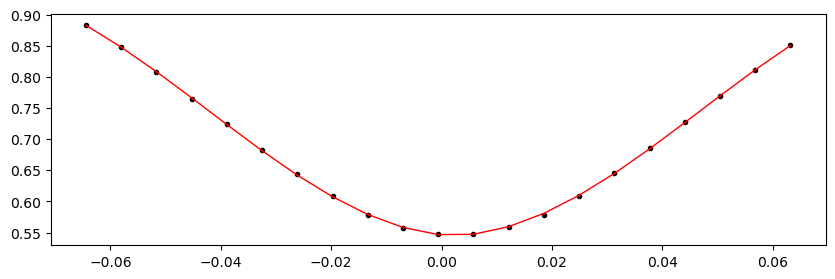

2231.85912 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 419.09it/s]


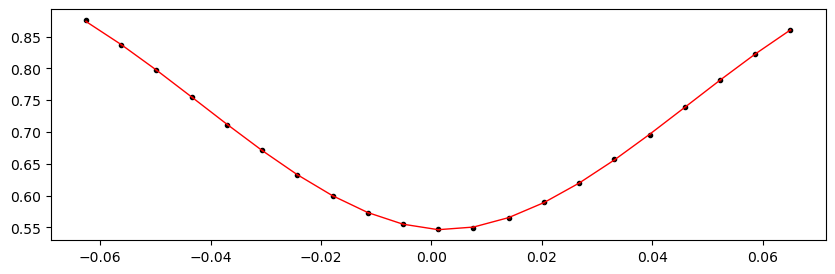

2232.9474099999998 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.44it/s]


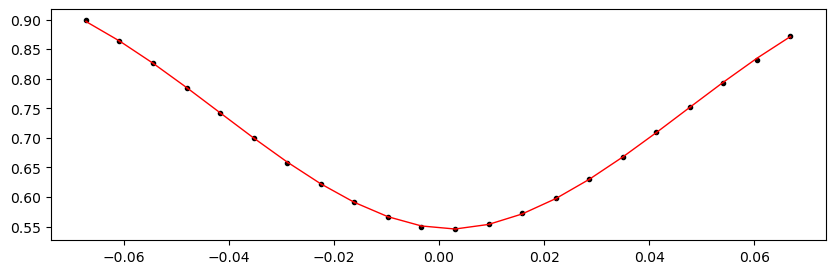

2234.0357 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 423.80it/s]


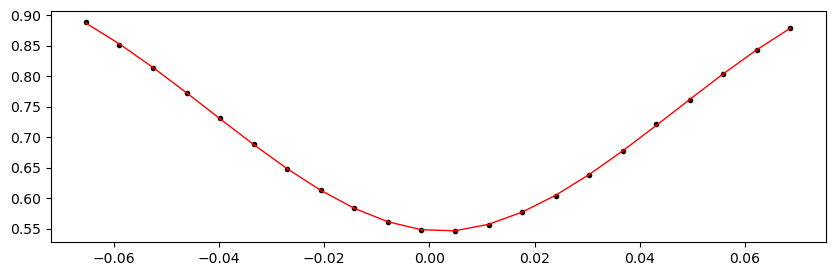

2235.12399 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 410.01it/s]


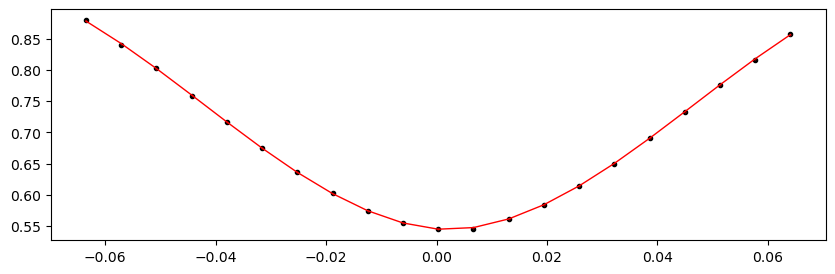

2236.21228 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 424.14it/s]


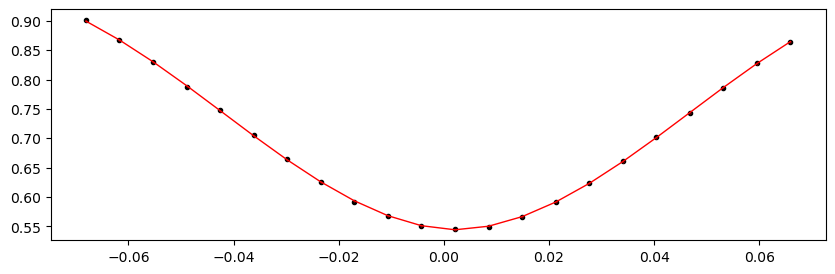

2237.30057 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 427.11it/s]


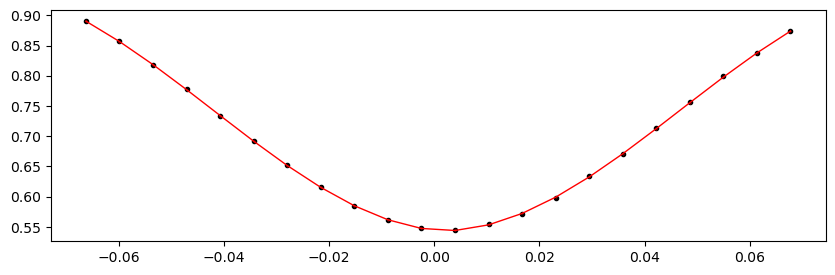

2238.38886 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 428.50it/s]


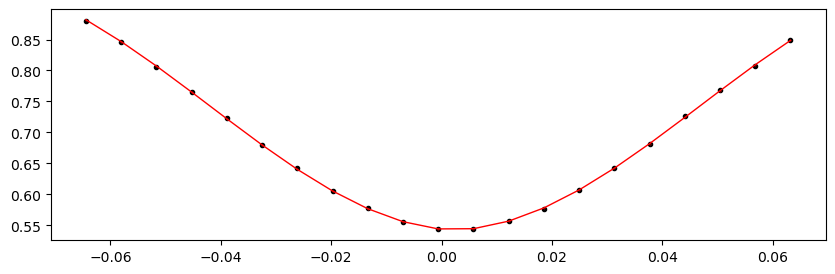

2239.47715 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 428.78it/s]


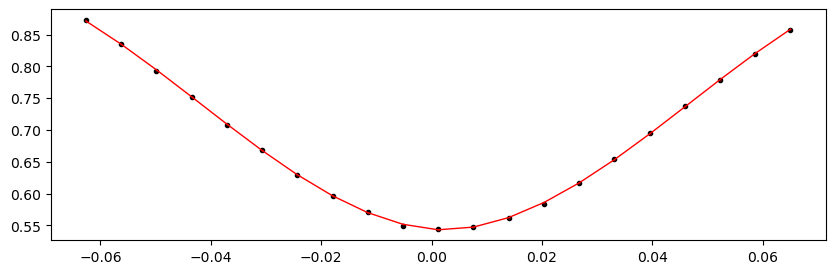

2240.5654400000003 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 409.78it/s]


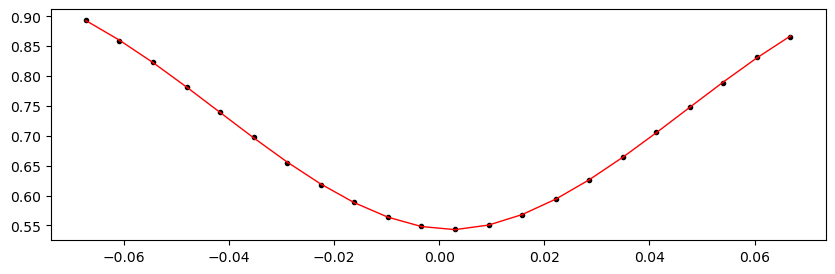

2242.74202 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 421.27it/s]


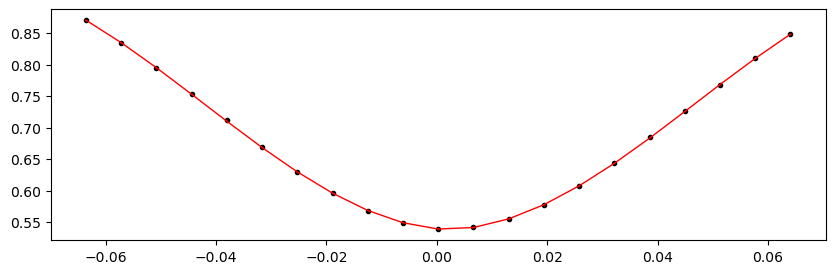

2243.8303100000003 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 423.16it/s]


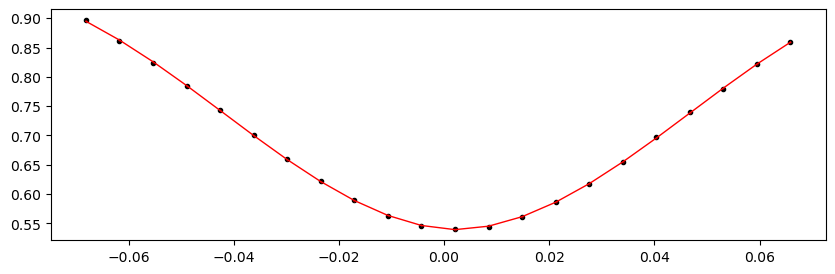

2244.9186 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 420.44it/s]


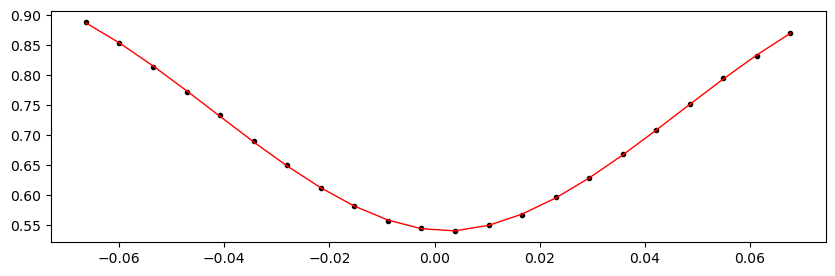

2246.00689 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 420.32it/s]


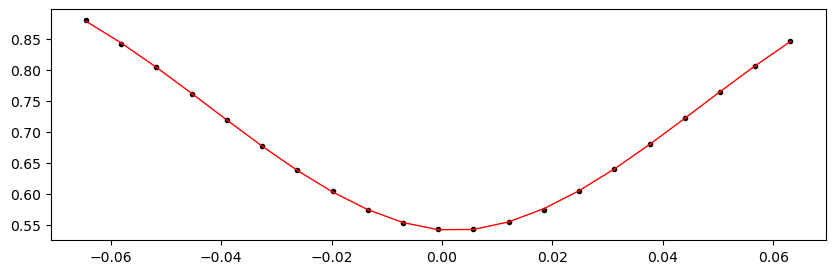

2247.0951800000003 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 424.73it/s]


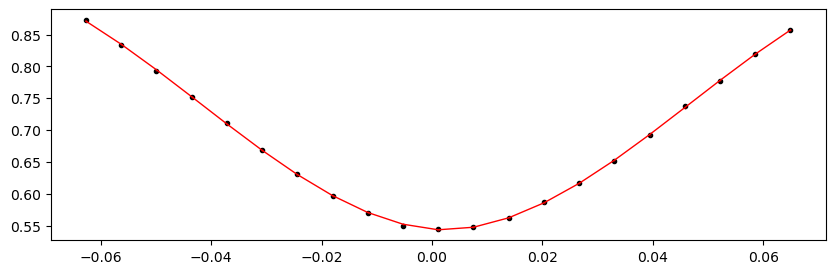

2248.18347 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 426.55it/s]


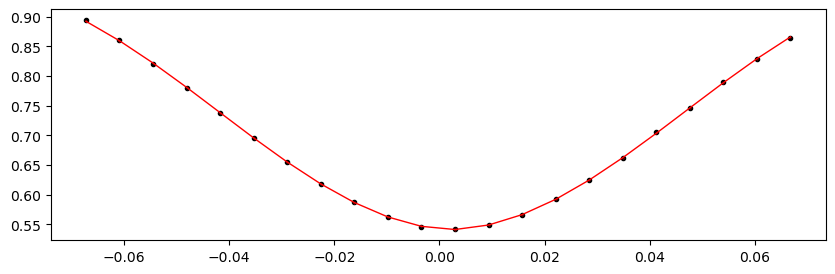

2249.27176 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 425.08it/s]


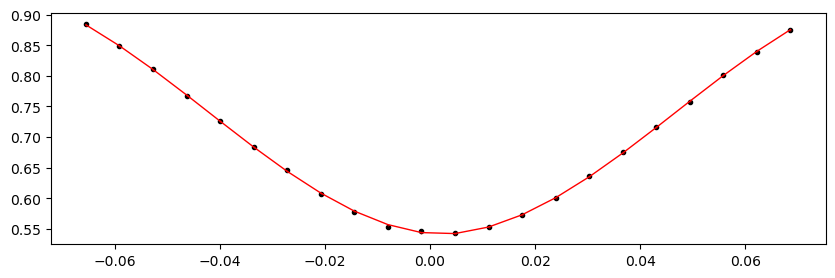

2250.3600500000002 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 426.33it/s]


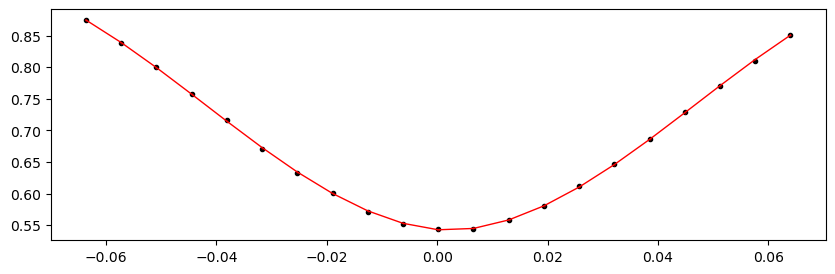

2251.44834 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 425.80it/s]


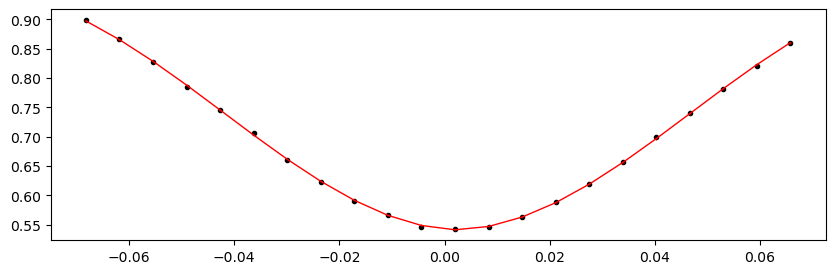

2252.53663 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 426.93it/s]


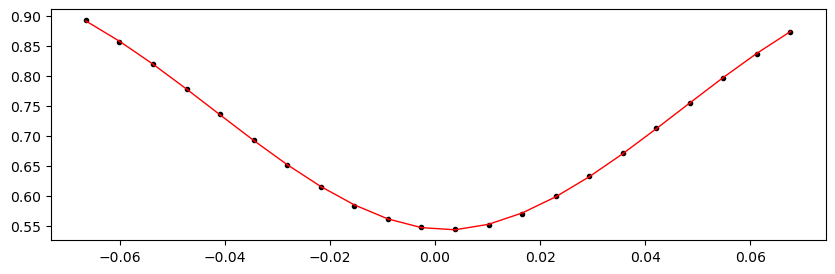

2253.62492 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 426.18it/s]


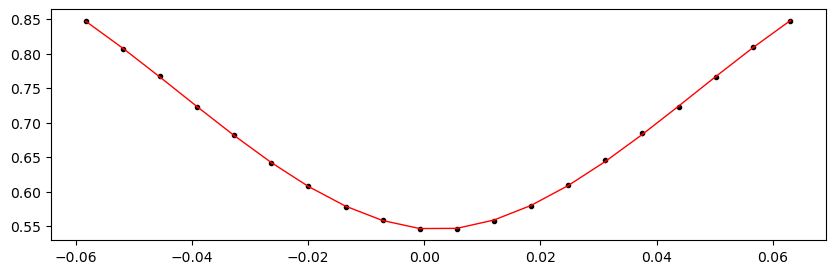

2963.19 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 397.66it/s]


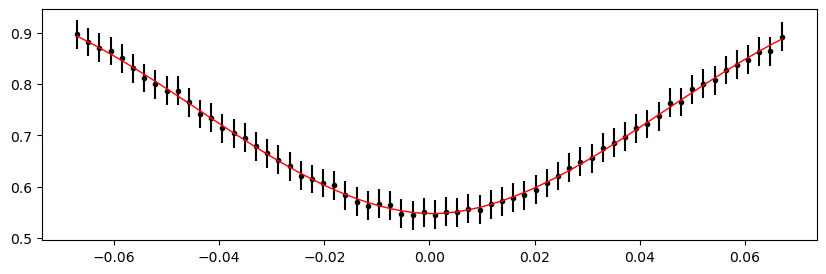

2964.27829 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 393.66it/s]


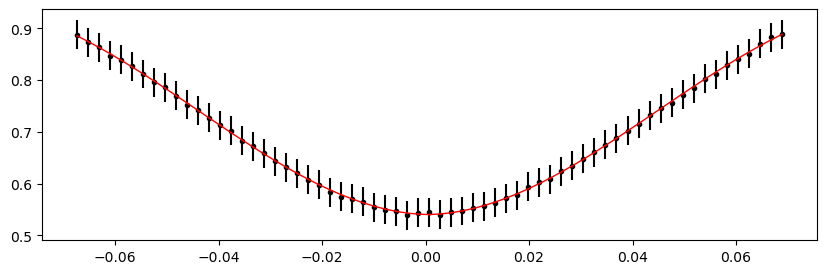

2965.36658 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 397.13it/s]


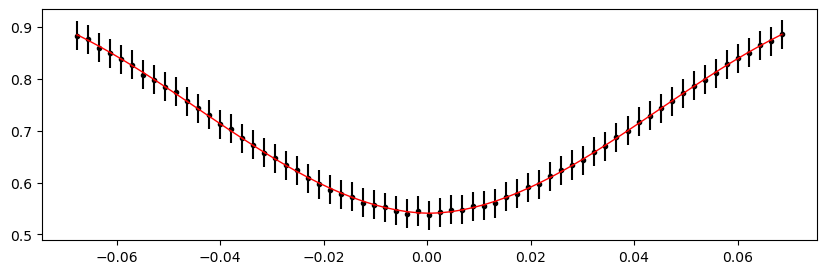

2966.45487 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 387.85it/s]


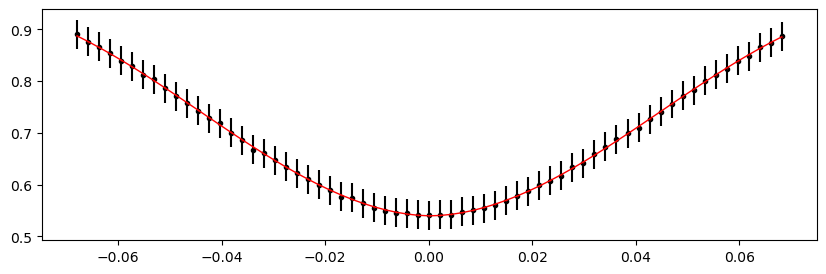

2967.54316 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 385.04it/s]


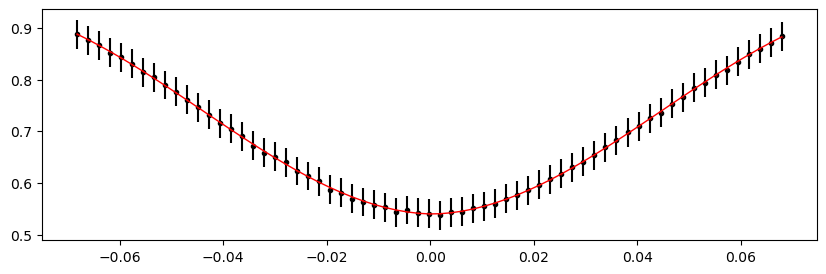

2968.63145 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 403.81it/s]


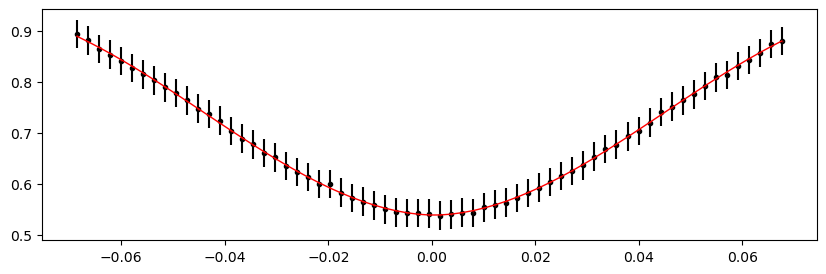

2969.71974 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 394.67it/s]


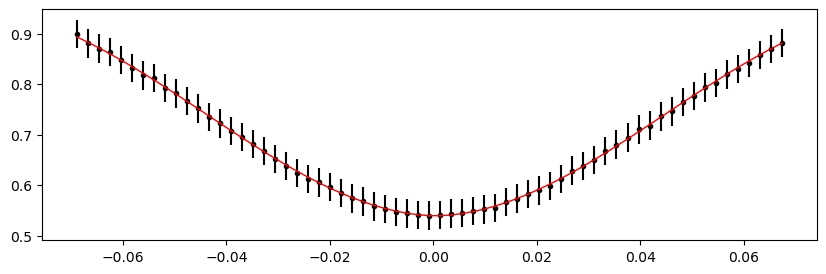

2970.80803 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 401.41it/s]


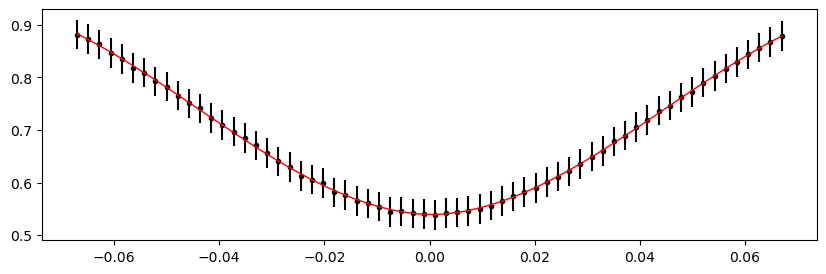

2971.89632 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 390.88it/s]


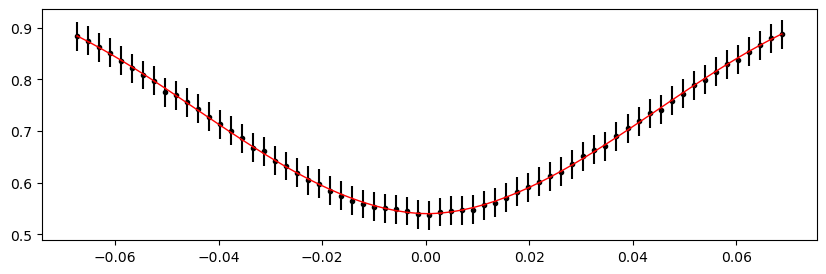

2972.98461 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 402.76it/s]


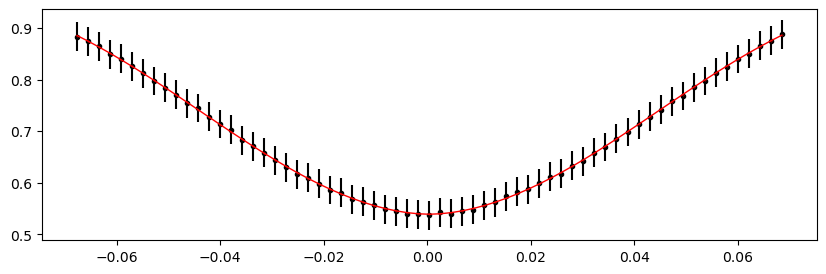

2974.0729 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.05it/s]


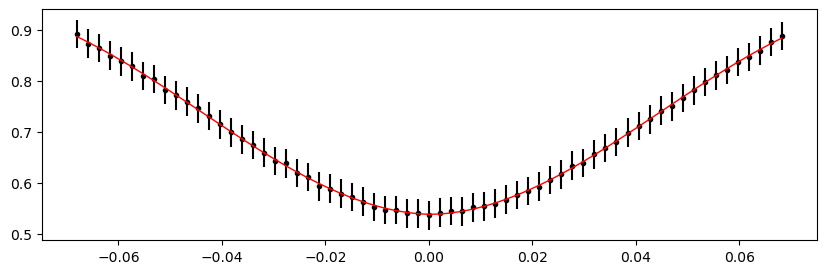

2975.16119 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 404.74it/s]


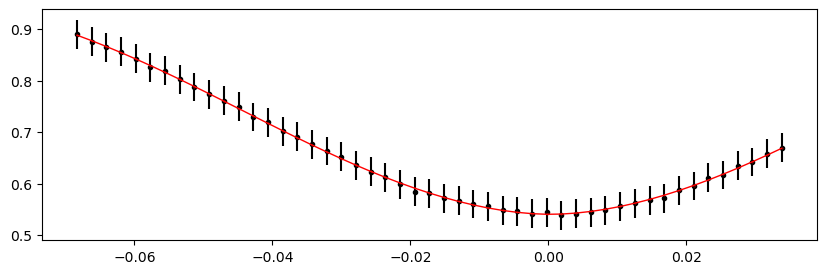

2976.24948 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.52it/s]


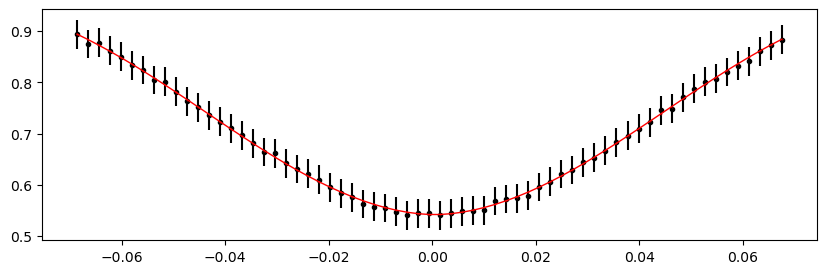

2977.33777 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 396.92it/s]


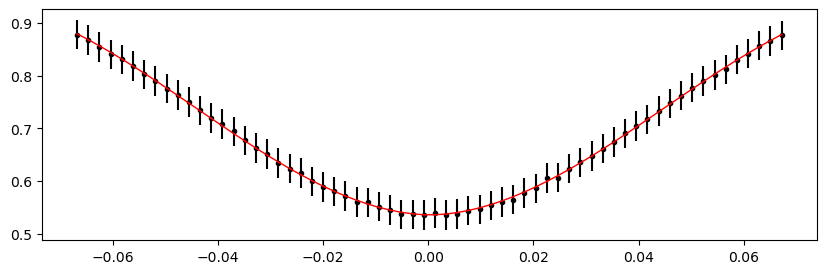

2978.42606 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 397.84it/s]


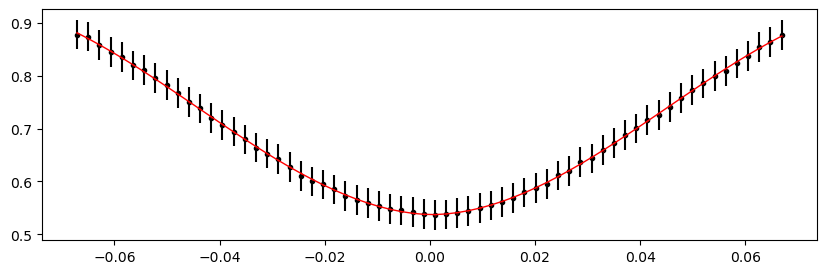

2979.51435 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.18it/s]


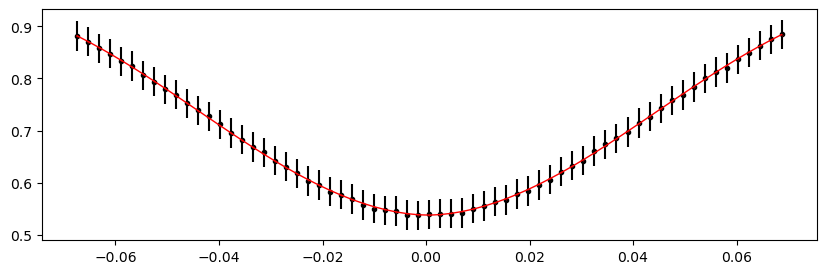

2980.60264 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 394.54it/s]


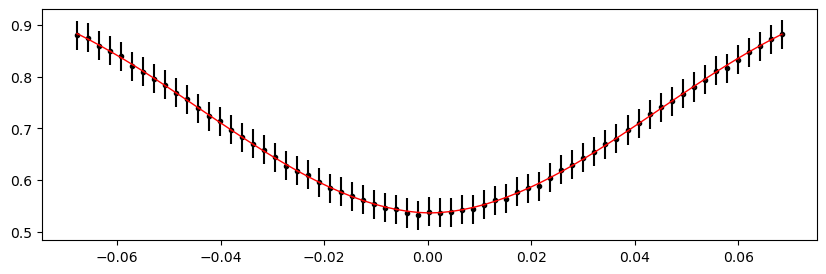

2981.6909299999998 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 402.76it/s]


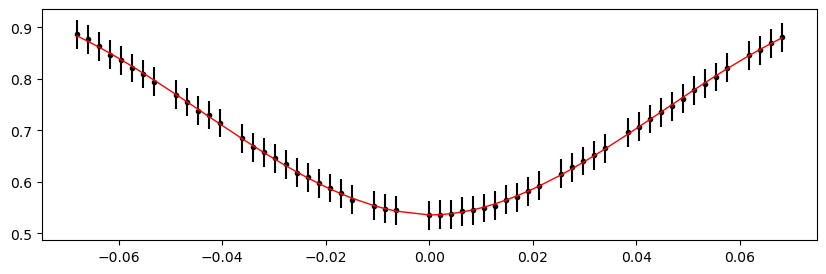

2982.7792200000004 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 397.11it/s]


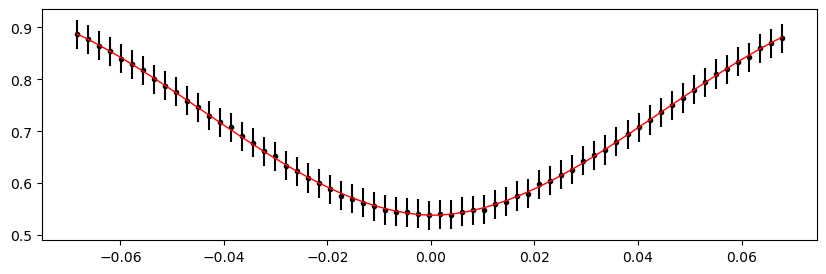

2983.86751 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.01it/s]


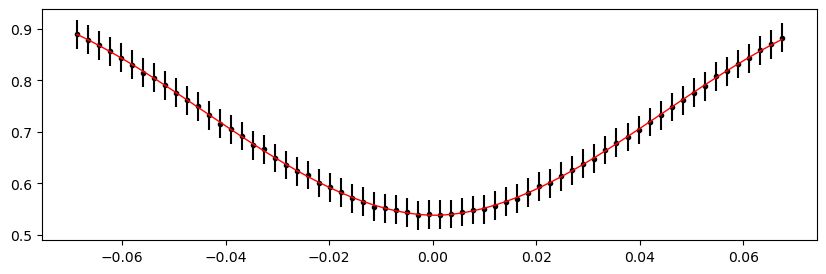

2984.9557999999997 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 401.36it/s]


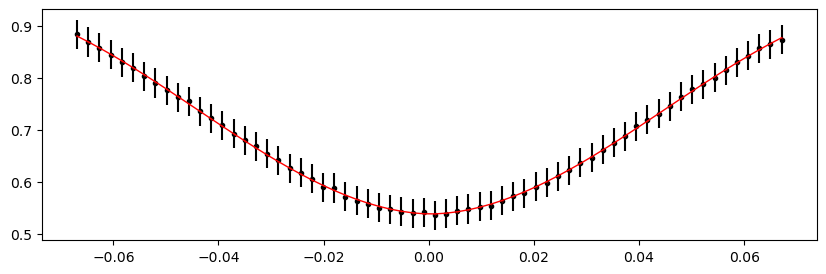

2986.0440900000003 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.97it/s]


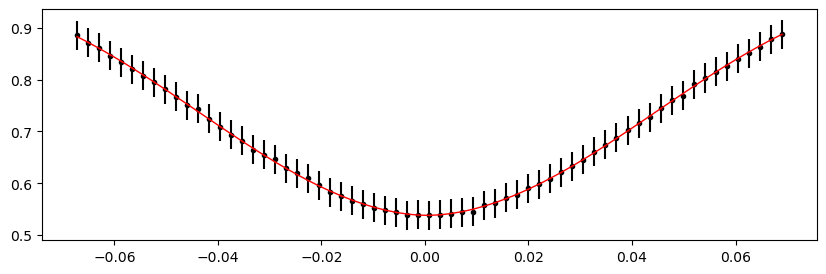

2987.13238 0.9794580282074297 -0.4360006409511223 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.31it/s]


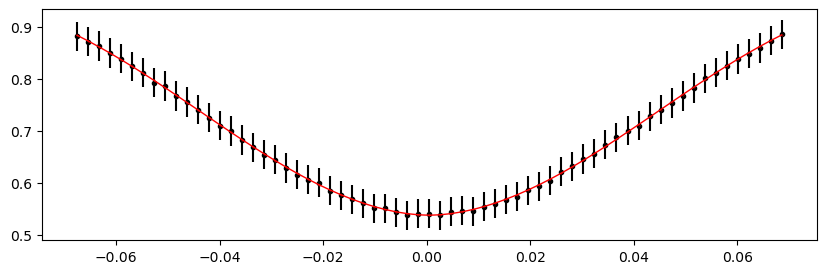

In [50]:
%matplotlib inline

from importlib import reload
reload(etv_functions)

print("Fitting individual primary eclipses...")
etv_functions.fit_each_eclipse(data_primary, n_transits, t0_primary, period, mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau, outfile_path,
                               min_number_data=5, 
                              )
!$NOTIFY_CMD "Individual primary eclipses fit done"

Fitting individual secondary eclipses...
Creating new manifest file
1468.4278050000003 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 428.87it/s]


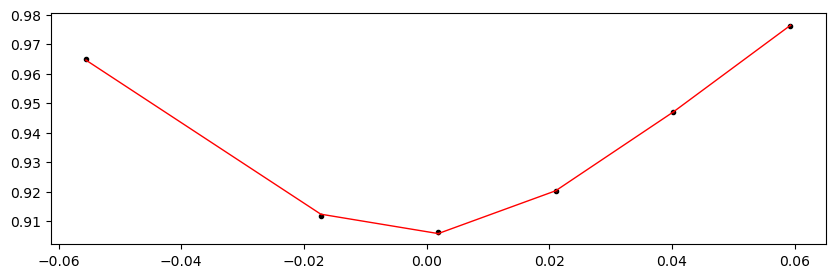

1469.5160950000002 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 435.60it/s]


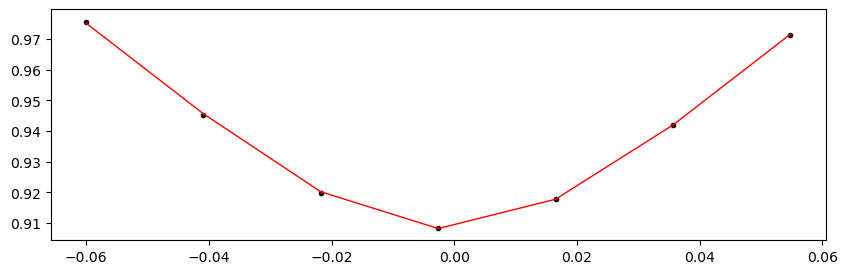

1470.6043850000003 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 433.38it/s]


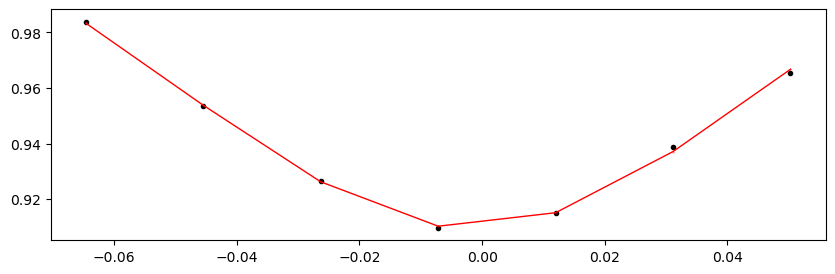

Time 1471.6926750000002 does not have enough data points: 5
1472.7809650000002 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 434.95it/s]


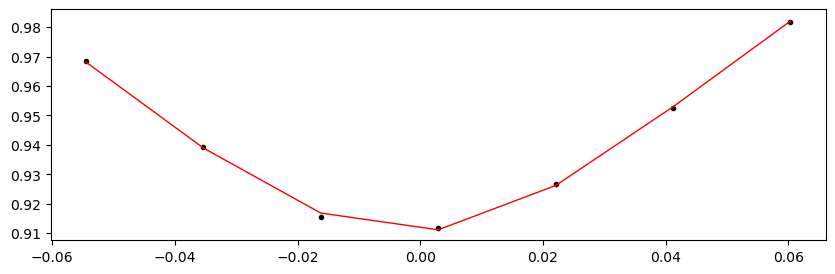

1473.8692550000003 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 433.97it/s]


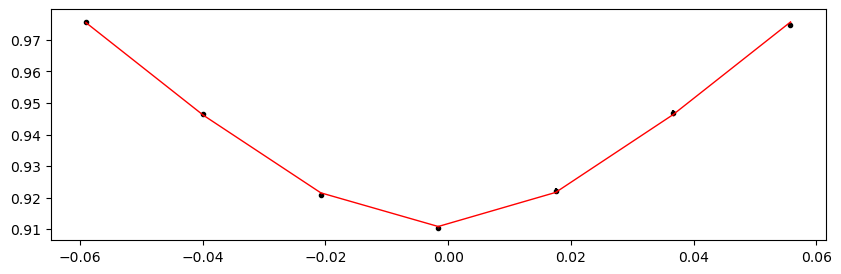

1474.9575450000002 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 437.56it/s]


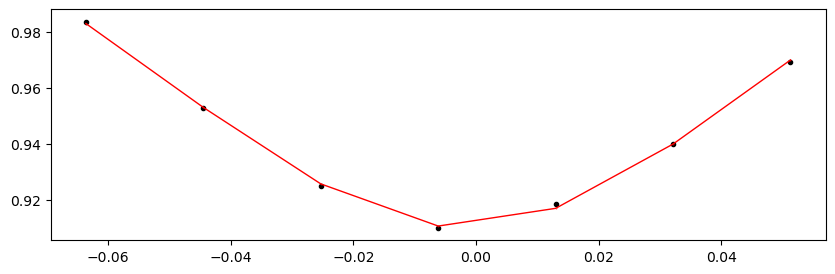

1476.0458350000004 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 435.20it/s]


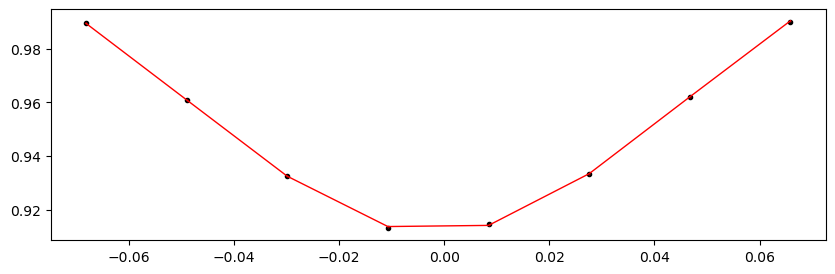

Time 1478.2224150000002 does not have enough data points: 2
1479.3107050000003 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 439.23it/s]


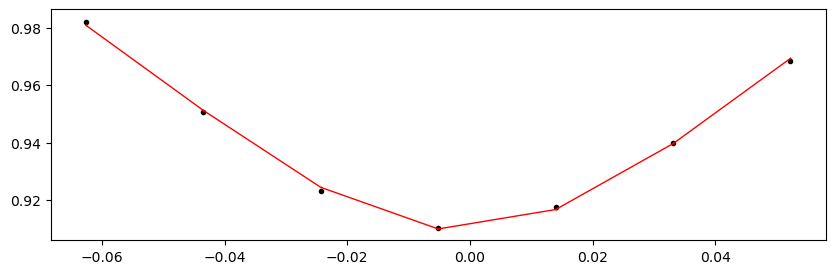

1480.3989950000002 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 438.18it/s]


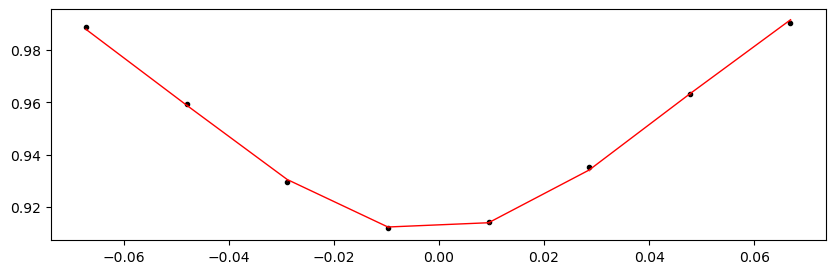

1481.4872850000002 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 435.18it/s]


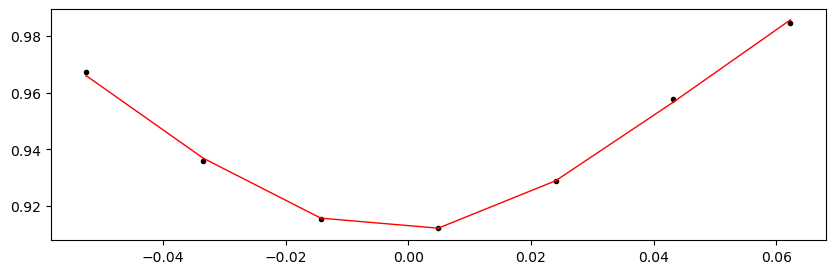

1482.5755750000003 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 435.57it/s]


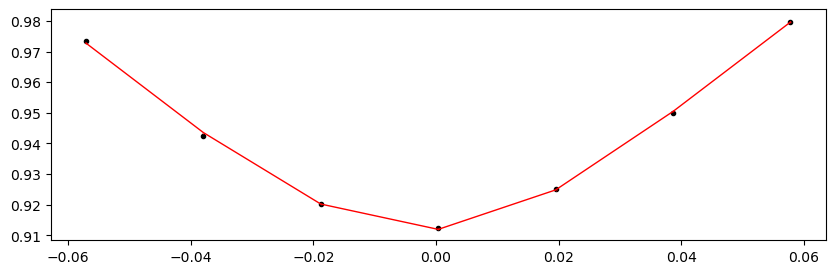

1483.6638650000002 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 440.25it/s]


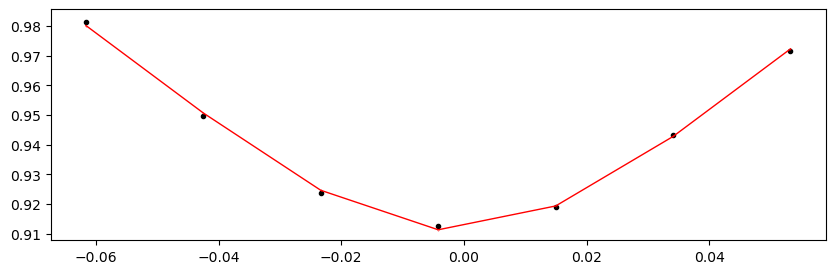

1484.7521550000004 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 435.29it/s]


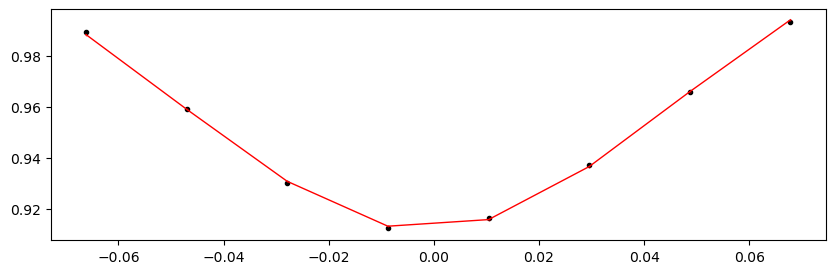

1485.8404450000003 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 434.21it/s]


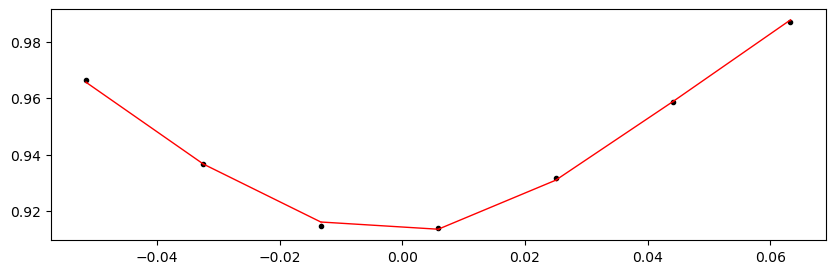

1486.9287350000002 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 430.06it/s]


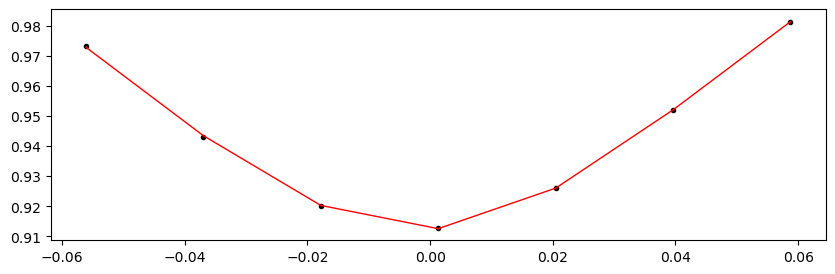

1488.0170250000003 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 433.36it/s]


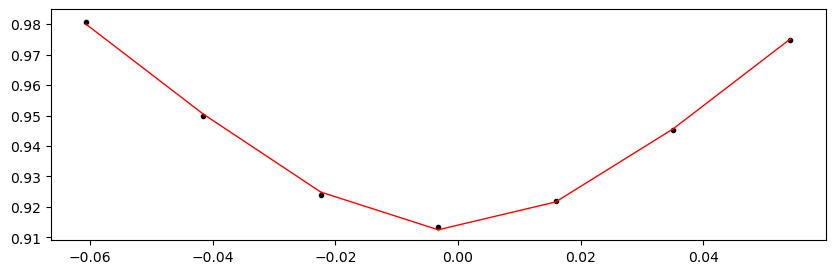

1489.1053150000002 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 437.55it/s]


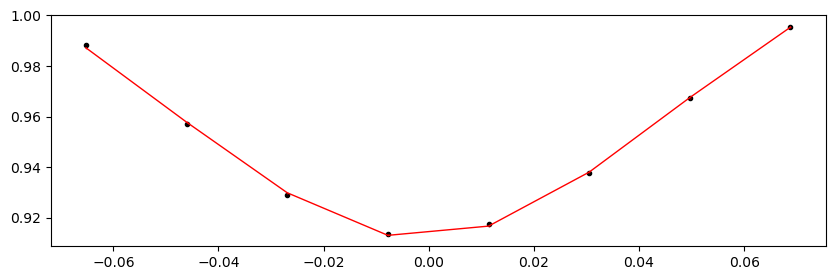

1492.3701850000002 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 438.84it/s]


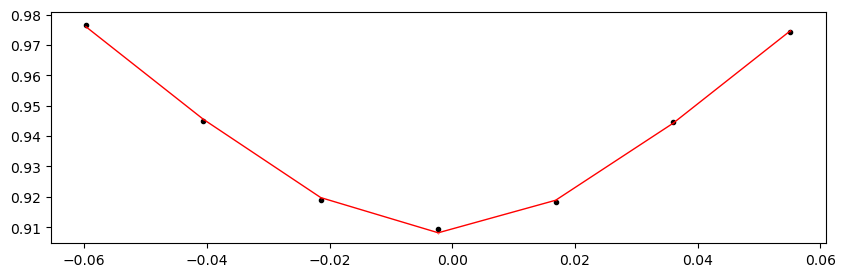

1493.4584750000004 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 439.84it/s]


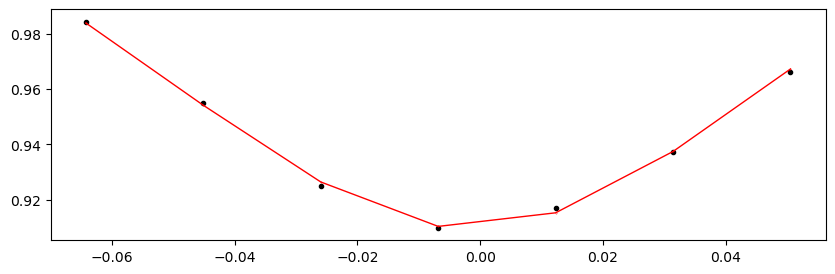

1494.5467650000003 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 441.36it/s]


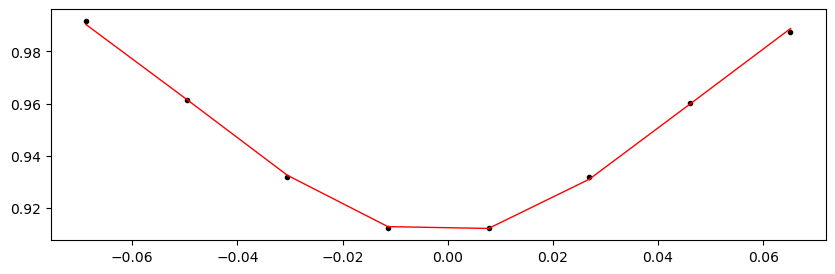

1495.6350550000002 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 439.47it/s]


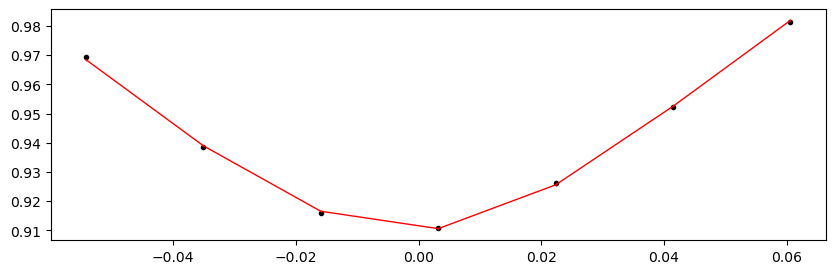

1496.7233450000003 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 430.17it/s]


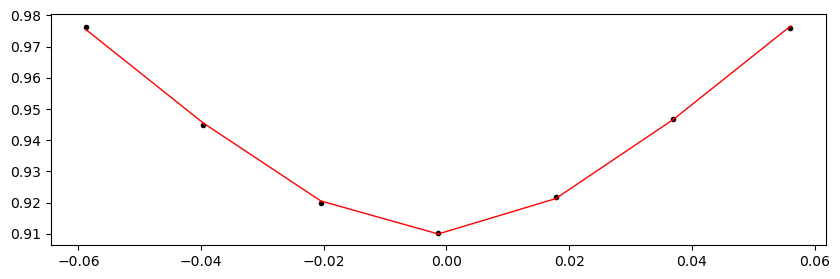

1497.8116350000003 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 438.61it/s]


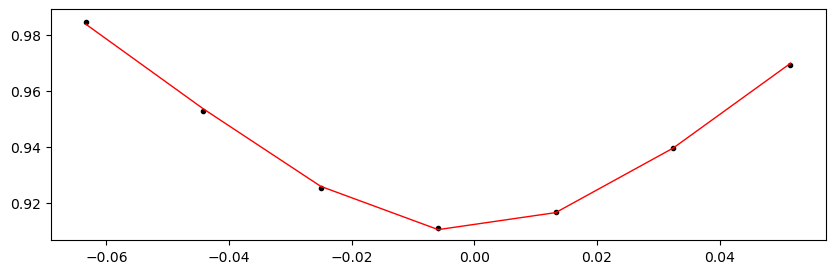

1498.8999250000002 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 435.96it/s]


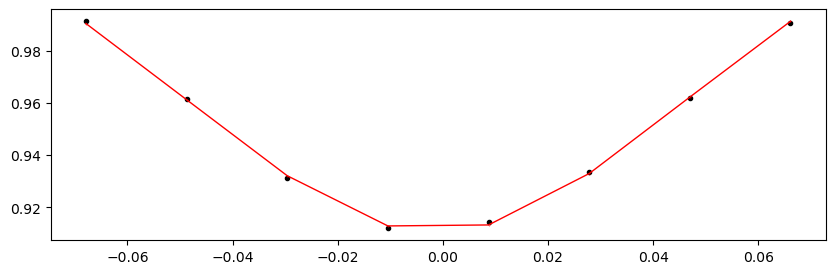

1499.9882150000003 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 438.35it/s]


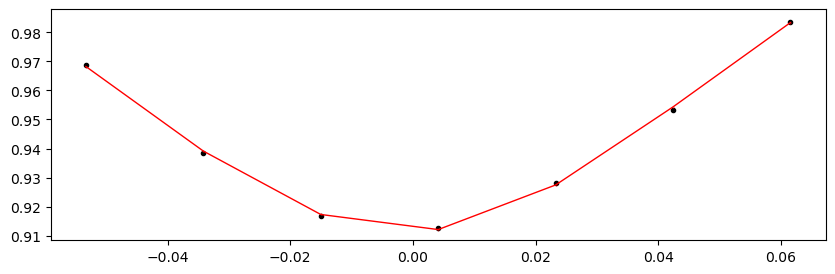

1501.0765050000002 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 442.18it/s]


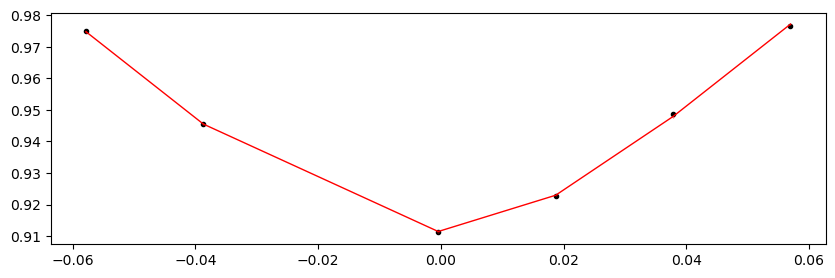

1502.1647950000004 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 431.25it/s]


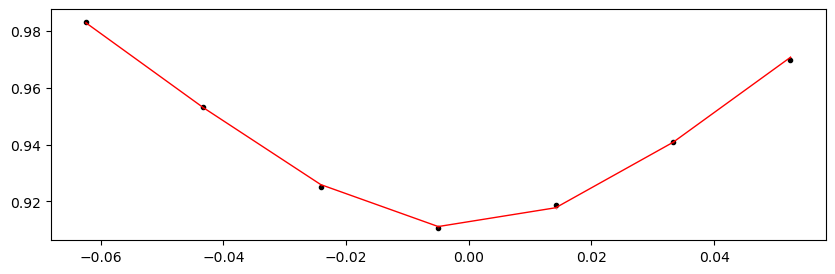

1505.4296650000003 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 432.50it/s]


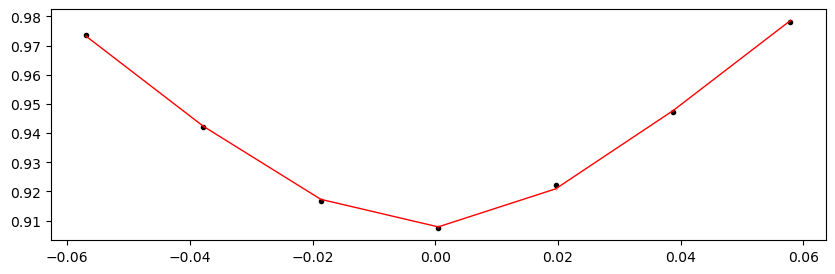

1506.5179550000003 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 433.53it/s]


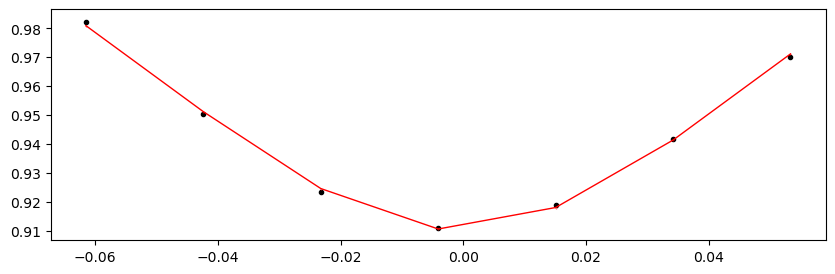

1507.6062450000002 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 434.85it/s]


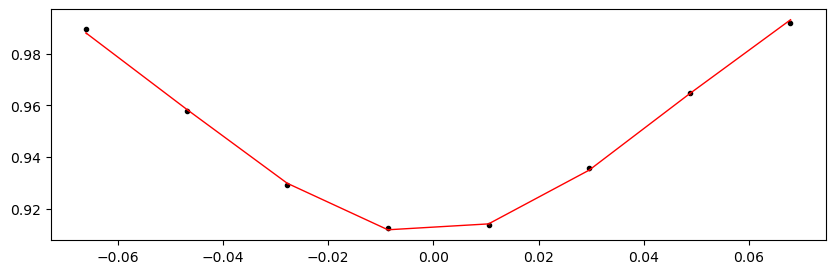

1508.6945350000003 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 430.70it/s]


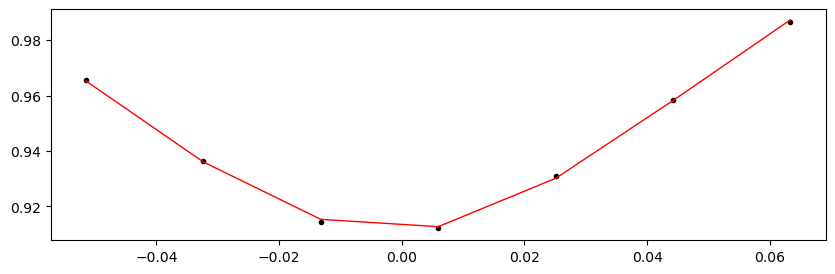

1509.7828250000002 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 437.09it/s]


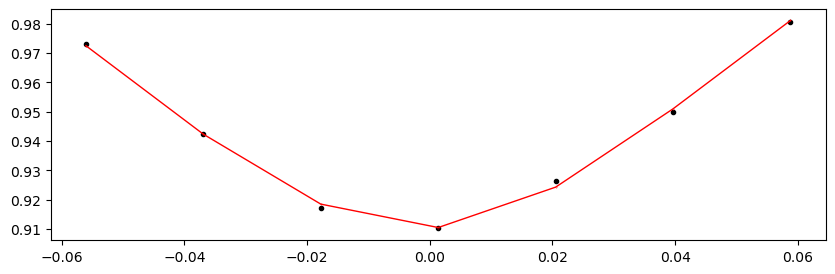

1510.8711150000004 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 434.63it/s]


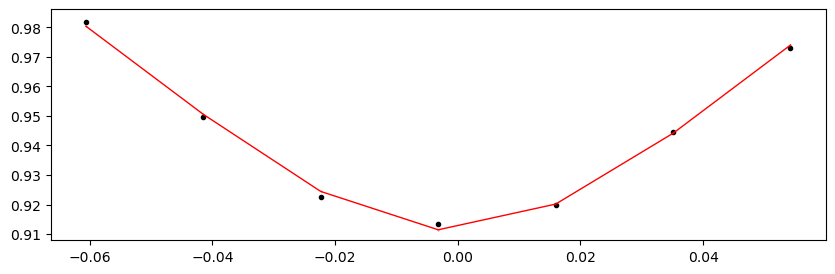

1511.9594050000003 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 430.32it/s]


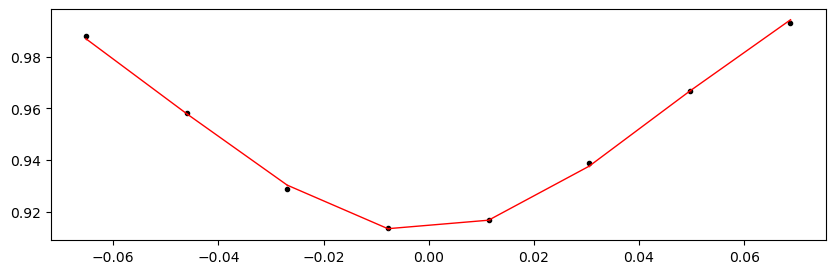

1513.0476950000002 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 431.88it/s]


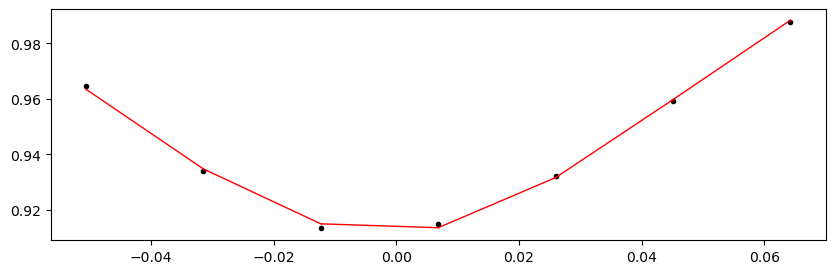

1514.1359850000003 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 434.09it/s]


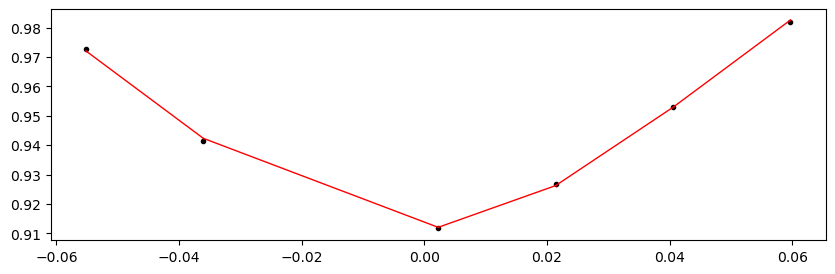

1515.2242750000003 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 440.39it/s]


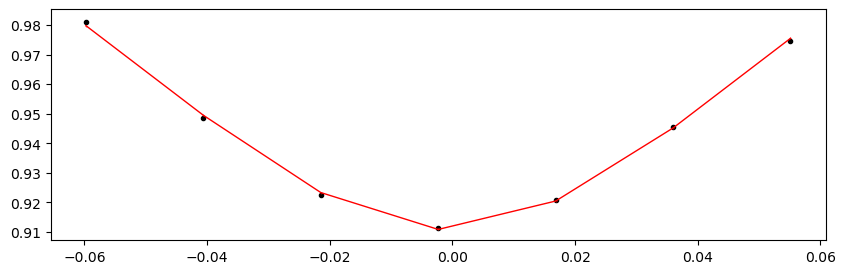

2201.935265 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 427.16it/s]


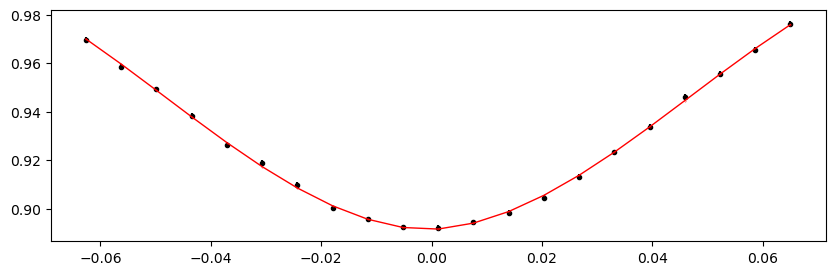

2203.023555 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 429.17it/s]


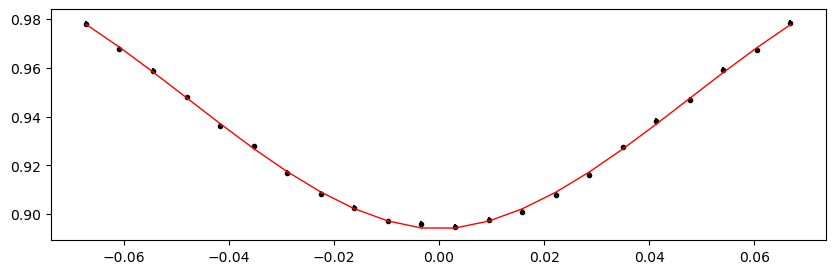

2204.1118450000004 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 427.44it/s]


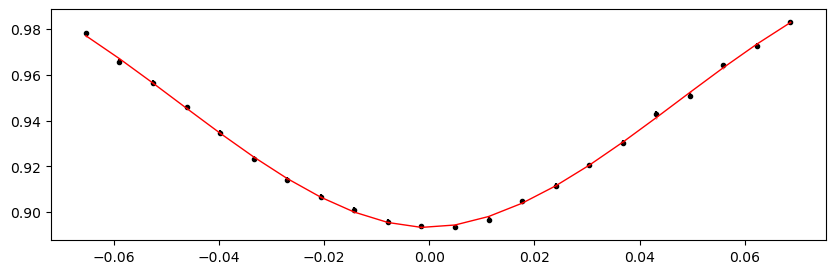

2205.200135 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 424.34it/s]


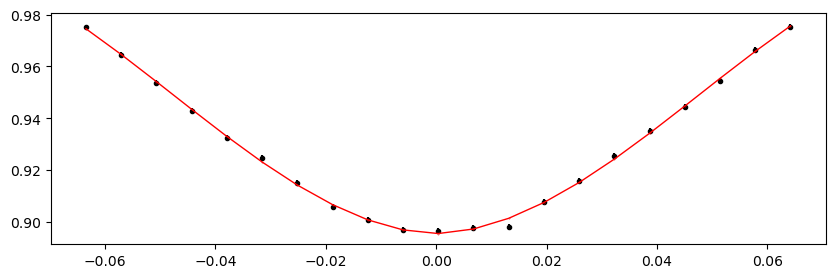

2206.288425 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 411.50it/s]


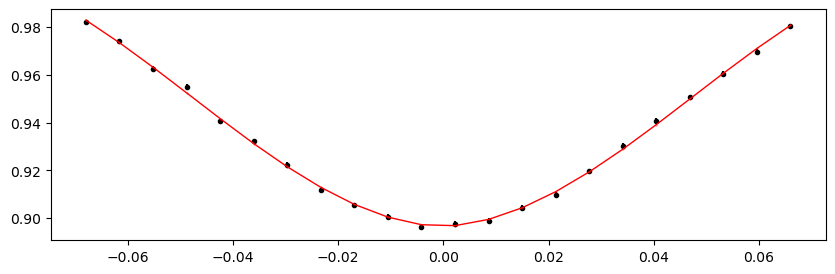

2207.3767150000003 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 425.09it/s]


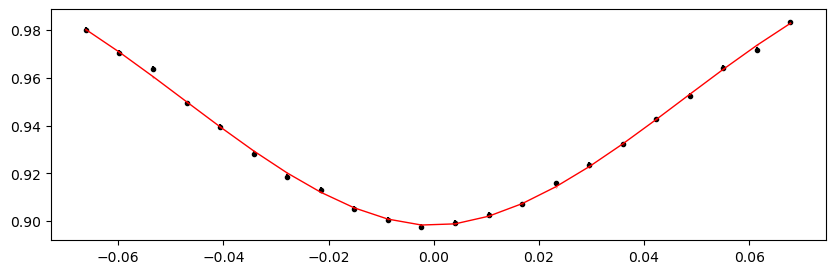

2208.465005 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 427.19it/s]


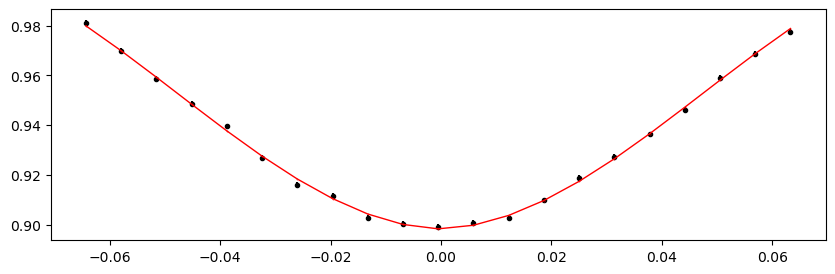

2209.553295 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 417.56it/s]


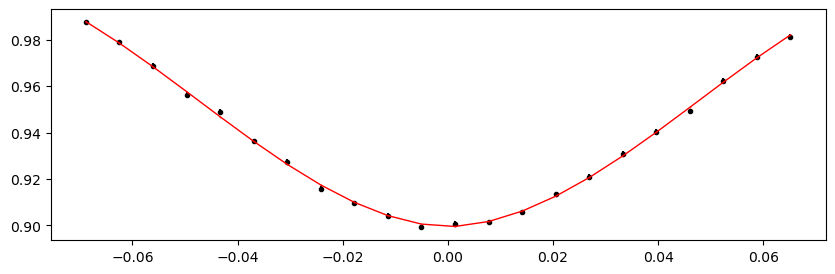

2210.6415850000003 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 419.51it/s]


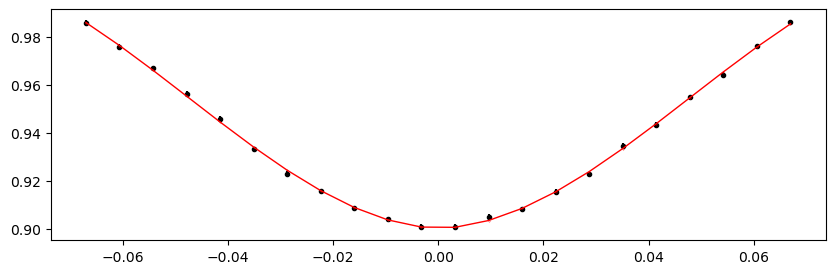

2211.729875 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 424.85it/s]


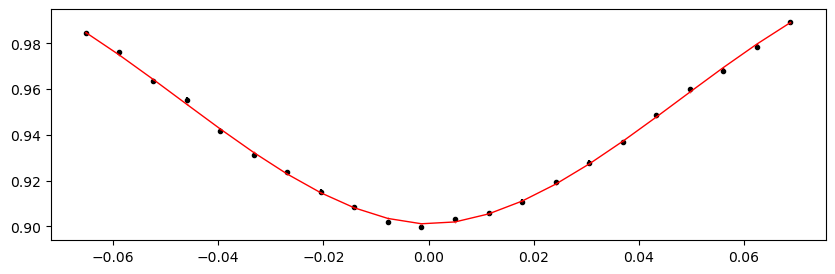

2212.818165 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 430.18it/s]


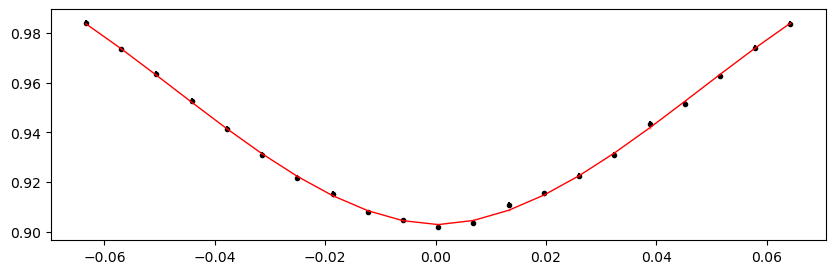

Time 2213.9064550000003 does not have enough data points: 5
2216.083035 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 431.42it/s]


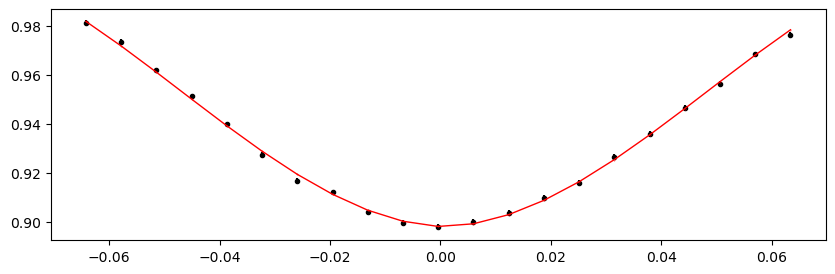

2217.1713250000003 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 420.04it/s]


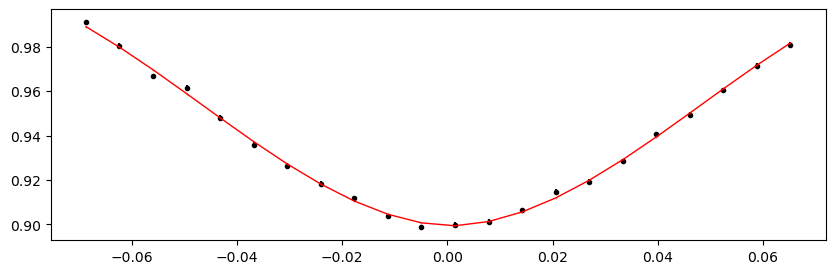

2218.2596150000004 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 424.13it/s]


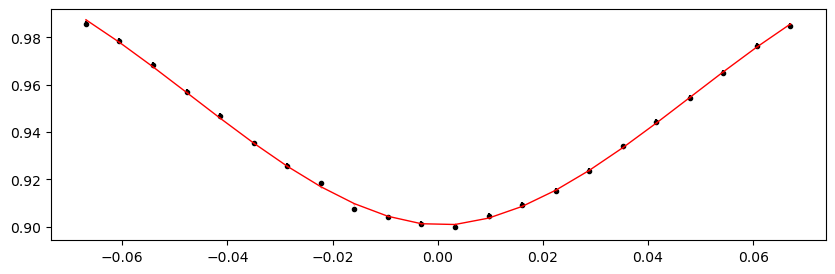

2219.347905 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 421.14it/s]


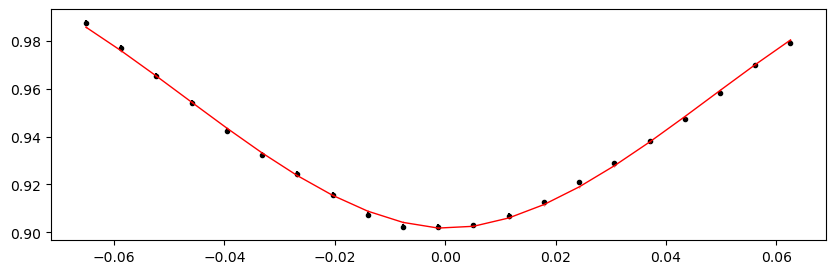

2220.436195 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 430.37it/s]


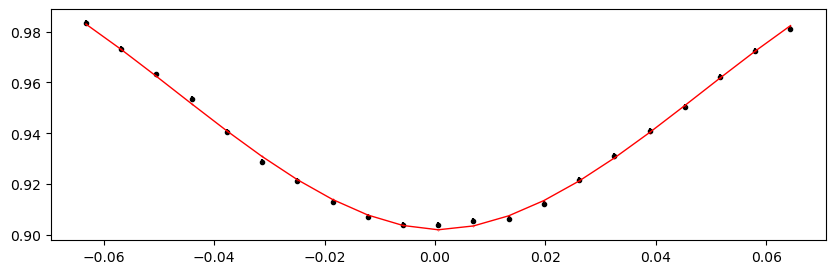

2221.5244850000004 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 430.65it/s]


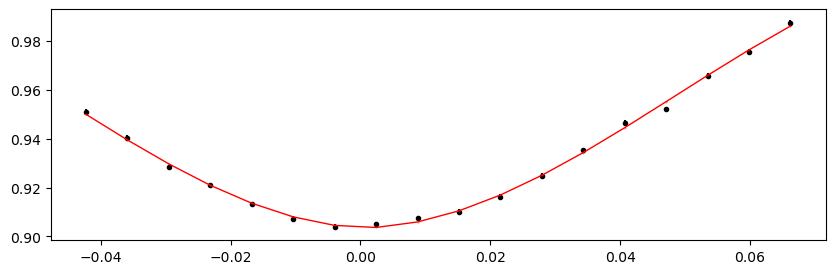

2222.6127750000005 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.70it/s]


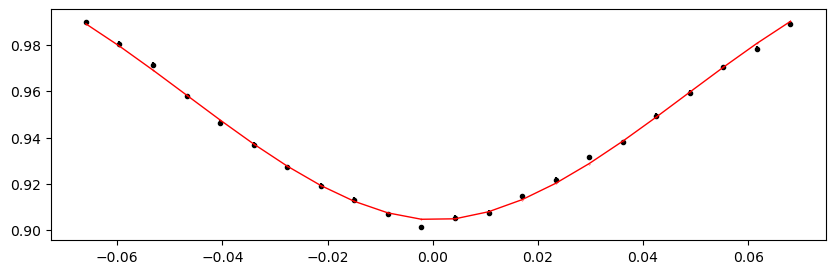

2223.701065 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 414.00it/s]


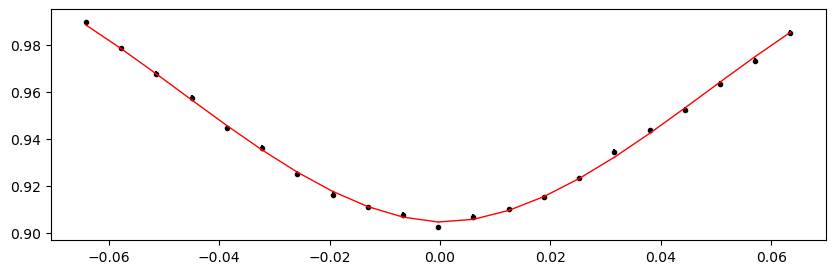

2224.7893550000003 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 424.55it/s]


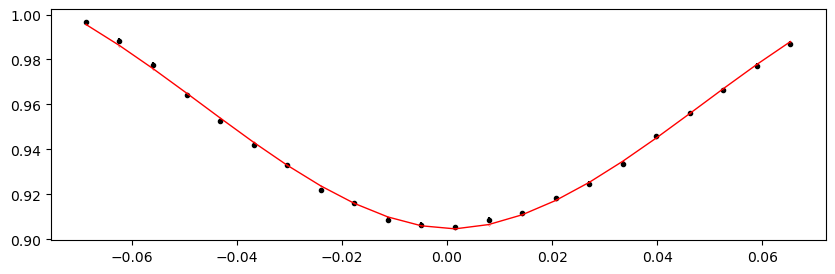

2225.8776450000005 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 412.43it/s]


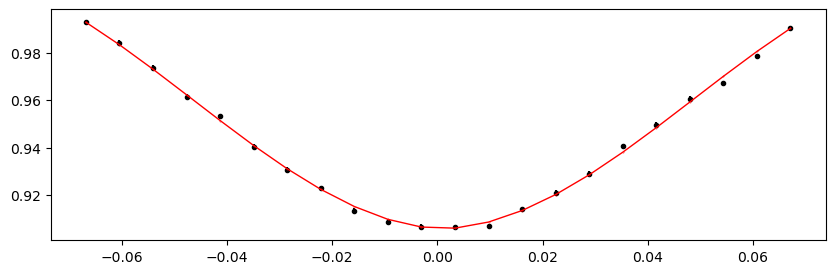

2226.965935 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 419.22it/s]


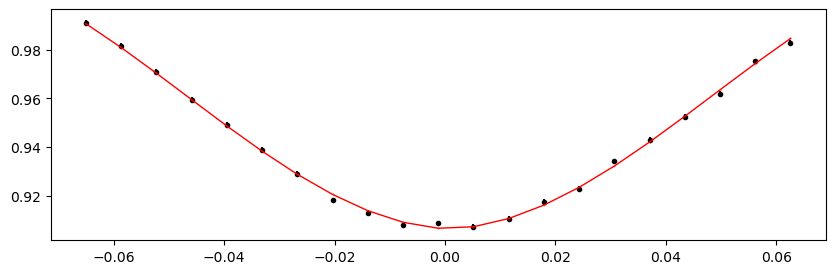

2229.1425150000005 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 424.31it/s]


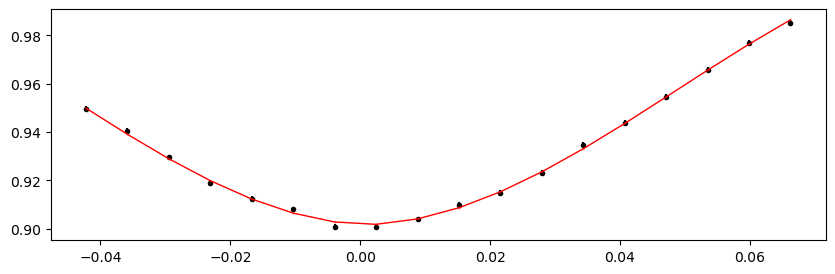

2230.230805 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 396.40it/s]


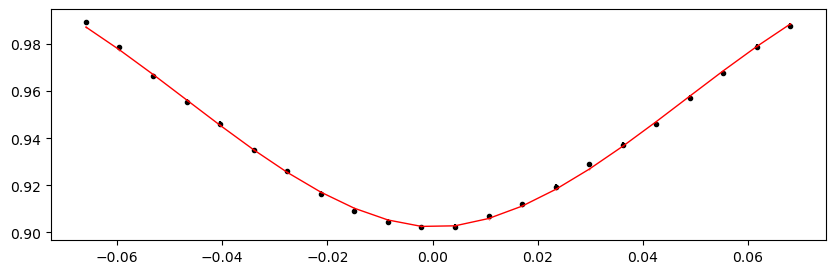

2231.3190950000003 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 419.66it/s]


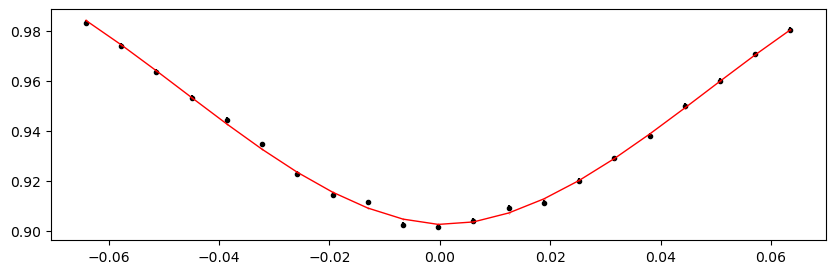

2232.4073850000004 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 424.04it/s]


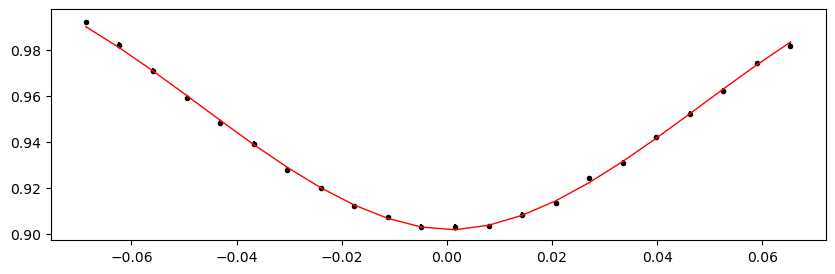

2233.495675 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 416.19it/s]


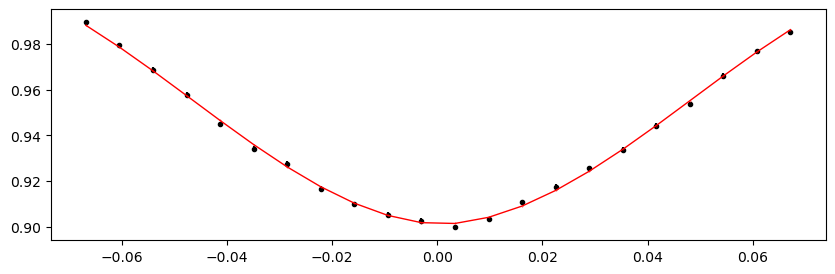

2234.5839650000003 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 420.06it/s]


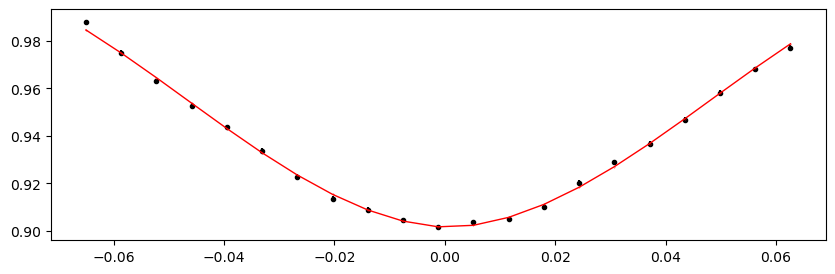

2235.6722550000004 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 423.65it/s]


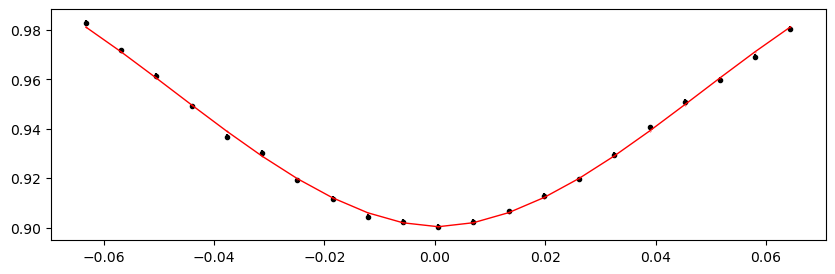

2236.760545 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 425.15it/s]


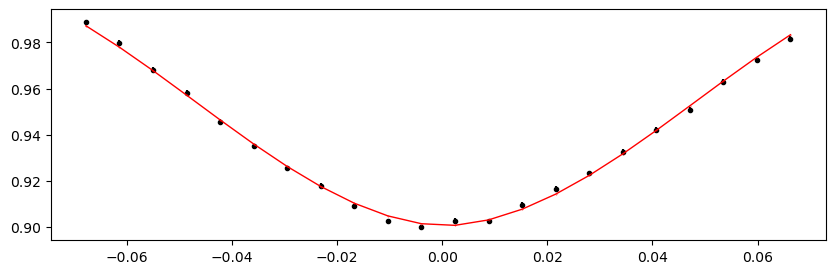

2237.8488350000002 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 421.28it/s]


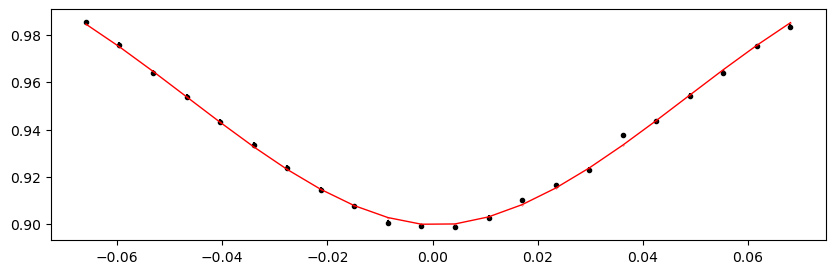

2238.9371250000004 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 425.50it/s]


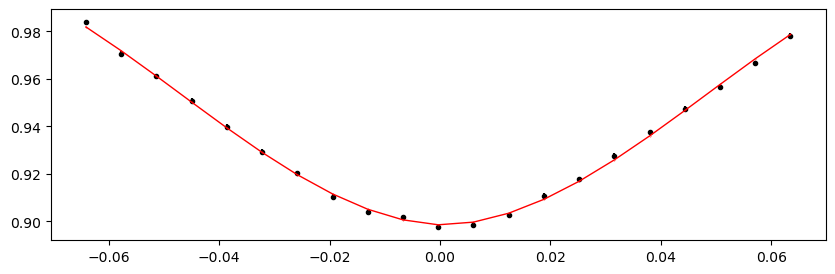

2240.025415 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 423.31it/s]


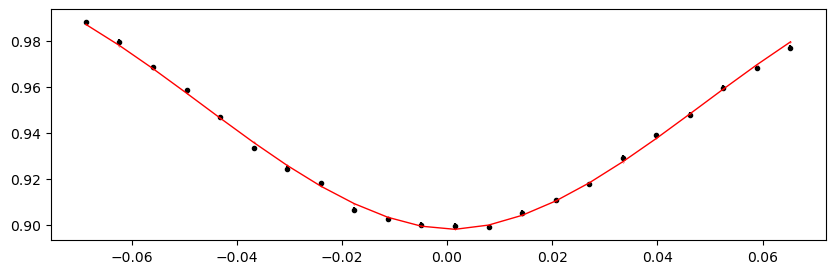

2243.290285 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 420.06it/s]


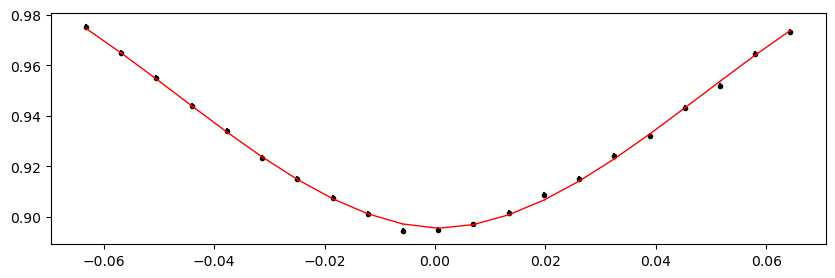

2244.378575 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 413.12it/s]


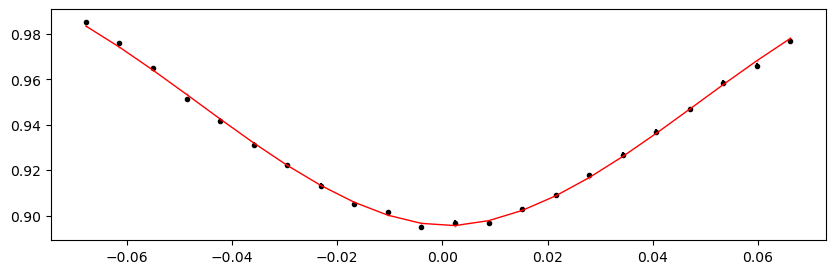

2245.4668650000003 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 432.41it/s]


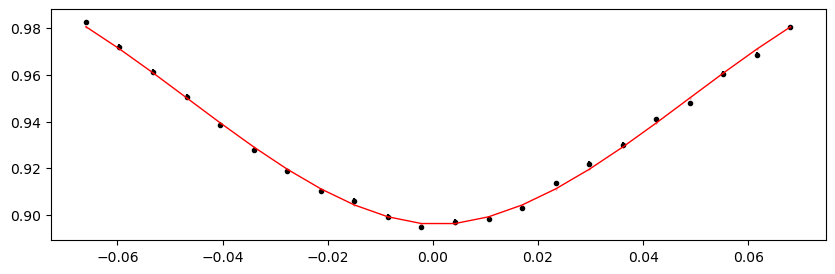

2246.555155 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 419.32it/s]


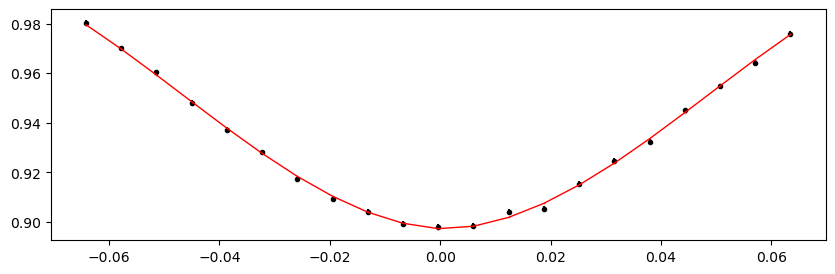

2247.643445 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 404.42it/s]


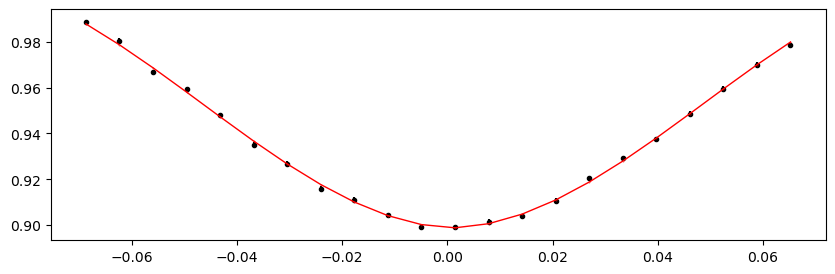

2248.7317350000003 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 407.05it/s]


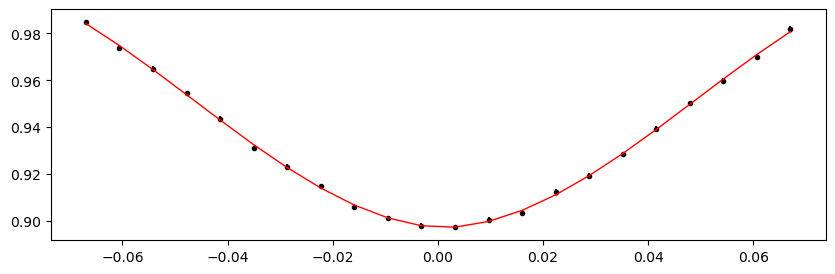

2249.820025 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 426.59it/s]


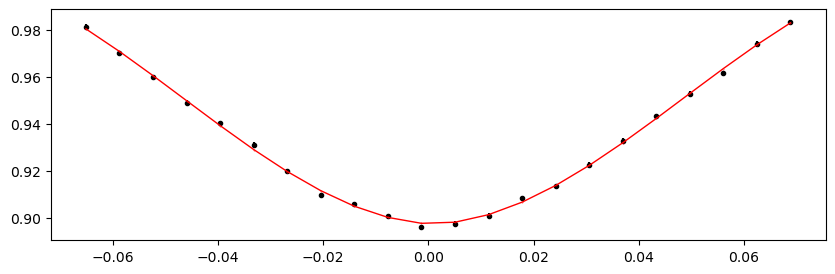

2250.908315 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 426.08it/s]


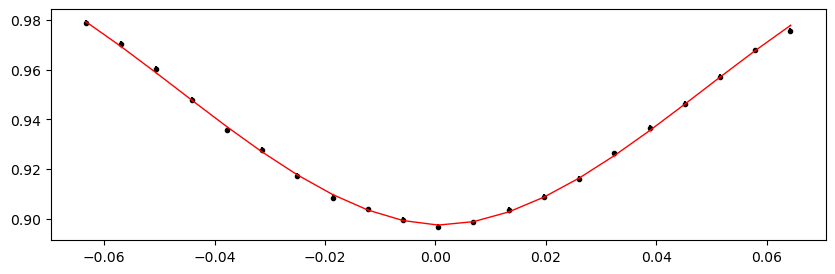

2251.9966050000003 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 416.16it/s]


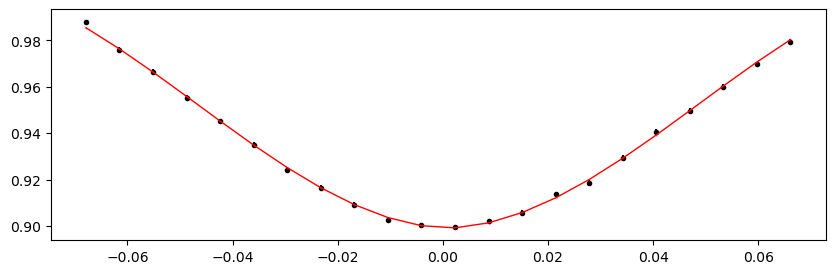

2253.0848950000004 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 425.33it/s]


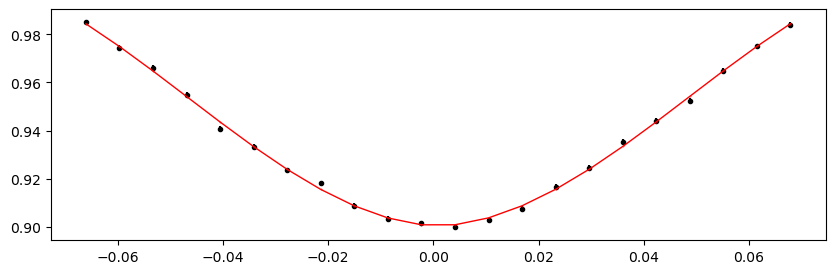

2963.738265 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 397.78it/s]


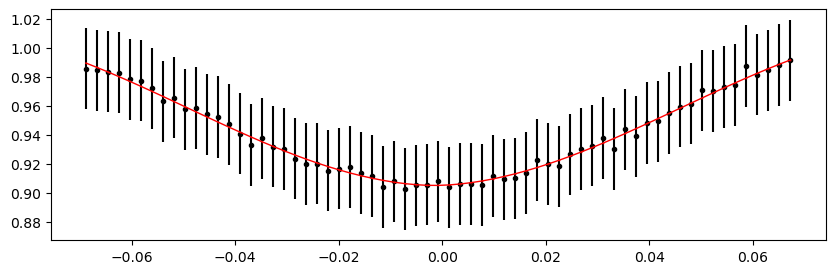

2964.8265550000006 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 395.52it/s]


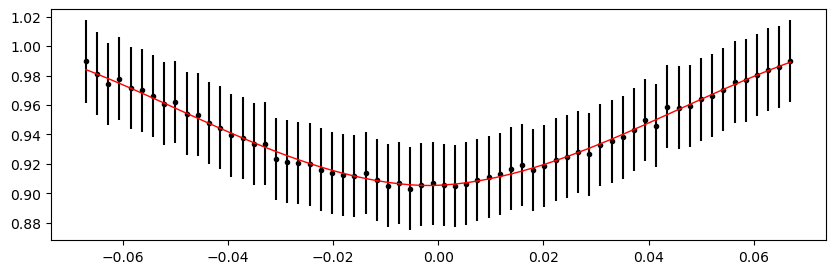

2965.9148450000002 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 395.96it/s]


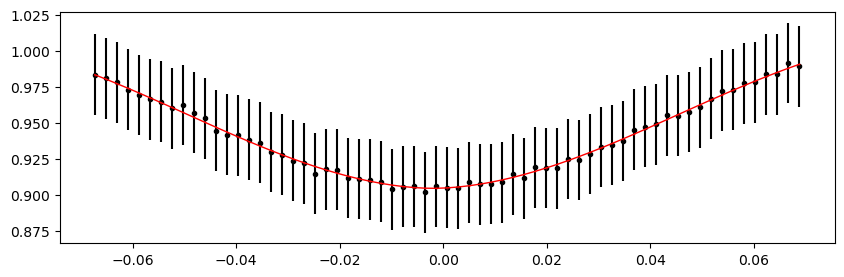

2967.003135 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 386.22it/s]


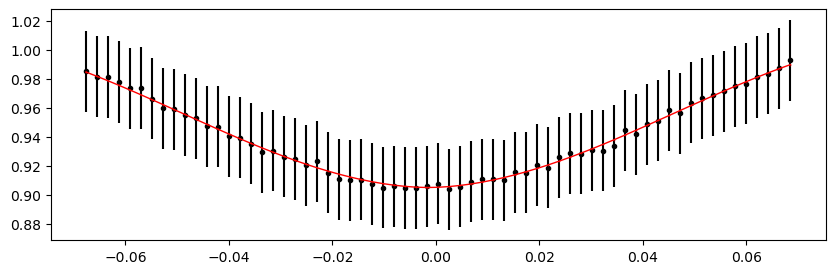

2968.0914250000005 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 402.85it/s]


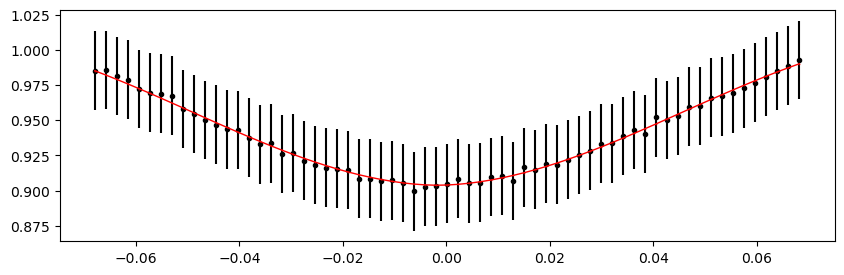

2969.179715 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 403.62it/s]


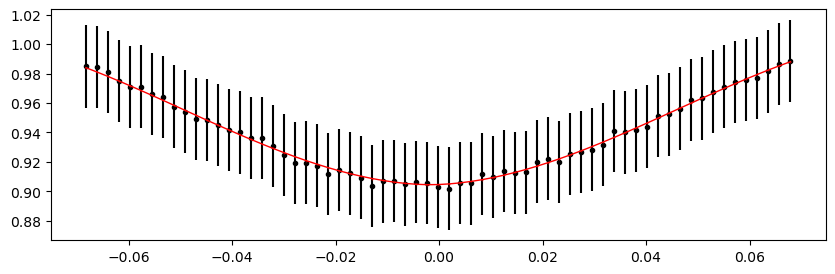

2970.268005 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 402.90it/s]


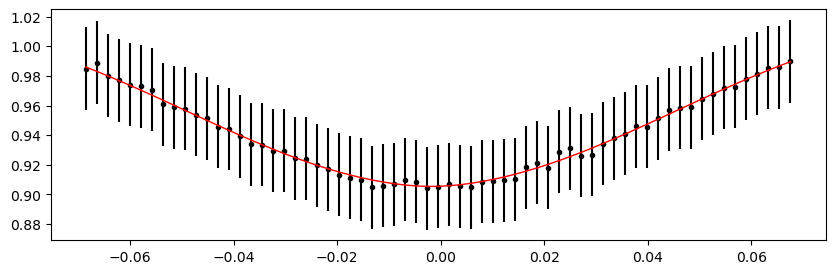

2971.3562950000005 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 403.86it/s]


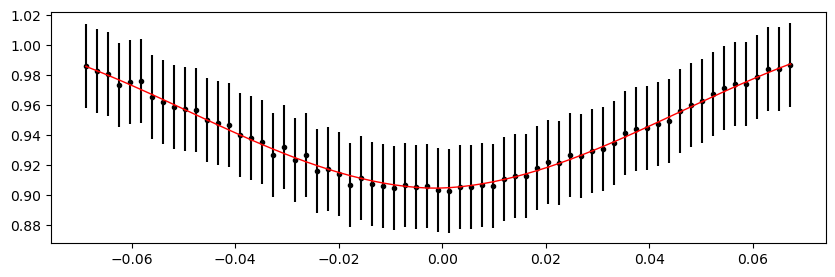

2972.444585 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 404.41it/s]


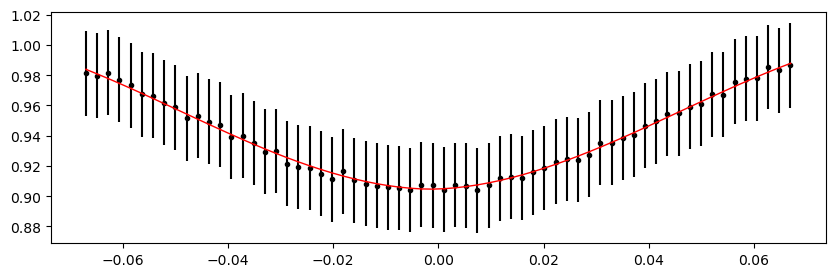

2973.5328750000003 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.27it/s]


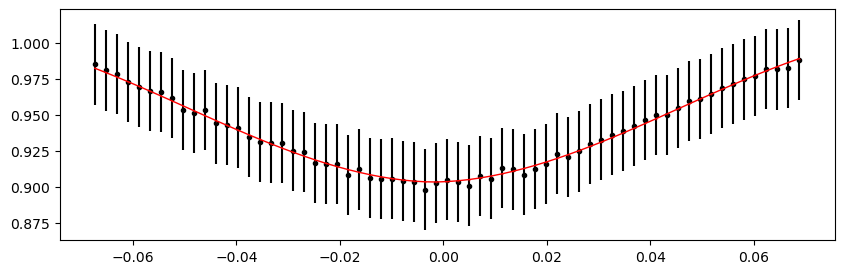

2974.6211650000005 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 388.25it/s]


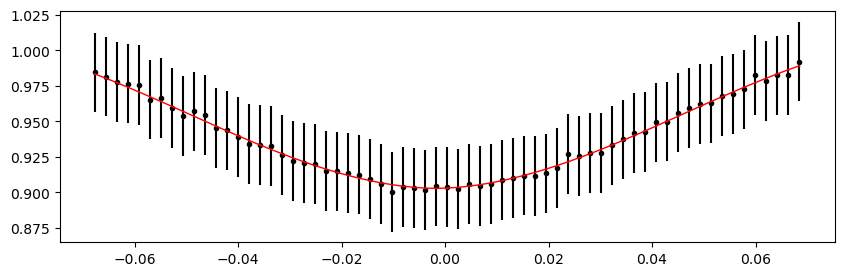

2975.709455 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 391.68it/s]


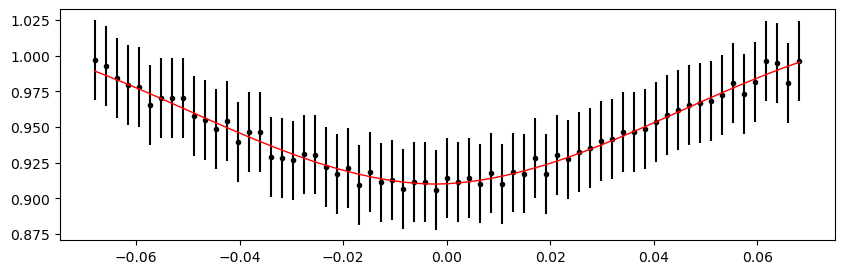

2976.7977450000003 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 394.91it/s]


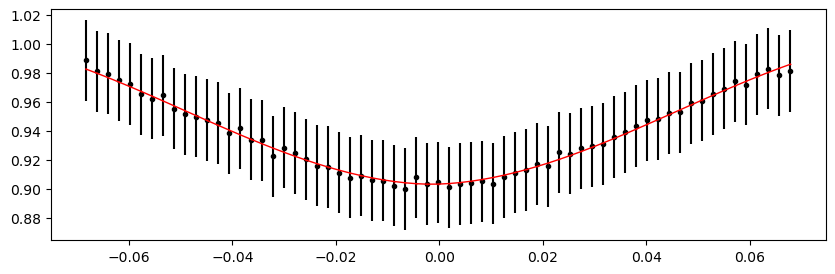

2977.8860350000004 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 396.49it/s]


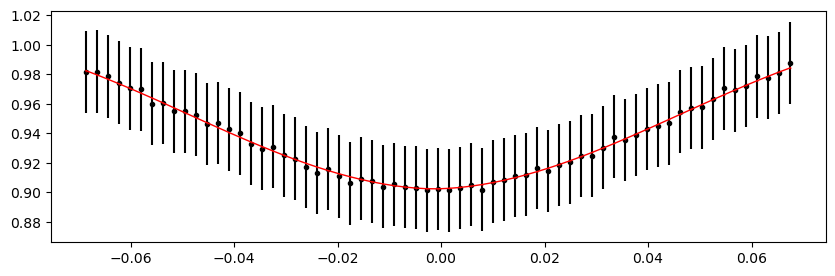

2978.974325 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 391.77it/s]


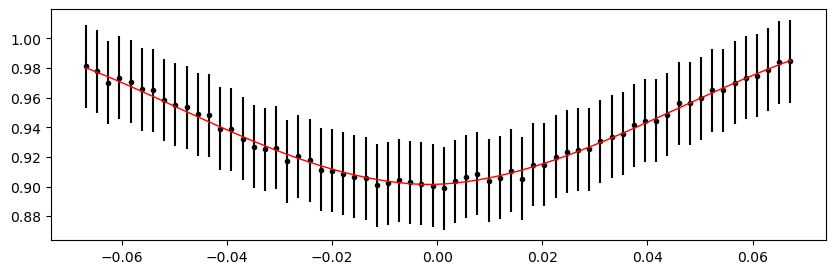

2980.0626150000003 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 392.18it/s]


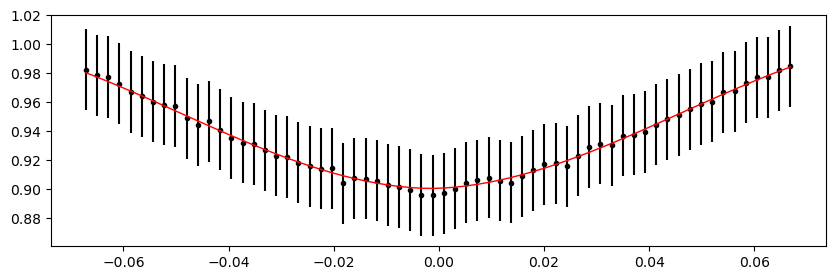

2981.1509050000004 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 397.41it/s]


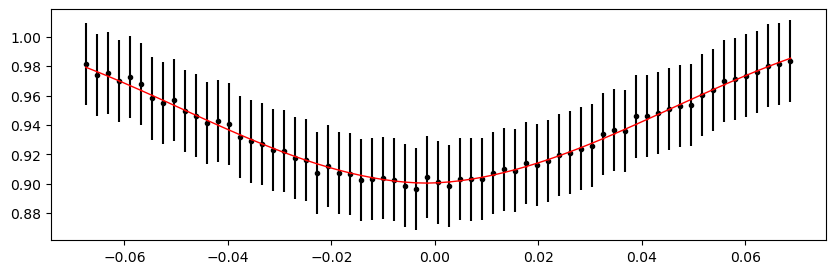

2982.239195 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:18<00:00, 540.26it/s]


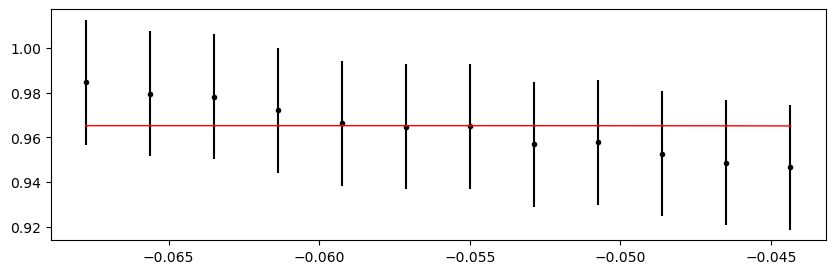

2983.3274850000003 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 394.97it/s]


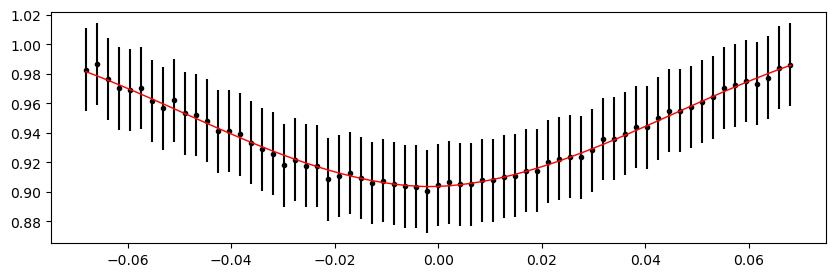

2984.4157750000004 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 382.22it/s]


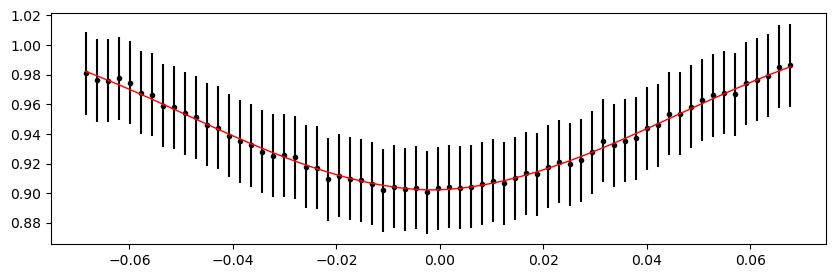

2985.504065 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 386.89it/s]


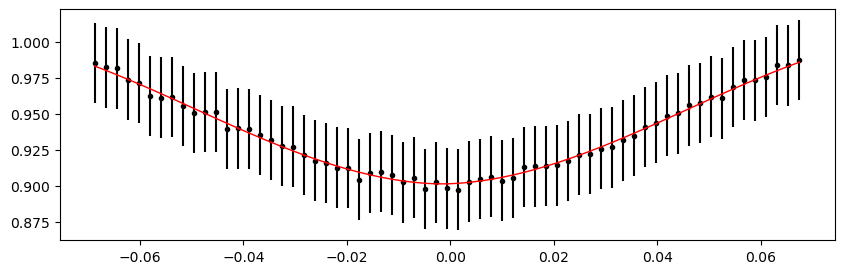

2986.592355 1.0207512538282895 -0.11614878137316131 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 401.71it/s]


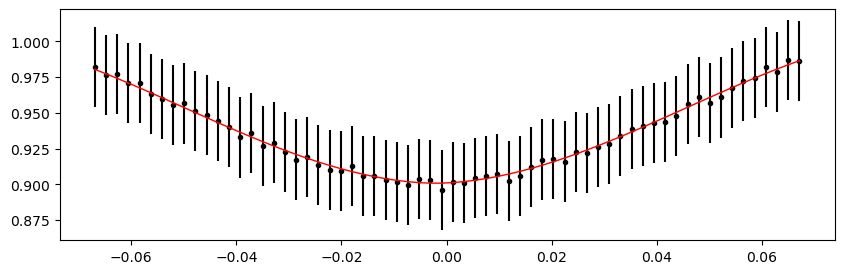

In [51]:
# ---

%matplotlib inline

if t0_secondary is not None:
    print("Fitting individual secondary eclipses...")
    etv_functions.fit_each_eclipse(data_secondary, n_transits, t0_secondary, period, mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s, outfile_path_s,
                                   min_number_data=5, 
                                  )
    !$NOTIFY_CMD "Individual secondary eclipses fit done"
else:
    print("No secondary eclipses defined. No-Op.")

## ETV O-C plot

In [10]:
mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 0.9794580282074297, -0.4360006409511223, 0.22460202949935407, 0.04402514492525912, 0.9246988511157113
mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.0207512538282895, -0.11614878137316131, -0.2732369731003552, 0.04747011581510649, 0.9161873624046053

Note: 0 data points in df_primary filtered out due to huge O-C error.
Note: 1 data points in in_df_secondary filtered out due to huge O-C error.


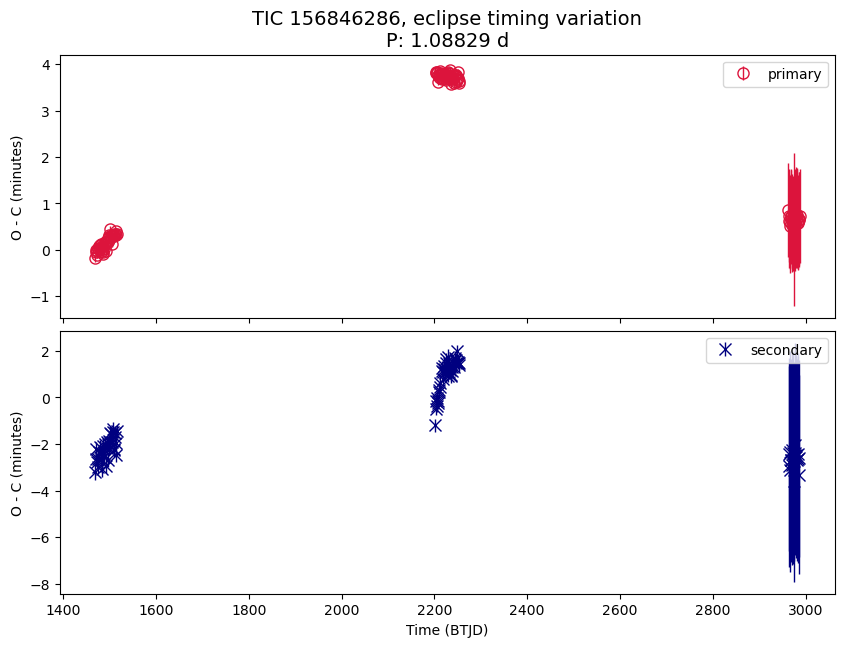

In [11]:
%matplotlib inline
# %matplotlib widget


title_suffix = "eclipse timing variation"

#plot the extracted transit times to check for ETVs

num_rows = 2 if t0_secondary is not None else 1
figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5
# num_rows = 1  # force to plot primary only
# figsize_y = 3.3

fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
    axs = [axs]

in_df_primary = pd.read_csv(outfile_path)
in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
in_df_primary['std_mins'] = in_df_primary['stdv_t0']*period*24*60
in_df_primary_all = in_df_primary  # in case filtering is helpful

in_df_primary = in_df_primary[in_df_primary.std_mins < 10]  # filter out outliers in error
print(f"Note: {len(in_df_primary_all) - len(in_df_primary)} data points in df_primary filtered out due to huge O-C error.")

# axs[0].plot(in_df_primary['epoch'], in_df_primary['shift_mins'],
#              lw = 1, color = 'crimson', )
# axs[0].scatter(in_df_primary['epoch'], in_df_primary['shift_mins'],
#              marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
axs[0].errorbar(in_df_primary['epoch'], in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'],
             lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")

# if False:
if t0_secondary is not None:
    in_df_secondary = pd.read_csv(outfile_path_s)
    in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period)
    in_df_secondary['shift_mins'] = in_df_secondary['t0']*period*24*60
    in_df_secondary['std_mins'] = in_df_secondary['stdv_t0']*period*24*60
    in_df_secondary_all = in_df_secondary  # in case filtering is helpful

    in_df_secondary = in_df_secondary[in_df_secondary.std_mins < 10]  # filter out outliers in error
    print(f"Note: {len(in_df_secondary_all) - len(in_df_secondary)} data points in in_df_secondary filtered out due to huge O-C error.")

    # axs[1].plot(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
    #              lw = 1, color = 'navy', )
    # axs[1].scatter(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
    #              marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
    axs[1].errorbar(in_df_secondary['epoch'], in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'],
                 lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );
else:
    in_df_secondary = None

for ax in axs:
    ax.set_ylabel("O - C (minutes)")
    ax.legend();

axs[-1].set_xlabel(f"Time ({search_result.time.format.upper()})")
axs[0].set_title(f"TIC {ticid}, {title_suffix}\nP: {period} d", fontsize=14)

plt.subplots_adjust(hspace=0.05)
# plt.ylim(-3, 8)
plt.show()

### O-C Plot of MCMC period (not chosen)

The best period from MCMC, `1.0882936` d, does not fit as well than the period chosen here in the folded lighcurve.
The result is included here for reference.

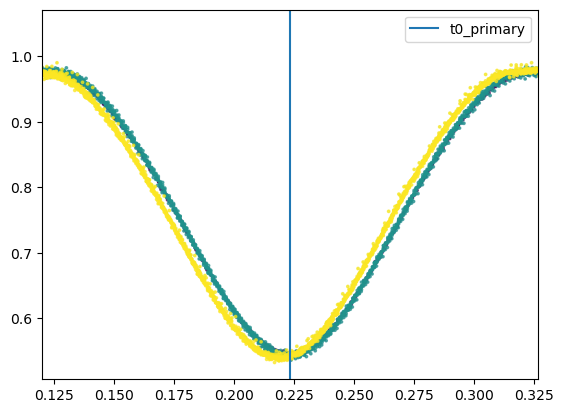


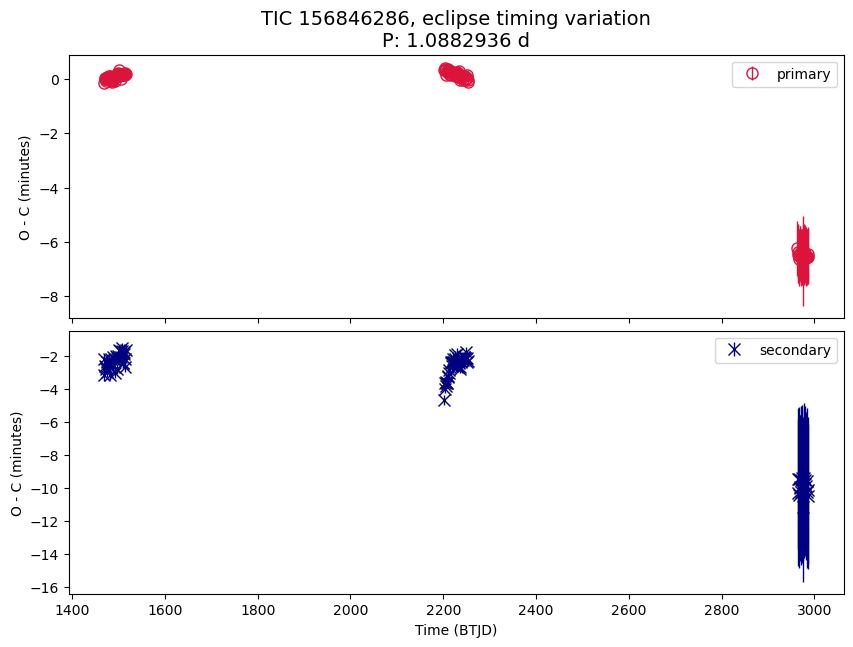



### O-C Plot, Zoom In

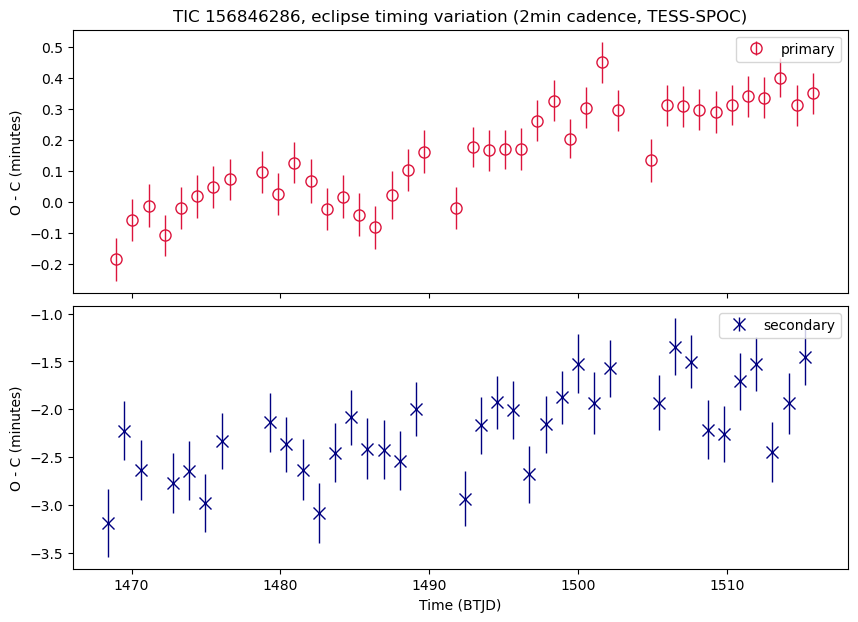

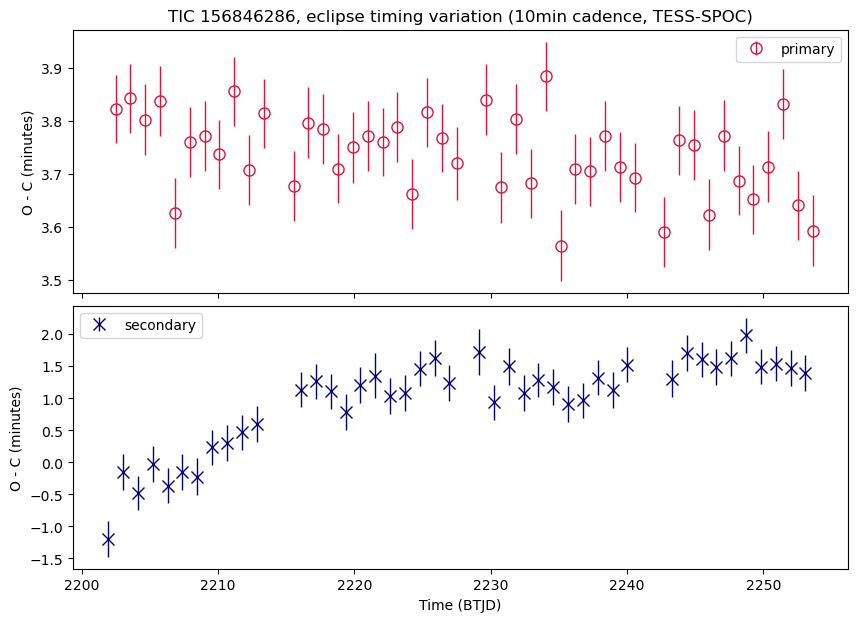

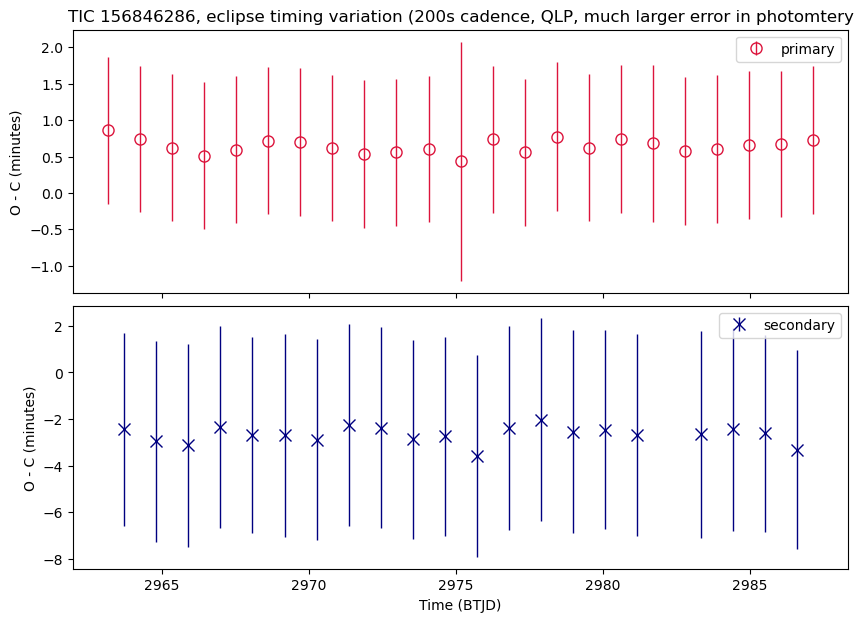

In [12]:
%matplotlib inline
# %matplotlib widget

zoom_ranges = [
    (1400, 1600),
    (2200, 2300),
    (2900, 3000),
]

def tweak_axs_list(axs_list):
    # axs_list[0][1].set_ylim(-20, 30);
    # axs_list[1][0].set_ylim(None, 0.5);
    # axs_list[1][1].set_ylim(-5.5, 2);

    ax = axs_list[0][0]
    ax.set_title(f"{ax.get_title()} (2min cadence, TESS-SPOC)")
    ax = axs_list[1][0]
    ax.set_title(f"{ax.get_title()} (10min cadence, TESS-SPOC)")
    ax = axs_list[2][0]
    ax.set_title(f"{ax.get_title()} (200s cadence, QLP, much larger error in photomtery")
    
    pass


def plot_oc_in_zoom_ranges(in_df_primary, in_df_secondary, zoom_ranges):
    axs_list = []
    for zoom_start, zoom_end in zoom_ranges:
        num_rows = 2 if t0_secondary is not None else 1
        figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5

        fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
        if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
            axs = [axs]

        df_zoom = in_df_primary[(in_df_primary['epoch'] > zoom_start) & (in_df_primary['epoch'] < zoom_end)]

        # axs[0].scatter(df_zoom['epoch'], df_zoom['shift_mins'],
        #                marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
        axs[0].errorbar(df_zoom['epoch'], df_zoom['shift_mins'], yerr = df_zoom['std_mins'],
                        lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")

        if in_df_secondary is not None:
            df_zoom = in_df_secondary[(in_df_secondary['epoch'] > zoom_start) & (in_df_secondary['epoch'] < zoom_end)]

            # axs[1].scatter(df_zoom['epoch'], df_zoom['shift_mins'],
            #                marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
            axs[1].errorbar(df_zoom['epoch'], df_zoom['shift_mins'], yerr = df_zoom['std_mins'],
                            lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );

        for ax in axs:
            ax.set_ylabel("O - C (minutes)")
            ax.legend();

        axs[-1].set_xlabel("Time (BTJD)")
        axs[0].set_title(f"TIC {ticid}, {title_suffix}", fontsize=14)

        plt.subplots_adjust(hspace=0.05)
        axs_list.append(axs)
    return axs_list


axs_list = plot_oc_in_zoom_ranges(in_df_primary, in_df_secondary, zoom_ranges)
tweak_axs_list(axs_list);

## make a periodogram 

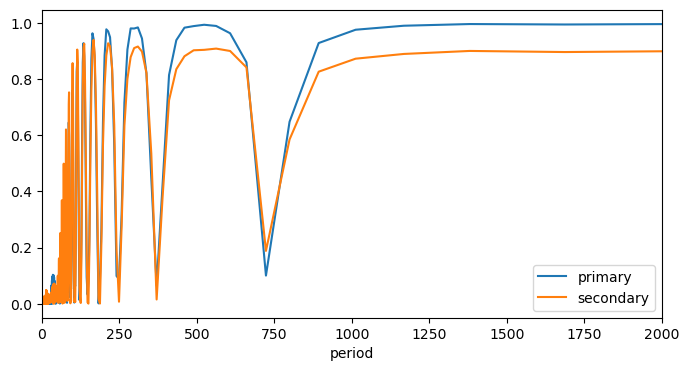

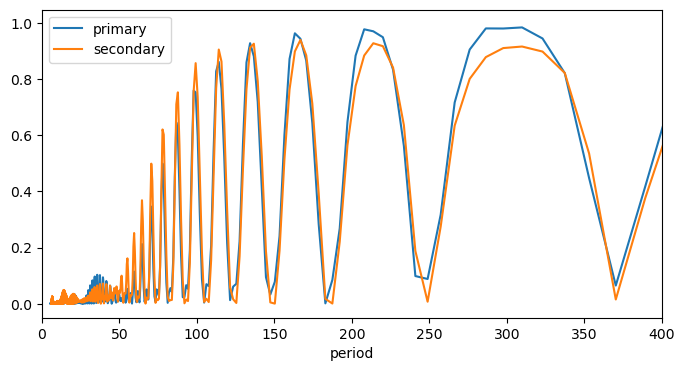

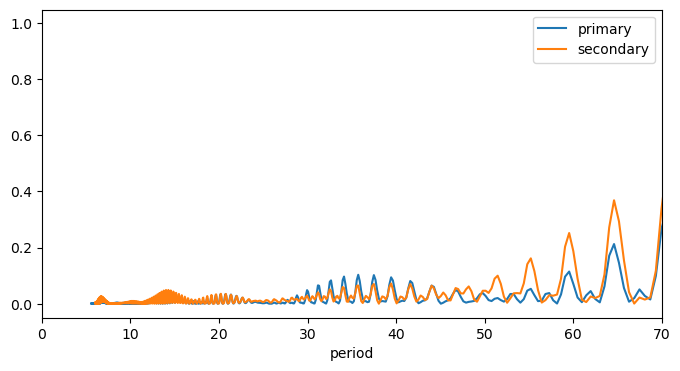

In [67]:
frequency, power = LombScargle(in_df_primary['epoch'], in_df_primary['shift_mins']).autopower()

fig, ax = plt.subplots(figsize=(8, 4))

plt.plot(1/frequency, power, label = 'primary')    

if t0_secondary is not None:
    frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower()
    plt.plot(1/frequency_s, power_s, label = 'secondary')    

plt.xlabel("period")

plt.legend()
plt.xlim(0, 2000)
plt.show()


if True:
    fig, ax = plt.subplots(figsize=(8, 4))
    
    plt.plot(1/frequency, power, label = 'primary')    
    
    if t0_secondary is not None:
        plt.plot(1/frequency_s, power_s, label = 'secondary')    
    
    plt.xlabel("period")
    
    plt.legend()
    plt.xlim(0, 400)
    plt.show()

if True:
    fig, ax = plt.subplots(figsize=(8, 4))
    
    plt.plot(1/frequency, power, label = 'primary')    
    
    if t0_secondary is not None:
        plt.plot(1/frequency_s, power_s, label = 'secondary')    
    
    plt.xlabel("period")
    
    plt.legend()
    plt.xlim(0, 70)
    plt.show()

## O-C plot, folded

- for periodic trend in O-C

In [ ]:
def truncate_freq_power_to_period_range(freq, power, period_min, period_max):
    f, p = freq, power
    if period_min is not None:
        f, p = f[f < 1 / period_min], p[f < 1 / period_min]
    if period_max is not None:
        f, p = f[f > 1 / period_max], p[f >  1 / period_max]
    return f, p


def plot_oc_folded(period_min=None, period_max=None, period_min_s=None, period_max_s=None, period=None, period_s=None):

    if period is None:
        _f, _p = truncate_freq_power_to_period_range(frequency, power, period_min, period_max)
        period = 1 / _f[np.argmax(_p)]
    phase_oc = etv_functions.phase_data(in_df_primary.epoch, 0, period)

    fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y * 1.1), sharex=False)
    if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
        axs = [axs]
    
    axs[0].scatter(phase_oc, in_df_primary.shift_mins, marker = 'o', s=12**2, c=in_df_primary.epoch);
    axs[0].errorbar(phase_oc, in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'],
                    lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'None', label="primary")
    axs[0].set_title(f"TIC {ticid}, {title_suffix}\nfolded with P={period:.4f} d", fontsize=14)

    if in_df_secondary is not None:
        if period_s is None:
            _f, _p = truncate_freq_power_to_period_range(frequency_s, power_s, period_min_s, period_max_s)
            period_s= 1 / _f[np.argmax(_p)]
        phase_oc_s = etv_functions.phase_data(in_df_secondary.epoch, 0, period_s)
        axs[1].scatter(phase_oc_s, in_df_secondary.shift_mins, marker = 'o',  s=12**2, c=in_df_secondary.epoch);
        axs[1].errorbar(phase_oc_s, in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'],
                        lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color='None', ecolor='navy', markeredgecolor = 'None', label="secondary" );
        axs[1].set_title(f"TIC {ticid}, {title_suffix}\nfolded with P={period_s:.4f} d", fontsize=14)

    for ax in axs:
        ax.set_ylabel("O - C (minutes)")
        ax.set_xlabel("Phase (Normalized)")
        ax.legend();
    plt.subplots_adjust(hspace=0.4)
    return axs

In [ ]:
%matplotlib inline
# %matplotlib widget

if True:  # plot O-C periodic trend by folding with a period (from LS Periodogram by default)
    def tweak_axs(axs):
        pass

    axs = plot_oc_folded(
        period=925.190009,
        period_s=925.190009,
    )
    for ax in axs:
        ax.set_title(ax.get_title() + " (SB Period)")
    
    axs = plot_oc_folded(
        period_min=None, period_max=500,
        period_min_s=None, period_max_s=1000,
    )
    axs = plot_oc_folded(
        period_min=None, period_max=40,
        period_min_s=None, period_max_s=40
    )
    tweak_axs(axs)

## Results Summary

In [13]:
# FILL-IN the ETV results / comments
has_etv = "Y?"
comments = "Possible long term (maybe 700d +) non-linear trend with amplitude < 5min.  No clear O-C period.  5 sectors of data but has ~4 years baseline."

# Eclipse depth from the model
depth_pct_p = round(-mean_alpha1 * 100, 2)
if t0_secondary is not None:
    depth_pct_s = round(-mean_alpha1_s * 100, 2)
else:
    depth_pct_s = None

summary = {
    "tic": ticid,
    "has_etv": has_etv,
    "comments": comments,
    "period": period,  # the period used in ETV analysis
    "depth_pct_p": depth_pct_p,
    "depth_pct_s": depth_pct_s,
    "epoch_p": t0_primary,
    "epoch_s": t0_secondary,
    "num_sectors": len(sr),
    "time_span": round(time[-1] - time[0], 2),
    "time_start": round(time[0], 2),
    "time_end": round(time[-1], 2),
}

summary = pd.DataFrame.from_dict(summary, orient="index")
with pd.option_context('display.max_colwidth', None, 'display.max_rows', 999, 'display.max_columns', 99):
    display(summary);

# Single line to be added to a CSV
print("")
print(summary.transpose().to_csv(
    index=False,
    header=True, 
))

0
tic                                                                                                                                              156846286
has_etv                                                                                                                                                 Y?
comments     Possible long term (maybe 700d +) non-linear trend with amplitude < 5min.  No clear O-C period.  5 sectors of data but has ~4 years baseline.
period                                                                                                                                             1.08829
depth_pct_p                                                                                                                                           43.6
depth_pct_s                                                                                                                                          11.61
epoch_p                                                                                                                                          1468.9678
epoch_s                                                                                                                                        1468.423655
num_sectors                                                                                                                                              5
time_span                                                                                                                                          1519.92
time_start                                                                                                                                          1468.3
time_end                                                                                                                                           2988.23


tic,has_etv,comments,period,depth_pct_p,depth_pct_s,epoch_p,epoch_s,num_sectors,time_span,time_start,time_end
156846286,Y?,Possible long term (maybe 700d +) non-linear trend with amplitude < 5min.  No clear O-C period.  5 sectors of data but has ~4 years baseline.,1.08829,43.6,11.61,1468.9678,1468.423655,5,1519.92,1468.3,2988.23

